<a href="https://colab.research.google.com/github/ImagingDataCommons/ai_medima_misc/blob/main/usage_notebooks/scientific_data_paper_usage_notes_nsclc_radiomics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook provides instructions on how to create, interpret and visualize the data associated with the Scientific Data Paper [insert]. 

Before beginning, please set up a project using these instructions [insert]. 

We demonstrate how to: 
- Convert the DICOM Segmentation objects using multiple packages 
- Analyze the DICOM Structured Reports that hold the 3D shape radiomics features
- Analyze the DICOM Structured Reports that hold the body part landmarks and regions 

-- 

To do: 
- make the install packages/parameterization/environment setup easier!! 
- include instructions/link to creating a project 


Deepa Krishnaswamy

Brigham and Women's Hospital 

March 2023

# Parameterization

In [1]:
#--- REPLACE THIS WITH YOUR PROJECT ID, INSTRUCTIONS ABOVE ---# 
project_name = 'idc-external-018'

# Set to 1 if you want to calculate the Dice/HD metrics for every nnU-Net model 
# vs the expert. This process takes a long time, about 1 minute per series for a 
# total of 5 to 6 hours. If instead you want to load the metrics results, and 
# just plot, the results will be read from github. In this case, set to 0. 
run_figure_4_expert_vs_ai_segmentations = 0

# Set to 1 if you want to calculate the distance between the expert lungs vs the 
# lung_top and lung_bottom landmarks produced by BPR. This process could take a 
# long time as we have to download and convert the DICOM SEG objects to obtain 
# the lung segmentations. If instead you want to load the metrics results, and 
# just plot, the results will be read from github. In this case, set to 0. 
run_figure_8_expert_vs_ai_lung_segmentations = 0

# Authorize 
from google.colab import auth
auth.authenticate_user()

# Install packages 

In [2]:
!pip install pyradiomics

!pip install pyplastimatch

!pip uninstall highdicom
!git clone https://github.com/herrmannlab/highdicom.git
#!cd highdicom && python setup.py install
!cd highdicom && pip install .

!pip install pydicom
!pip install pydicom-seg

!pip install --upgrade --pre -q "itk==5.3.0"
!pip install 'itkwidgets>=1.0a23'
!pip install imjoy-elfinder

!pip install selenium # for bokeh 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 35.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 23.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 KB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.4/519.4 KB 38.5 MB/s eta 0:00:00
  Created wheel for pyradiomics: filename=pyradiomics-3.0.1-cp39-cp39-linux_x86_64.whl size=185766 sha256=610187bfdff9041f0e324f5506051310b7a0ee6d1990595cb4fb7c01c3a47871
  Stored in directory: /root/.cache/pip/wheels/62/0f/06/e8bdcc276fc814981e11a2fc4da7ad0da0a7e68a60fe90e747
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13721 sha256=d3dfb4a27e4d1b1ba3e35b8b3cb943a93db762afbb060630a51d5094d9b1f5bc
  Stored in directory: /root/.cache/pip/wheels/70/4a/46/1309fc8

In [3]:
%%capture
!apt install subversion

!svn checkout https://github.com/ImagingDataCommons/ai_medima_misc/trunk/nnunet/src
# !svn checkout https://github.com/ImagingDataCommons/ai_medima_misc/trunk/nnunet/data

In [4]:
!gcloud config set project $project_name

Updated property [core/project].


In [5]:
import os 
import sys 
import time 
import json 
import subprocess 
import glob
import shutil  

import numpy as np 
import matplotlib.pyplot as plt 
import nibabel as nib 
import SimpleITK as sitk
import pandas as pd 
import seaborn as sb 
import db_dtypes

from google.cloud import bigquery
from google.cloud import storage

import pydicom
import pydicom_seg
from collections import OrderedDict

import itk 
from itkwidgets import view
from scipy import ndimage

import seaborn as sns

import src.utils.gcs as gcs
import src.utils.preprocessing as preprocessing
import src.utils.processing as processing
import src.utils.postprocessing as postprocessing

from pathlib import Path  

Let's install packages for plotting, specifically bokeh

In [31]:
# https://docs.bokeh.org/en/latest/docs/user_guide/categorical.html
# http://jaredmmoore.com/bokeh-boxplot-color-by-factor-and-legend-outside-plot/
# https://github.com/jaredmoore/Bokeh_Plot_Examples/blob/master/Bokeh%2012.10%20Boxplot%20AutoGroup.ipynb

from bokeh.models import ColumnDataSource, OpenURL, TapTool
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook
from bokeh.colors import RGB
from bokeh.transform import jitter

from bokeh.models import HoverTool, PanTool, WheelZoomTool, BoxZoomTool, ResetTool, TapTool
from bokeh.models import Legend, LegendItem

from bokeh.palettes import brewer

from bokeh.layouts import row

from bokeh.io import export_png
from bokeh.io.export import get_screenshot_as_png




Let's install and import the packages needed to create Structured Reports (SR). -- I will simplify this later!

In [7]:
# Packages for the structured report 

import highdicom

from pathlib import Path

import highdicom as hd

from pydicom.uid import generate_uid
from pydicom.filereader import dcmread
from pydicom.sr.codedict import codes

from highdicom.sr.content import (
    FindingSite,
    ImageRegion,
    ImageRegion3D,
    SourceImageForRegion,
    SourceImageForMeasurement,
    SourceImageForMeasurementGroup
)
from highdicom.sr.enum import GraphicTypeValues3D
from highdicom.sr.enum import GraphicTypeValues
from highdicom.sr.sop import Comprehensive3DSR, ComprehensiveSR
from highdicom.sr.templates import (
    DeviceObserverIdentifyingAttributes,
    Measurement,
    MeasurementProperties,
    MeasurementReport,
    MeasurementsAndQualitativeEvaluations,
    ObservationContext,
    ObserverContext,
    PersonObserverIdentifyingAttributes,
    PlanarROIMeasurementsAndQualitativeEvaluations,
    RelationshipTypeValues,
    TrackingIdentifier,
    QualitativeEvaluation,
    ImageLibrary,
    ImageLibraryEntryDescriptors,
    ValueTypeValues # I added 
)
from highdicom.sr.value_types import (
    CodedConcept,
    CodeContentItem,
)

import logging
logger = logging.getLogger("highdicom.sr.sop")
logger.setLevel(logging.INFO)


We will next install and import a number of packages needed for organizing and converting DICOM files:

1.    `dicomsort`, a package for sorting DICOM files into a directory tree using specific DICOM fields. 
2.   `plastimatch`, a package used to convert RTSTRUCT DICOM files to nrrd. 
3.   `dcmqi`, a package which converts SEG DICOM files to nrrd.
4.  `dcm2niix`, a package for converting DICOM files to nii 


In [8]:
# %%capture
start_time=time.time()

# FIXME: see if we can convert this to a package as well
# dicomsort 
if os.path.isdir('/content/src/dicomsort'):
  try:
    shutil.rmtree('/content/src/dicomsort')
  except OSError as err:
    print("Error: %s : %s" % ("dicomsort", err.strerror)) 
# !git clone https://github.com/pieper/dicomsort.git 
!git clone https://github.com/pieper/dicomsort.git src/dicomsort

# plastimatch and pyplastimatch
# FIXME: already installed in one of the first cells (also takes care of some
# of the other dependencies, e.g., SITK) 
!sudo apt install plastimatch 
import pyplastimatch as pypla

# FIXME: see if we can convert this to a package as well
# dcmqi 
!wget https://github.com/QIICR/dcmqi/releases/download/v1.2.5/dcmqi-1.2.5-linux.tar.gz
!tar zxvf dcmqi-1.2.5-linux.tar.gz
!cp dcmqi-1.2.5-linux/bin/* /usr/local/bin/

# dcm2niix 
# !sudo apt-get install dcm2niix 
# !curl -fLO https://github.com/rordenlab/dcm2niix/releases/latest/download/dcm2niix_lnx.zip
# !unzip "/content/dcm2niix_lnx.zip"
!wget https://github.com/rordenlab/dcm2niix/releases/latest/download/dcm2niix_lnx.zip
!unzip dcm2niix_lnx.zip
!cp /content/dcm2niix /usr/local/bin 

end_time = time.time()
print ('time to install: ' + str(end_time-start_time))

Cloning into 'src/dicomsort'...
remote: Enumerating objects: 169, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 169 (delta 23), reused 34 (delta 17), pack-reused 126
Receiving objects: 100% (169/169), 87.85 KiB | 1.79 MiB/s, done.
Resolving deltas: 100% (86/86), done.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libdcmtk14 libdlib-data libdlib19 libfftw3-single3 libinsighttoolkit4.13
  libminc2-5.2.0 libnifti2
Suggested packages:
  libfftw3-bin libfftw3-dev
The following NEW packages will be installed:
  libdcmtk14 libdlib-data libdlib19 libfftw3-single3 libinsighttoolkit4.13
  libminc2-5.2.0 libnifti2 plastimatch
0 upgraded, 8 newly installed, 0 to remove and 23 not upgraded.
Need to get 80.1 MB of archives.
After this operation, 169 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu

# Functions

In [9]:
def dataset_exists_in_project(project_id, dataset_id):
  """Check if a dataset exists in a project"""

  from google.cloud import bigquery
  from google.cloud.exceptions import NotFound

  client = bigquery.Client()
  dataset_id_full = '.'.join([project_id, dataset_id])

  try:
      client.get_dataset(dataset_id_full)  
      return True 
  except NotFound:
      return False 

In [10]:
def create_dataset(project_name, dataset_id):

  """
  Create a dataset that will store the cohort_df table 

  Arguments:
    project_name : required - name of the GCP project.
    dataset_id   : required - name of the dataset to create
  
  Returns:
    dataset : returns the dataset created 
  """

  # Construct a BigQuery client object.
  client = bigquery.Client(project=project_name)

  # Construct a full Dataset object to send to the API.
  dataset_id_full = ".".join([project_name, dataset_id])
  dataset = bigquery.Dataset(dataset_id_full)

  # TODO(developer): Specify the geographic location where the dataset should reside.
  dataset.location = "US"

  # Send the dataset to the API for creation, with an explicit timeout.
  # Raises google.api_core.exceptions.Conflict if the Dataset already
  # exists within the project.
  # dataset = client.create_dataset(dataset, timeout=30)  # Make an API request.
  dataset = client.create_dataset(dataset)  # Make an API request.

  print("Created dataset {}.{}".format(client.project, dataset.dataset_id))

  return dataset 


In [11]:
def append_row_to_bq_table_with_query_with_structure_name(project_name, 
                                                          dataset_name, 
                                                          table_name, 
                                                          value_SeriesInstanceUID, 
                                                          value_structure_name, 
                                                          value_model_name, 
                                                          row_to_insert): 

  table_id_fullname = '.'.join([project_name, dataset_name, table_name])
  # print('table_id_fullname: ' + str(table_id_fullname))

  query = f"""
    SELECT 
      COUNT(SeriesInstanceUID) AS num_instances
    FROM 
      {table_id_fullname}
    WHERE 
      SeriesInstanceUID IN UNNEST (@pat_id_change) AND 
      structure_name IN UNNEST (@structure_name) AND 
      model IN UNNEST (@model_name);
  """
  job_config = bigquery.QueryJobConfig(query_parameters=[bigquery.ArrayQueryParameter("pat_id_change", "STRING", [value_SeriesInstanceUID]), 
                                                         bigquery.ArrayQueryParameter("structure_name", "STRING", [value_structure_name]), 
                                                         bigquery.ArrayQueryParameter("model_name", "STRING", [value_model_name]), 
                                                         ]) 
  client = bigquery.Client(project=project_name)
  result = client.query(query, job_config=job_config)
  df_result = result.to_dataframe()
  count = df_result['num_instances'][0]
  print(count)
  
  if (count>=1):
    print("Cannot insert row because seriesInstanceUID and structure exist in table")
  else:
    print("Inserting row into table")
    client = bigquery.Client(project=project_name)
    dataset = client.dataset(dataset_name)
    table_ref = dataset.table(table_name)
    client.insert_rows_json(table = table_ref,
                            json_rows = row_to_insert,
                            skip_invalid_rows = False,
                            ignore_unknown_values = False)

  return 

In [12]:
def append_row_to_bq_table_with_query_lung(project_name, 
                                           dataset_name, 
                                           table_name, 
                                           value_SeriesInstanceUID, 
                                           value_lung, 
                                           row_to_insert):
  
  table_id_fullname = '.'.join([project_name, dataset_name, table_name])
  # print('table_id_fullname: ' + str(table_id_fullname))

  query = f"""
    SELECT 
      COUNT(SeriesInstanceUID) AS num_instances
    FROM 
      {table_id_fullname}
    WHERE 
      SeriesInstanceUID IN UNNEST (@pat_id_change) AND 
      lung IN UNNEST (@value_lung);
  """
  job_config = bigquery.QueryJobConfig(query_parameters=[bigquery.ArrayQueryParameter("pat_id_change", "STRING", [value_SeriesInstanceUID]), 
                                                         bigquery.ArrayQueryParameter("value_lung", "STRING", [value_lung])
                                                         ]) 
  client = bigquery.Client(project=project_name)
  result = client.query(query, job_config=job_config)
  df_result = result.to_dataframe()
  count = df_result['num_instances'][0]
  print(count)
  
  if (count>=1):
    print("Cannot insert row because seriesInstanceUID and lung pos exist in table")
  else:
    print("Inserting row into table")
    client = bigquery.Client(project=project_name)
    dataset = client.dataset(dataset_name)
    table_ref = dataset.table(table_name)
    client.insert_rows_json(table = table_ref,
                            json_rows = row_to_insert,
                            skip_invalid_rows = False,
                            ignore_unknown_values = False)

  return 

In [13]:
def find_lung_extents(seg_nifti_directory): 
  """ Finds the min and max values of the lung from a nifti directory of files converted from dcmqi
  """ 

  dicomseg_json = [os.path.join(seg_nifti_directory,f) for f in os.listdir(seg_nifti_directory) if f.endswith('.json')][0]

  # Get a mapping of the files from the json file to the label 
  label_values, label_names = get_label_and_names_from_metadata_json_all(dicomseg_json)

  # Get a list of just the ones that contain the lung
  label_names_lower = [f.lower() for f in label_names]

  to_include = np.asarray([f.find("lung") for f in label_names_lower]).astype(np.int32) # will be -1 for ones not found
  
  # if every value is -1, lung is not found 
  if (np.max(to_include)==-1):
    min_lung = -1 
    max_lung = -1
  else:
    # get values greater than -1 
    index_include = np.where(to_include>-1)[0]
    label_values_include = np.asarray(label_values)[index_include.astype(int)]
    label_names_include = np.asarray(label_names)[index_include.astype(int)]

    # If multiple, get min and max of each 
    num_labels_include = len(label_values_include)
    min_vals = [] 
    max_vals = [] 

    for n in range(0,num_labels_include):
      nii = nib.load(os.path.join(seg_nifti_directory,str(label_values_include[n])+'.nii.gz'))
      img = nii.get_fdata() 
      indices = np.where(img>0)[2] # z 
      min_val = min(indices)
      max_val = max(indices)
      min_vals.append(min_val)
      max_vals.append(max_val)

    # Get overall min and max 
    min_lung = np.min(np.asarray(min_vals))
    max_lung = np.max(np.asarray(max_vals))

  return min_lung, max_lung 

In [14]:
def get_label_and_names_from_metadata_json_all(dicomseg_json):

  """Returns two lists containing the label values and the corresponding
    CodeMeaning values. Takes into account the modifier
    "SegmentedPropertyTypeModifierCodeSequence for determining laterality. 

  Inputs: 
    dicomseg_json : metajson file

  Outputs:
    label_values  : label values from the metajson file 
    label_names   : the corresponding CodeMeaning values 
    """

  f = open(dicomseg_json)
  meta_json = json.load(f)

  # first_entry = meta_json['segmentAttributes']
  first_entry = meta_json['segmentAttributes'][0][0] 
  if (type(first_entry) is dict): 
    num_regions = len(meta_json['segmentAttributes'])
  else:
    num_regions = len(meta_json['segmentAttributes'][0])
  print('num_regions: ' + str(num_regions))

  label_values = [] 
  label_names = [] 

  for n in range(0,num_regions):
    if (type(first_entry) is dict):
      label_value = meta_json['segmentAttributes'][n][0]['labelID']
      label_name = meta_json['segmentAttributes'][n][0]['SegmentedPropertyTypeCodeSequence']['CodeMeaning']
      dict_key = "SegmentedPropertyTypeModifierCodeSequence"
      if (dict_key in meta_json['segmentAttributes'][n][0].keys()):
        label_modifier = meta_json['segmentAttributes'][n][0]['SegmentedPropertyTypeModifierCodeSequence']['CodeMeaning']
        label_name = label_name + '_' + label_modifier 
    else: 
      label_value = meta_json['segmentAttributes'][0][n]['labelID']
      label_name = meta_json['segmentAttributes'][0][n]['SegmentedPropertyTypeCodeSequence']['CodeMeaning']
    label_values.append(label_value)
    label_names.append(label_name)

  print('label_values: ' + str(label_values))
  print('label_names: ' + str(label_names))

  return label_values, label_names

In [15]:
def color_list_generator(df, treatment_col):
    """ Create a list of colors per treatment given a dataframe and 
        column representing the treatments.
        
        Args:
            df - dataframe to get data from
            treatment_col - column to use to get unique treatments.
                
        Inspired by creating colors for each treatment 
        Rough Source: http://bokeh.pydata.org/en/latest/docs/gallery/brewer.html#gallery-brewer
        Fine Tune Source: http://bokeh.pydata.org/en/latest/docs/gallery/iris.html
    """
    # Get the number of colors we'll need for the plot.
    # colors = brewer["Dark2"][len(df[treatment_col].unique())] # was Spectral

    print('check this value: ' + str(len(df[treatment_col].unique())))

    if (len(df[treatment_col].unique()))==1:
      # value = len(df[treatment_col].unique()[0])
      # print('value: ' + str(value))
      colors = brewer["Dark2"][3][0:1] # Spectral, Dark2
    elif (len(df[treatment_col].unique()))==2: 
      colors = brewer["Dark2"][3][0:2]
    elif (len(df[treatment_col].unique()))>8: 
      num_colors = len(df[treatment_col].unique())
      num_colormaps = np.int32(np.ceil(num_colors/8))
      colormap_chained = brewer["Dark2"][8]*num_colormaps 
      colors = colormap_chained[0:num_colors]
    else: 
      colors = brewer["Dark2"][len(df[treatment_col].unique())]
    print(colors)

    # Create a map between treatment and color.
    colormap = {i: colors[k] for k,i in enumerate(df[treatment_col].unique())}

    # Return a list of colors for each value that we will be looking at.
    return colormap, [colormap[x] for x in df[treatment_col]]

# nnU-Net prediction analysis

## Download

### Download DICOM Segmentation objects 

Get the gcs url to download the SEG files 

In [ ]:
client = bigquery.Client(project=project_name)
# table_id = ".".join(['idc-dev-etl', 'idc_v13_pub', 'dicom_all']) # later will change to use idc_current. 
table_id = ".".join(['bigquery-public-data', 'idc_current', 'dicom_all'])
print(table_id)

query = f"""
  SELECT 
    PatientID, 
    StudyInstanceUID,
    SeriesInstanceUID, 
    SOPInstanceUID, 
    SeriesDescription,
    gcs_url
  FROM 
    {table_id}
  WHERE
    Modality = "SEG" AND 
    collection_id = "nsclc_radiomics"
  ORDER BY 
    PatientID, 
    StudyInstanceUID, 
    SeriesInstanceUID;
"""

job_config = bigquery.QueryJobConfig()
seg_df = client.query(query, job_config=job_config).to_dataframe()

bigquery-public-data.idc_current.dicom_all


Choose single patient and download the files 

In [ ]:
PatientID = sorted(list(set(seg_df['PatientID'].values)))[1] 
print(PatientID)

LUNG1-002


In [ ]:
seg_df_patient = seg_df[seg_df['PatientID']==PatientID] 
seg_df_patient

PatientID                                   StudyInstanceUID  \
4  LUNG1-002  1.3.6.1.4.1.32722.99.99.2037150038059966416957...   
5  LUNG1-002  1.3.6.1.4.1.32722.99.99.2037150038059966416957...   
6  LUNG1-002  1.3.6.1.4.1.32722.99.99.2037150038059966416957...   
7  LUNG1-002  1.3.6.1.4.1.32722.99.99.2037150038059966416957...   

                                   SeriesInstanceUID  \
4  1.2.276.0.7230010.3.1.3.2323910823.11504.15972...   
5  1.2.276.0.7230010.3.1.3.481034752.112041.16656...   
6  1.2.276.0.7230010.3.1.3.481034752.398262.16657...   
7  1.2.276.0.7230010.3.1.3.481034752.68078.166429...   

                                      SOPInstanceUID  \
4  1.2.276.0.7230010.3.1.4.2323910823.11504.15972...   
5  1.2.276.0.7230010.3.1.4.481034752.112041.16656...   
6  1.2.276.0.7230010.3.1.4.481034752.398262.16657...   
7  1.2.276.0.7230010.3.1.4.481034752.68078.166429...   

                     SeriesDescription  \
4                         Segmentation   
5   3d_lowres-tta_nnU-Net_Segmentation   
6          2d-tta_nnU-Net_Segmentation   
7  3d_fullres-tta_nnU-Net_Segmentation   

                                             gcs_url  
4  gs://idc-open-cr/eff917af-8a2a-42fe-9e12-22bce...  
5  gs://public-datasets-idc/99ce9653-4f74-4954-aa...  
6  gs://public-datasets-idc/e4bc75aa-cfca-4b6f-9e...  
7  gs://public-datasets-idc/a8adc5d1-d4af-4653-96...

Download the SEG files 

In [ ]:
# Download all the DICOM Segmentation files 

# Create the text file to hold gsc_url 
gcsurl_temp = seg_df_patient["gcs_url"]
gs_file_path = "gcs_paths.txt"
gcsurl_temp.to_csv(gs_file_path, header = False, index = False)

# Download the series 
seg_directory = "/content/seg"
if not os.path.isdir(seg_directory):
  os.mkdir(seg_directory)

# !cat manifest.txt | gsutil -m cp -I .
!cat gcs_paths.txt | gsutil -m cp -I $seg_directory

Copying gs://idc-open-cr/eff917af-8a2a-42fe-9e12-22bceaac5da9.dcm...
Copying gs://public-datasets-idc/99ce9653-4f74-4954-aa00-e94470abeee7.dcm...
Copying gs://public-datasets-idc/e4bc75aa-cfca-4b6f-9ee9-e98d47b212d5.dcm...
Copying gs://public-datasets-idc/a8adc5d1-d4af-4653-966a-f0132333fd7e.dcm...
\ [4/4 files][ 41.8 MiB/ 41.8 MiB] 100% Done                                    
Operation completed over 4 objects/41.8 MiB.                                     


Use dicomsort to sort the DICOM files 

In [ ]:
# Sort files 
seg_directory_sorted = "/content/seg_sorted"
if not os.path.join(seg_directory_sorted):
  os.mkdir(seg_directory_sorted)

!python src/dicomsort/dicomsort.py -u $seg_directory $seg_directory_sorted/%PatientID/%Modality/%SeriesDescription.dcm



100% 4/4 [00:00<00:00,  4.13it/s]
Files sorted


In [ ]:
input_dicom_files = sorted(os.listdir(os.path.join(seg_directory_sorted,PatientID,"SEG")))
input_dicom = os.path.join(seg_directory_sorted,PatientID,"SEG",input_dicom_files[0])

### Download the associated CT files 

In [ ]:
# Get the referenced seriesInstanceUID from the input_dicom 

dcm = pydicom.dcmread(input_dicom)
# series_id = dcm['0020', '000e'].value # later figure out what field to use. 
# series_id = dcm['0008', '1115']['0020', '000e'].value
series_id = dcm['0008', '1115'][0]['SeriesInstanceUID'].value # # later figure out what field to use. 


In [ ]:
client = bigquery.Client(project=project_name)
  
query_view = f"""
  SELECT 
    SeriesInstanceUID,
    SOPInstanceUID, 
    gcs_url 
  FROM
    `bigquery-public-data.idc_current.dicom_all` 
  WHERE
    SeriesInstanceUID = @series_id;
  """

start_time = time.time()
job_config = bigquery.QueryJobConfig(query_parameters=[
                                                       bigquery.ScalarQueryParameter("series_id", "STRING", series_id)
                                                       ])
result = client.query(query_view, job_config=job_config) 
series_df = result.to_dataframe(create_bqstorage_client=True)
end_time = time.time()
print ('elapsed time: ' + str(end_time-start_time)) 

elapsed time: 2.229651927947998


In [ ]:
# Download the gcs_urls 

# Create the text file to hold gsc_url 
gs_file_path = "gcs_paths.txt"
series_df["gcs_url"].to_csv(gs_file_path, header = False, index = False)

# Download the series 
download_path = "/content/raw"
if not os.path.isdir(download_path):
  os.mkdir(download_path)

# !cat manifest.txt | gsutil -m cp -I .
!cat gcs_paths.txt | gsutil -m cp -I $download_path

Copying gs://idc-open-cr/8d11ef77-909c-4de3-b550-cb3bd7f00d8a.dcm...
Copying gs://idc-open-cr/b670ab0d-71a0-4a30-af78-c0676666d81d.dcm...
Copying gs://idc-open-cr/07610515-ec98-4852-bdd8-0dd5a91f5478.dcm...
Copying gs://idc-open-cr/93361b61-85b9-4fc0-b015-d02245f2459c.dcm...
Copying gs://idc-open-cr/52ea13a8-f89b-4da0-8435-0293d117069a.dcm...
Copying gs://idc-open-cr/b85dc3e1-8c86-473d-a62d-0bb0f4b10a89.dcm...
Copying gs://idc-open-cr/ebed7073-8a61-46f8-adf0-929a39e1e8b8.dcm...
Copying gs://idc-open-cr/eafbfe99-84f0-44e5-a31d-21856912dc4d.dcm...
Copying gs://idc-open-cr/66065989-9029-40c3-9f3f-66794ecaca3b.dcm...
Copying gs://idc-open-cr/5f1ab5c8-0c48-45bd-9166-90449e14616b.dcm...
Copying gs://idc-open-cr/eb161df8-b9f1-4b30-89f1-cfe557671c48.dcm...
Copying gs://idc-open-cr/805b08bb-1935-4007-94a7-9ac04b14993a.dcm...
Copying gs://idc-open-cr/8ddfd645-fa50-4843-bce7-a629988a0c38.dcm...
Copying gs://idc-open-cr/29946a45-da88-447c-9738-56c75a3824e1.dcm...
Copying gs://idc-open-cr/867e960a-

## Conversion of DICOM files

### Convert the raw CT files to nii 

In [ ]:
# Convert to nifti 
ct_nifti_directory = "/content/ct_nii" 
if not os.path.isdir(ct_nifti_directory): 
  os.mkdir(ct_nifti_directory)

cmd = 'dcm2niix -z y -m y -o %s  %s ' % (ct_nifti_directory, download_path)
print(cmd)
ret = os.system(cmd)
print(ret)

dcm2niix -z y -m y -o /content/ct_nii  /content/raw 
0


In [ ]:
# Rename file 

nii_file_orig = [os.path.join(ct_nifti_directory,f) for f in os.listdir(ct_nifti_directory) if f.endswith('.nii.gz')][0] 
nii_file = "/content/ct.nii.gz"
os.rename(nii_file_orig, nii_file)


### Use dcmqi to convert the DICOM Segmentation object to a nifti file 

Insert text of the output of dcmqi. 

In [ ]:
input_dicom_files = sorted(os.listdir(os.path.join(seg_directory_sorted,PatientID,"SEG")))
input_dicom = os.path.join(seg_directory_sorted,PatientID,"SEG",input_dicom_files[0])

In [ ]:
output_directory_seg_converted_dcmqi = "/content/seg_converted_dcmqi"
if not os.path.isdir(output_directory_seg_converted_dcmqi):
  os.mkdir(output_directory_seg_converted_dcmqi)

print(input_dicom)
print(output_directory_seg_converted_dcmqi)

# !segimage2itkimage --outputType "nrrd" --outputDirectory $output_directory_seg_converted_dcmqi --inputDICOM $input_dicom 
!segimage2itkimage --outputType "nii" --outputDirectory $output_directory_seg_converted_dcmqi --inputDICOM $input_dicom 


/content/seg_sorted/LUNG1-002/SEG/2d-tta_nnU-Net_Segmentation.dcm
/content/seg_converted_dcmqi
dcmqi repository URL: git@github.com:QIICR/dcmqi.git revision: 1153738 tag: v1.2.5
Row direction: 1 0 0
Col direction: 0 -1 0
Z direction: 0 0 -1
Total frames: 205
Total frames with unique IPP: 85
Total overlapping frames: 77
Origin: [-250.112, 249.135, 154.6]


Resample the segmentation back to the original size

In [ ]:
nii_file

'/content/ct.nii.gz'

In [ ]:
# Resample each file 

seg_files = [os.path.join(output_directory_seg_converted_dcmqi,f) for f in os.listdir(output_directory_seg_converted_dcmqi) if f.endswith('.nii.gz')] 
num_seg_files = len(seg_files)
print('num_seg_files: ' + str(num_seg_files))

output_directory_seg_converted_dcmqi_resampled = "/content/seg_converted_dcmqi_resampled"
if not os.path.isdir(output_directory_seg_converted_dcmqi_resampled):
  os.mkdir(output_directory_seg_converted_dcmqi_resampled)

for n in range(0,num_seg_files):
  fixed_image = nii_file
  input_image = os.path.join(output_directory_seg_converted_dcmqi, str(n+1) + ".nii.gz")
  output_image = os.path.join(output_directory_seg_converted_dcmqi_resampled, str(n+1) + ".nii.gz")
  !plastimatch resample --fixed $fixed_image --input $input_image --output $output_image --interpolation nn

num_seg_files: 4
Trying to write image to /content/seg_converted_dcmqi_resampled/1.nii.gz
Trying to write image to /content/seg_converted_dcmqi_resampled/2.nii.gz
Trying to write image to /content/seg_converted_dcmqi_resampled/3.nii.gz
Trying to write image to /content/seg_converted_dcmqi_resampled/4.nii.gz


In [ ]:
# Combine the files into a single label file 

seg_files = sorted([os.path.join(output_directory_seg_converted_dcmqi_resampled,f) for f in os.listdir(output_directory_seg_converted_dcmqi_resampled) if f.endswith('.nii.gz')]) 
                                                                                                
for n in range(0,num_seg_files): 
  if n==0:
    nii = nib.load(seg_files[n])
    volume = nii.get_fdata() 
  else: 
    nii_segment = nib.load(seg_files[n])
    volume_segment = nii_segment.get_fdata() 
    volume[volume_segment>0] = n+1
    
print(np.unique(volume))

volume_nii = nib.Nifti1Image(volume, None, nii.header)
nib.save(volume_nii, '/content/segmentation_dcmqi_resampled.nii.gz')


[0. 1. 2. 3. 4.]


### Use pydicom_seg to convert the DICOM Segmentation object to a nifti file

In [ ]:
!pip install pydicom-seg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pydicom
import pydicom_seg
import SimpleITK as sitk

output_directory_seg_converted_pydicom = "/content/seg_converted_pydicom"
if not os.path.isdir(output_directory_seg_converted_pydicom):
  os.mkdir(output_directory_seg_converted_pydicom)

dcm = pydicom.dcmread(input_dicom)

reader = pydicom_seg.SegmentReader()
result = reader.read(dcm)

for segment_number in result.available_segments:
    image_data = result.segment_data(segment_number)  # directly available
    image = result.segment_image(segment_number)  # lazy construction
    print(image.GetSize())
    # sitk.WriteImage(image, f'/content/pydicom_seg/segmentation-{segment_number}.nii.gz', True) 
    sitk.WriteImage(image, f'/content/seg_converted_pydicom/{segment_number}.nii.gz', True) # resample back to CT in next step 


(512, 512, 85)
(512, 512, 85)
(512, 512, 85)
(512, 512, 85)


In [ ]:
# Resample each file 

seg_files = [os.path.join(output_directory_seg_converted_pydicom,f) for f in os.listdir(output_directory_seg_converted_pydicom) if f.endswith('.nii.gz')] 
num_seg_files = len(seg_files)
print('num_seg_files: ' + str(num_seg_files))

output_directory_seg_converted_pydicom_resampled = "/content/seg_converted_pydicom_seg_resampled"
if not os.path.isdir(output_directory_seg_converted_pydicom_resampled):
  os.mkdir(output_directory_seg_converted_pydicom_resampled)

for n in range(0,num_seg_files):
  fixed_image = nii_file
  input_image = os.path.join(output_directory_seg_converted_pydicom, str(n+1) + ".nii.gz")
  output_image = os.path.join(output_directory_seg_converted_pydicom_resampled, str(n+1) + ".nii.gz")
  !plastimatch resample --fixed $fixed_image --input $input_image --output $output_image --interpolation nn



num_seg_files: 4
Trying to write image to /content/seg_converted_pydicom_seg_resampled/1.nii.gz
Trying to write image to /content/seg_converted_pydicom_seg_resampled/2.nii.gz
Trying to write image to /content/seg_converted_pydicom_seg_resampled/3.nii.gz
Trying to write image to /content/seg_converted_pydicom_seg_resampled/4.nii.gz


In [ ]:
# Combine the files into a single label file 

seg_files = sorted([os.path.join(output_directory_seg_converted_pydicom_resampled,f) for f in os.listdir(output_directory_seg_converted_pydicom_resampled) if f.endswith('.nii.gz')]) 
                                                                                                
for n in range(0,num_seg_files): 
  if n==0:
    nii = nib.load(seg_files[n])
    volume = nii.get_fdata() 
  else: 
    nii_segment = nib.load(seg_files[n])
    volume_segment = nii_segment.get_fdata() 
    volume[volume_segment>0] = n+1
print(np.unique(volume))

volume_nii = nib.Nifti1Image(volume, None, nii.header)
nib.save(volume_nii, '/content/segmentation_pydicom_resampled.nii.gz')

[0. 1. 2. 3. 4.]


###  Use highdicom + code from dcmqi to convert the DICOM Segmentation object to a nifti file 

Using seg = hd.seg.segread and seg.get_pixels_by_source_instance, we can get the segmentation labels as a numpy array. Unfortunately, we are not returned information about the orientation and therefore do not have a way of mapping this back to the same space as the CT. 

Therefore, we get the position and orientation information ourselves and reconstruct a 3D volume. As reference we use https://github.com/QIICR/dcmqi/blob/master/libsrc/ImageSEGConverter.cpp#L483

In [ ]:
# Use highdicom to read the DICOM Segmentation file 
seg = hd.seg.segread(input_dicom) 

# Extract orientation information we need for reconstruction
Rows = np.int32(seg.Rows)
Columns = np.int32(seg.Columns)
ImageOrientationPatient = np.float32(seg.SharedFunctionalGroupsSequence[0].PlaneOrientationSequence[0].ImageOrientationPatient)
ImageOrientationPatient_x = ImageOrientationPatient[0:3]
ImageOrientationPatient_y = ImageOrientationPatient[3:6]
SliceThickness = np.float32(seg.SharedFunctionalGroupsSequence[0].PixelMeasuresSequence[0].SliceThickness)
SpacingBetweenSlices = np.float32(seg.SharedFunctionalGroupsSequence[0].PixelMeasuresSequence[0].SpacingBetweenSlices)
PixelSpacing_x = np.float32(seg.SharedFunctionalGroupsSequence[0].PixelMeasuresSequence[0].PixelSpacing[0])
PixelSpacing_y = np.float32(seg.SharedFunctionalGroupsSequence[0].PixelMeasuresSequence[0].PixelSpacing[1])

# calculate cross product (sliceDirection) using ImageOrientationPatient
orientation_x = ImageOrientationPatient[0:3] / np.linalg.norm(ImageOrientationPatient[0:3])
orientation_y = ImageOrientationPatient[3:5] / np.linalg.norm(ImageOrientationPatient[4:6])
sliceDirection = np.cross(orientation_x, orientation_y)

print('Rows: ' + str(Rows))
print('Columns: ' + str(Columns))
print('ImageOrientationPatient: ' + str(ImageOrientationPatient))
print('sliceDirection: ' + str(sliceDirection))
print('SliceThickness: ' + str(SliceThickness))
print('SpacingBetweenSlices: ' + str(SpacingBetweenSlices)) 
print('PixelSpacing_x: ' + str(PixelSpacing_x)) 
print('PixelSpacing_y: ' + str(PixelSpacing_y))

Rows: 512
Columns: 512
ImageOrientationPatient: [ 1.  0.  0.  0. -1.  0.]
sliceDirection: [ 0.  0. -1.]
SliceThickness: 3.0
SpacingBetweenSlices: 3.0
PixelSpacing_x: 0.977
PixelSpacing_y: 0.977


In [ ]:
# ------------------ # 
# Using the PerFrameFunctionalGroupsSequence, we extract the segment_number (in our case we have 4 segments), 
# and the associated ImagePositionPatient for each of the slices 

# This is the total number of per frame functional groups 
num_seg_slices = len(seg.PerFrameFunctionalGroupsSequence)
print('num_seg_slices: ' + str(num_seg_slices))

segment_number = [] # keeps track of which segment 
segment_ImagePositionPatient = [] 
for n in range(0,num_seg_slices):
  segment_number.append(np.int32(seg.PerFrameFunctionalGroupsSequence[n].SegmentIdentificationSequence[0].ReferencedSegmentNumber))
  segment_ImagePositionPatient.append(np.float32(np.asarray(seg.PerFrameFunctionalGroupsSequence[n].PlanePositionSequence[0].ImagePositionPatient)))
segment_number = np.asarray(segment_number)
segment_ImagePositionPatient = np.stack(segment_ImagePositionPatient, axis=0)

# Create a dict to store the number of unique segments, and the number of frames for each  
number_of_segments, segment_number_of_frames = np.unique(segment_number, return_counts=True)
segment_number_dict = dict(zip(number_of_segments, segment_number_of_frames))
print('segment_number_dict: ' + str(segment_number_dict))

# ------------------ # 
# We then need to compute the volume Extent, by getting the number of unique ImagePositionPatient values 

unique_ImagePositionPatient = np.unique(segment_ImagePositionPatient, axis=0)
num_slices = len(unique_ImagePositionPatient)
print('num_slices: ' + str(num_slices)) 

# ------------------- # 
# We need to calculate the image origin which will be used for stacking the 
# slices for each of the segments in the right order 

# Find which x,y,z index we should use for ImagePositionPatient 
max_ind = np.argmax(np.abs(sliceDirection))
print('max_ind: ' + str(max_ind))

# Find which one has the minimum value in the max_ind position 
origin_ind = np.argmin(unique_ImagePositionPatient[:,max_ind])
print('origin_ind: ' + str(origin_ind))

# ImageOrigin = np.min(unique_ImagePositionPatient[origin_ind,:])
ImageOrigin = unique_ImagePositionPatient[origin_ind,:]
print('ImageOrigin: ' + str(ImageOrigin))

origin_ind_max = np.argmax(unique_ImagePositionPatient[:,max_ind])
print('origin_ind_max: ' + str(origin_ind_max))
ImageOrigin_max = unique_ImagePositionPatient[origin_ind_max,:]
print('ImageOrigin_max: ' + str(ImageOrigin_max))

num_seg_slices: 205
segment_number_dict: {1: 77, 2: 26, 3: 39, 4: 63}
num_slices: 85
max_ind: 2
origin_ind: 0
ImageOrigin: [-250.112     249.13501   -97.399994]
origin_ind_max: 84
ImageOrigin_max: [-250.112    249.13501  154.6    ]


In [ ]:
# This function is to map the ImagePositionPatient to an axial slice index value 

def map_position_to_index(imagepositionpatient, SpacingBetweenSlices, ImageOrigin_max, max_ind):

  dist = ImageOrigin - imagepositionpatient 
  # slice_index = np.int32(np.round(dist[max_ind] / SpacingBetweenSlices) )
  slice_index = np.int32(np.around(dist[max_ind] / SpacingBetweenSlices) ) - 1 

  return slice_index 

In [ ]:
# --------------------------# 
# Now we form the volume

# We get the pixel_array from seg - this concatenates all labels in the x axis 
pixel_array = seg.pixel_array 
print('pixel_array: ' + str(pixel_array.shape))

# We want to form a single volume for all labels 
volume = np.zeros((Rows, Columns, num_slices)) 
print('volume: ' + str(volume.shape))

# This is an index to make sure it is the same as the x value for pixel_array 
matching_rows_sum = 0 

# For each axial slice, and for each segment present in that slice, we add 
# the appropriate labels 
for n in range(0,num_slices):

  # Get a unique IPP 
  imagepositionpatient = unique_ImagePositionPatient[n,:]

  # Find the matching rows indices in segment_ImagePositionPatient 
  # The length of this is equal to the number of segments that are present in the same slice 
  matching_rows = np.int32(np.where((segment_ImagePositionPatient == imagepositionpatient).all(axis=1))[0])

  # Get the corresonding segment numbers 
  matching_segment_numbers = segment_number[matching_rows]

  # Get the axial slice index for this unique IPP 
  # slice_num = map_position_to_index(imagepositionpatient, SpacingBetweenSlices, ImageOrigin, max_ind)
  slice_num = map_position_to_index(imagepositionpatient, SpacingBetweenSlices, ImageOrigin_max, max_ind)
  
  # Use this index to make sure it is the same as the x value for pixel_array 
  matching_rows_sum += len(matching_segment_numbers)

  # For each segment present in the slice, add the appropriate slice from the pixel_array 
  for m in range(0,len(matching_segment_numbers)): 
    slice_keep = pixel_array[matching_rows[m],:,:]
    # volume[:,:,slice_num,m] = slice_keep * matching_segment_numbers[m] # 1,2,3,4 
    volume[:,:,slice_num] = volume[:,:,slice_num] + (slice_keep * matching_segment_numbers[m])

# Print some error checking 
print('Number of axial slices: ' + str(len(unique_ImagePositionPatient))) # Should be equal to the number of slices in our final volume 
print('Segment numbers: ' + str(np.unique(volume))) # Should be the segment numbers 
print('matching_rows_sum: ' + str(matching_rows_sum)) # Should be equal to the x axis of pixel_array

pixel_array: (205, 512, 512)
volume: (512, 512, 85)
Number of axial slices: 85
Segment numbers: [0. 1. 2. 3. 4.]
matching_rows_sum: 205


#### Convert to ITK image and save as nifti

In [ ]:
print('original volume: ' + str(volume.shape))
volume = np.rollaxis(volume, 2, 0)
print ('volume: ' + str(volume.shape))

itk_volume = sitk.GetImageFromArray(volume)
spacing = [np.float64(PixelSpacing_x), np.float64(PixelSpacing_y), np.float64(SpacingBetweenSlices)]
origin = [np.float64(ImageOrigin_max[0]), np.float64(ImageOrigin_max[1]), np.float64(ImageOrigin_max[2])]
direction = np.zeros((3,3)) 
direction[0,:] = [np.float64(ImageOrientationPatient_x[0]), 
                  np.float64(ImageOrientationPatient_x[1]), 
                  np.float64(ImageOrientationPatient_x[2])]
direction[1,:] = [np.float64(ImageOrientationPatient_y[0]), 
                  np.float64(ImageOrientationPatient_y[1]), 
                  np.float64(ImageOrientationPatient_y[2])]
direction[2,:] = [np.float64(sliceDirection[0]), 
                  np.float64(sliceDirection[1]), 
                  np.float64(sliceDirection[2])]
direction = np.hstack(direction)
print('spacing: ' + str(spacing)) 
print('origin: ' + str(origin))
print('direction: ' + str(direction)) 

itk_volume.SetSpacing(spacing) 
itk_volume.SetOrigin(origin)
itk_volume.SetDirection(direction) 

output_directory_seg_converted_highdicom = '/content/seg_converted_highdicom'
if not os.path.isdir(output_directory_seg_converted_highdicom): 
  os.mkdir(output_directory_seg_converted_highdicom)

outputImageFileName = os.path.join(output_directory_seg_converted_highdicom, "highdicom_volume.nii.gz")
writer = sitk.ImageFileWriter()
writer.SetFileName(outputImageFileName)
writer.Execute(itk_volume)

original volume: (512, 512, 85)
volume: (85, 512, 512)
spacing: [0.9769999980926514, 0.9769999980926514, 3.0]
origin: [-250.11199951171875, 249.135009765625, 154.60000610351562]
direction: [ 1.  0.  0.  0. -1.  0.  0.  0. -1.]


In [ ]:
# ----------------- # 
# Now we can resample this nifti file back to the original CT space 

# Resample to the original CT 

output_directory_seg_converted_highdicom_resampled = "/content/seg_converted_highdicom_resampled" 
if not os.path.isdir(output_directory_seg_converted_highdicom_resampled): 
  os.mkdir(output_directory_seg_converted_highdicom_resampled)

seg_file = os.path.join(output_directory_seg_converted_highdicom, 'highdicom_volume.nii.gz')
seg_file_resampled = os.path.join(output_directory_seg_converted_highdicom_resampled, 'highdicom_volume_resampled.nii.gz')

fixed_image = nii_file
input_image = seg_file
output_image = seg_file_resampled
!plastimatch resample --fixed $fixed_image --input $input_image --output $output_image # --interpolation nn

Trying to write image to /content/seg_converted_highdicom_resampled/highdicom_volume_resampled.nii.gz


## Visualization of DICOM files and nifti files

### Use ITKWidgets to visualize the CT DICOM files and the DICOM Segmentation object

In [ ]:
# Read the DICOM MR series' objects and reconstruct them into a 3D ITK image.
#   The itk.F option is added to store the image in memory using floating-point precision pixels (useful if you will filter the image or use it with MONAI)
#   For more info on imread, see https://itkpythonpackage.readthedocs.io/en/master/Quick_start_guide.html 

pro_ct_dir = '/content/raw'
pro_ct_image = itk.imread(pro_ct_dir, itk.F)

# Read the DICOM SEG object using pydicom and pydicom_seg.
pro_seg_file = '/content/seg_sorted/LUNG1-002/SEG/3d_fullres-tta_nnU-Net_Segmentation.dcm' # for now.
pro_seg_dicom = pydicom.dcmread(pro_seg_file)
seg_reader = pydicom_seg.MultiClassReader()
pro_seg_obj = seg_reader.read(pro_seg_dicom)

# Convert the DICOM SEG object into an itk image, with correct voxel origin, spacing, and directions in physical space.
pro_seg_image = itk.GetImageFromArray(pro_seg_obj.data.astype(np.float32))
pro_seg_image.SetOrigin(pro_seg_obj.origin)
pro_seg_image.SetSpacing(pro_seg_obj.spacing)
pro_seg_image.SetDirection(pro_seg_obj.direction)

In [ ]:
viewerA = view(image=pro_ct_image, 
               label_image=pro_seg_image)


In [ ]:
viewerA.set_image_color_map("Grayscale")
# viewerA.set_image_color_range([0,400])
viewerA.set_view_mode("ZPlane")
# viewerA.set_z_slice(53)
viewerA.set_ui_collapsed(False)

### Use ITKWidgets to view the CT nifti file and segmentation nifti file 

In [ ]:
# We need to convert our CT nifti and segmentation nifti files to ITK objects 

# print(nii_file)
# nii_file = '/content/ct.nii.gz'
ct_nii = nib.load('/content/ct.nii.gz') 
ct_data = ct_nii.get_fdata() 
ct_header = ct_nii.header 

ct_itk = itk.GetImageFromArray(ct_data) 
# ct_itk.SetOrigin(ct_header['origin'])
# ct_itk.SetSpacing(np.float32(ct_header['pixdim'][1:4]))
# ct_itk.SetDirection()

# itk_seg_image = itk.GetImageFromArray(itk_seg_obj.data.astype(np.float32))
# itk_seg_image.SetOrigin(itk_seg_obj.origin)
# itk_seg_image.SetSpacing(itk_seg_obj.spacing)
# itk_seg_image.SetDirection(itk_seg_obj.direction)

seg_nii = nib.load("/content/segmentation_dcmqi_resampled.nii.gz")
seg_data = seg_nii.get_fdata() 
seg_itk = itk.GetImageFromArray(seg_data)



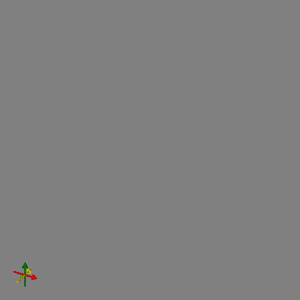
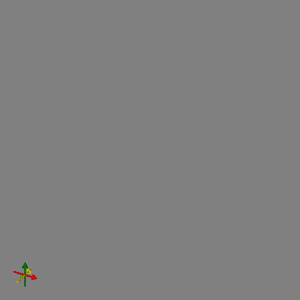

In [ ]:
viewerB = view(image=ct_itk, 
               label_image=seg_itk)
viewerB.set_image_color_map("Grayscale")
viewerB.set_ui_collapsed(False)
viewerB.set_view_mode("ZPlane")
viewerB.set_z_slice(40)
viewerB.set_image_color_range([-1000,200]) # figure out good values later.


### Use custom code to overlay the CT numpy array and segmentation numpy array

In [ ]:
from pyplastimatch import pyplastimatch as pypla
from pyplastimatch.utils import viz as viz_utils
from pyplastimatch.utils import data as data_utils

from matplotlib.colors import ListedColormap

cmap = plt.cm.Reds
my_reds = cmap(np.arange(cmap.N))
my_reds[:,-1] = np.linspace(0, 1, cmap.N)
my_reds = ListedColormap(my_reds)

cmap = plt.cm.Greens
my_greens = cmap(np.arange(cmap.N))
my_greens[:,-1] = np.linspace(0, 1, cmap.N)
my_greens = ListedColormap(my_greens)

cmap = plt.cm.Blues
my_blues = cmap(np.arange(cmap.N))
my_blues[:,-1] = np.linspace(0, 1, cmap.N)
my_blues = ListedColormap(my_blues)

cmap = plt.cm.spring
my_spring = cmap(np.arange(cmap.N))
my_spring[:,-1] = np.linspace(0, 1, cmap.N)
my_spring = ListedColormap(my_spring)

In [ ]:
# Convert nii to nrrd for viz 
verbose = True 

log_file_path_nii = "/content/pypla.txt"
# convert_args_nii = {"input": "/content/raw", 
#                     "output-img": "/content/ct.nrrd"}
# pypla.convert(verbose = verbose, path_to_log_file = log_file_path_nii, **convert_args_nii)

convert_args_nii = {"input": "/content/ct.nii.gz", 
                    "output-img": "/content/ct.nrrd"}
pypla.convert(verbose = verbose, path_to_log_file = log_file_path_nii, **convert_args_nii)

if not os.path.isdir("/content/nrrd"): 
  os.mkdir("/content/nrrd")

for n in range(0,4): 
  input_img = os.path.join("/content/seg_converted_dcmqi_resampled", str(n+1)+".nii.gz")
  output_img = os.path.join("/content/nrrd", str(n+1)+".nrrd")
  convert_args_nii = {"input": input_img, 
                    "output-img": output_img}
  pypla.convert(verbose = verbose, path_to_log_file = log_file_path_nii, **convert_args_nii)


Running 'plastimatch convert' with the specified arguments:
  --input /content/ct.nii.gz
  --output-img /content/ct.nrrd
... Done.

Running 'plastimatch convert' with the specified arguments:
  --input /content/seg_converted_dcmqi_resampled/1.nii.gz
  --output-img /content/nrrd/1.nrrd
... Done.

Running 'plastimatch convert' with the specified arguments:
  --input /content/seg_converted_dcmqi_resampled/2.nii.gz
  --output-img /content/nrrd/2.nrrd
... Done.

Running 'plastimatch convert' with the specified arguments:
  --input /content/seg_converted_dcmqi_resampled/3.nii.gz
  --output-img /content/nrrd/3.nrrd
... Done.

Running 'plastimatch convert' with the specified arguments:
  --input /content/seg_converted_dcmqi_resampled/4.nii.gz
  --output-img /content/nrrd/4.nrrd
... Done.


In [ ]:
# ct_data = nib.load("/content/ct.nii.gz").get_fdata() 
# print('ct_data: ' + str(ct_data.shape))

# pred_heart = nib.load("/content/seg_converted_dcmqi_resampled/2.nii.gz").get_fdata() 
# pred_aorta = nib.load("/content/seg_converted_dcmqi_resampled/4.nii.gz").get_fdata()
# pred_trachea = nib.load("/content/seg_converted_dcmqi_resampled/3.nii.gz").get_fdata()
# pred_esophagus = nib.load("/content/seg_converted_dcmqi_resampled/1.nii.gz").get_fdata()

# ct_data = np.rollaxis(ct_data, 2, 0)
# print('ct_data: ' + str(ct_data.shape))
# pred_heart = np.rollaxis(pred_heart, 2, 0); # pred_heart = np.swapaxes(pred_heart, 1, 2)
# pred_aorta = np.rollaxis(pred_aorta, 2, 0); # pred_aorta = np.swapaxes(pred_aorta, 1, 2)
# pred_trachea = np.rollaxis(pred_trachea, 2, 0); # pred_trachea = np.swapaxes(pred_trachea, 1, 2)
# pred_esophagus = np.rollaxis(pred_esophagus, 2, 0); # pred_esophagus = np.swapaxes(pred_esophagus, 1, 2)
# ct_data = np.swapaxes(ct_data, 1, 2)

In [ ]:
# _ = viz_utils.AxialSliceSegmaskViz(ct_volume = ct_data, 
#                                    segmask_dict = {"Heart" : pred_heart,
#                                                              "Aorta" : pred_aorta,
#                                                              "Trachea" : pred_trachea,
#                                                              "Esophagus" : pred_esophagus}, 
#                                    segmask_cmap_dict = {"Heart" : my_greens,
#                                                                "Aorta" : my_spring,
#                                                                "Esophagus" : my_reds,
#                                                                "Trachea" : my_blues}, 
#                                    dpi = 100)
ct_nrrd = sitk.GetArrayFromImage(sitk.Flip(sitk.ReadImage("/content/ct.nrrd"), [False, True, False]))
pred_nrrd_heart = sitk.GetArrayFromImage(sitk.Flip(sitk.ReadImage("/content/nrrd/2.nrrd"), [False, True, False]))
pred_nrrd_aorta = sitk.GetArrayFromImage(sitk.Flip(sitk.ReadImage("/content/nrrd/4.nrrd"), [False, True, False]))
pred_nrrd_trachea = sitk.GetArrayFromImage(sitk.Flip(sitk.ReadImage("/content/nrrd/3.nrrd"), [False, True, False]))
pred_nrrd_esophagus = sitk.GetArrayFromImage(sitk.Flip(sitk.ReadImage("/content/nrrd/1.nrrd"), [False, True, False]))

_ = viz_utils.AxialSliceSegmaskViz(ct_volume = ct_nrrd, 
                                   segmask_dict = {"Heart" : pred_nrrd_heart,
                                                             "Aorta" : pred_nrrd_aorta,
                                                             "Trachea" : pred_nrrd_trachea,
                                                             "Esophagus" : pred_nrrd_esophagus}, 
                                   segmask_cmap_dict = {"Heart" : my_greens,
                                                               "Aorta" : my_spring,
                                                               "Esophagus" : my_reds,
                                                               "Trachea" : my_blues}, 
                                   dpi = 100)

interactive(children=(Output(),), _dom_classes=('widget-interact',))

## **(paper figure #4)** NSCLC Radiomics - comparison of expert segmentations and AI-derived segmentations

We first query to get a list of the DICOM Segmentation objects for the expert in the NSCLC-Radiomics collection. We query for the ones that have a SegmentedPropertyType Code Meaning of Esophagus, Heart, Trachea or Aorta. The seg_SeriesInstanceUIDs will later be used to get a list of the corresponding AI-derived segmentations. 

In [16]:
client = bigquery.Client(project=project_name)

query = """

# First get a list of the SOPInstanceUIDs of the DICOM Segmentation objects for the expert in the NSCLC-Radiomics collection
WITH seg_sops AS (
  SELECT 
    PatientID, 
    SeriesInstanceUID, 
    SOPInstanceUID,
    SeriesDescription,
    gcs_url
  FROM 
    `bigquery-public-data.idc_current.dicom_all`
  WHERE
    Modality = "SEG" AND 
    collection_id = "nsclc_radiomics" AND 
    SeriesDescription = "Segmentation"
  ORDER BY 
    PatientID 
)

# Now join the above to get only the segmented_SeriesInstanceUIDs that have the regions we want
# We will use these to get the AI-derived DICOM Segmentation objects 
SELECT 
  DISTINCT(seg.segmented_SeriesInstanceUID), 
  seg.PatientID, 
  seg_sops.SOPInstanceUID,
  seg_sops.SeriesDescription,
  seg_sops.gcs_url

FROM 
  `bigquery-public-data.idc_current.segmentations` as seg 
JOIN 
  seg_sops 
ON 
  seg.SOPInstanceUID = seg_sops.SOPInstanceUID
WHERE
  seg.SegmentedPropertyType.CodeMeaning = "Esophagus" OR 
  seg.SegmentedPropertyType.CodeMeaning = "Heart" OR
  seg.SegmentedPropertyType.CodeMeaning = "Trachea" OR
  seg.SegmentedPropertyType.CodeMeaning = "Aorta"
ORDER BY 
  seg.PatientID; 

"""

job_config = bigquery.QueryJobConfig()
seg_expert_df = client.query(query, job_config=job_config).to_dataframe()


For each of the SeriesInstanceUIDs they reference, get a dataframe of the gcs_urls of the AI-derived segmentations 

In [17]:
seg_expert_series_ids = list(set(seg_expert_df['segmented_SeriesInstanceUID'].values))

client = bigquery.Client(project=project_name)

query = """

# Now we need to get the gcs_urls etc for the AI-derived Segmentations, for the seriesInstanceUIDs from the expert 

# First we need to get the possible SOPInstanceUIDs for the seriesInstanceUIDs from the expert 
WITH seg_series AS (
  SELECT 
    PatientID, 
    segmented_SeriesInstanceUID, 
    SOPInstanceUID,
    SegmentedPropertyType.CodeMeaning as code_meaning
  FROM 
    `bigquery-public-data.idc_current.segmentations` 
  WHERE
    segmented_SeriesInstanceUID IN UNNEST(@series_ids) 
)  

# Now need to get the SeriesDescription and gcs_url for those DICOM Segmentation objects 
SELECT 
  DISTINCT(seg_series.segmented_SeriesInstanceUID),
  dicom_all.PatientID, 
  dicom_all.SOPInstanceUID,
  dicom_all.SeriesDescription,
  dicom_all.gcs_url
FROM 
  `bigquery-public-data.idc_current.dicom_all` as dicom_all
JOIN 
  seg_series 
ON 
  seg_series.SOPInstanceUID = dicom_all.SOPInstanceUID 
WHERE
  dicom_all.Modality = "SEG" AND 
  dicom_all.SeriesDescription <> "Segmentation" # these are the expert segmentations, so we do not want to include them 
ORDER BY 
  dicom_all.PatientID
"""

job_config = bigquery.QueryJobConfig(    
    query_parameters=[
        bigquery.ArrayQueryParameter("series_ids", "STRING", seg_expert_series_ids)])
seg_ai_df = client.query(query, job_config=job_config).to_dataframe()

The above seg_ai_df only has the patients that were processed. Therefore, we modify our seg_expert_df to include those patients. 

In [18]:
seg_ai_series = list(set(seg_ai_df['segmented_SeriesInstanceUID'].values))
seg_expert_df = seg_expert_df[seg_expert_df['segmented_SeriesInstanceUID'].isin(seg_ai_series)]
print(len(seg_expert_df))

349


For each series, download the expert SEG. For each nnunet model (will be 3 per series), download the AI derived SEG. Convert to nii and compute the Dice/HD metrics. We will store the results into a a dataframe. We will store this as a table in case we do not want to repeat the processing.  

The processing of all series takes about a minute per series, taking about 5-6 hours. Therefore, we create a table and append our Dice/HD metrics to this table. A series/structure is skipped if the row already exists in the table. 

Create a dataset to store the table in, if it doesn't already exist. 

In [19]:
dataset_table_id = 'dataset_nsclc' 
nnunet_comparison_table_id = 'usage_notebook_nnunet_comparison_table'

In [20]:
# Check if the dataset exists within the project 
dataset_exists = dataset_exists_in_project(project_name, dataset_table_id)

# If it does not exist, create the dataset 
if not dataset_exists: 
  print ('creating dataset: ' + str(dataset_table_id))
  create_dataset(project_name, dataset_table_id)
else:
  print ('dataset ' + str(dataset_table_id) + ' already exists.')

dataset dataset_nsclc already exists.


In [21]:
# Set up the run parameters 

# Dice score and HD score table 
# If table doesn't exist, create the schema based on the above 

from google.cloud.exceptions import NotFound
client = bigquery.Client(project=project_name)

nnunet_comparison_table_id_fullname = '.'.join([project_name, dataset_table_id, nnunet_comparison_table_id])
print('nnunet_comparison_table_id_fullname: ' + str(nnunet_comparison_table_id_fullname))

try:
  client.get_table(nnunet_comparison_table_id_fullname) 
  nnunet_comparison_table_exists = 1 
except NotFound: 
  nnunet_comparison_table_exists = 0 

if (nnunet_comparison_table_exists==0):

  schema = [
      bigquery.SchemaField("PatientID", "STRING", mode="REQUIRED"), 
      bigquery.SchemaField("SeriesInstanceUID", "STRING", mode="REQUIRED"), 
      bigquery.SchemaField("structure_name", "STRING", mode="REQUIRED"), # added
      bigquery.SchemaField("dice_score", "FLOAT", mode="REQUIRED"), # added instead of time 
      bigquery.SchemaField("hausdorff_distance", "FLOAT", mode="REQUIRED"), # added instead of time 
      bigquery.SchemaField("hausdorff_distance_95", "FLOAT", mode="REQUIRED"), # added instead of time 
      bigquery.SchemaField("model", "STRING", mode="REQUIRED"), 
  ] 

  table = bigquery.Table(nnunet_comparison_table_id_fullname, schema=schema)
  table = client.create_table(table)  # Make an API request.
  print(
      "Created table {}.{}.{}".format(table.project, table.dataset_id, table.table_id)
  )

else: 
  print ("Table " + str(nnunet_comparison_table_id_fullname) + ' already exists.')


nnunet_comparison_table_id_fullname: idc-external-018.dataset_nsclc.usage_notebook_nnunet_comparison_table
Table idc-external-018.dataset_nsclc.usage_notebook_nnunet_comparison_table already exists.


In [23]:
# --- Calculate the metrics for each series --- # 
# --- Takes 1 minute per series, 5-6 hours --- # 
# --- Save to a bigQuery table --- # 
if (run_figure_4_expert_vs_ai_segmentations):

  series_to_eval_id_list = list(set(seg_expert_df['segmented_SeriesInstanceUID'].values))

  ai_derived_comparison_df = pd.DataFrame() 
  ai_derived_series_descriptions = list(set(seg_ai_df['SeriesDescription'].values))

  print(ai_derived_series_descriptions)


  segmented_SeriesInstanceUIDs = [] 
  structure_names = [] 
  seriesDescriptions = [] 
  dice_scores = [] 
  hausdorff_distances = [] 
  hausdorff_distances_95 = [] 

  eval_dice = True 
  eval_hausdorff = True

  # --- for each series --- #
  for idx, series_id in enumerate(series_to_eval_id_list):

    print("(%g/%g) Running evaluation for series %s"%(idx + 1, len(series_to_eval_id_list), series_id))

    # Get the df of the expert 
    seg_expert_df_series = seg_expert_df[seg_expert_df['segmented_SeriesInstanceUID']==series_id]

    patient_id = seg_expert_df_series["PatientID"].values[0] 
    print('PatientID: ' + str(patient_id))

    # Download expert 
    # Create the text file to hold gsc_url 
    gcsurl_temp = seg_expert_df_series["gcs_url"]
    gs_file_path = "gcs_paths.txt"
    gcsurl_temp.to_csv(gs_file_path, header = False, index = False)
    # Download the series 
    seg_expert_directory = "/content/seg_expert"
    if not os.path.isdir(seg_expert_directory):
      os.mkdir(seg_expert_directory)
    # !cat manifest.txt | gsutil -m cp -I .
    !cat gcs_paths.txt | gsutil -m cp -I $seg_expert_directory

    # Rename this file 
    input_path = os.path.join(seg_expert_directory, os.listdir(seg_expert_directory)[0])
    output_path = os.path.join(seg_expert_directory, series_id + '.dcm')
    shutil.move(input_path,output_path)

    # Create the appropriate folders 
    manual_dicomseg_path = output_path
    manual_seg_folder_path = "/content/seg_expert_nrrd"
    if not os.path.isdir(manual_seg_folder_path): 
      os.mkdir(manual_seg_folder_path)

    # convert the DICOM SEG obbject storing the inference results into NRRD
    postprocessing.dicomseg_to_nrrd(path_to_dicomseg_file = manual_dicomseg_path,
                                    path_to_output_dir = manual_seg_folder_path)

    # Get the df of the ai-derived 
    seg_ai_df_series = seg_ai_df[seg_ai_df['segmented_SeriesInstanceUID']==series_id]

    # --- for each model ---# 
    for nnunet_model in ai_derived_series_descriptions: 

      print ('nnunet_model: ' + str(nnunet_model))

      # Get the gcs_url of the specific model 
      seg_ai_df_series_model = seg_ai_df_series[seg_ai_df_series['SeriesDescription']==nnunet_model]

      # Download ai derived 
      # Create the text file to hold gsc_url 
      gcsurl_temp = seg_ai_df_series_model["gcs_url"]
      gs_file_path = "gcs_paths.txt"
      gcsurl_temp.to_csv(gs_file_path, header = False, index = False)
      # Download the series 
      seg_ai_directory = "/content/seg_ai"
      if not os.path.isdir(seg_ai_directory):
        os.mkdir(seg_ai_directory)
      # !cat manifest.txt | gsutil -m cp -I .
      !cat gcs_paths.txt | gsutil -m cp -I $seg_ai_directory

      # Rename this file 
      input_path = os.path.join(seg_ai_directory, os.listdir(seg_ai_directory)[0])
      output_path = os.path.join(seg_ai_directory, series_id + '.dcm')
      shutil.move(input_path,output_path)

      # Create the appropriate folders 
      pred_dicomseg_path = output_path
      pred_seg_folder_path = "/content/seg_ai_nrrd"
      if not os.path.isdir(pred_seg_folder_path): 
        os.mkdir(pred_seg_folder_path)

      # Create dicts 
      dc_dict = dict()
      hd_dict = dict()
      
      dc_dict[series_id] = dict()
      hd_dict[series_id] = dict()

      # clear_output(wait = True)

      # convert the DICOM SEG obbject storing the inference results into NRRD
      postprocessing.dicomseg_to_nrrd(path_to_dicomseg_file = pred_dicomseg_path,
                                      path_to_output_dir = pred_seg_folder_path)

      # the evaluation must be run on the structures that have a manual ground truth only
      pred_structure_list = [f for f in os.listdir(pred_seg_folder_path) if ".nrrd" in f]
      manual_structure_list = [f for f in os.listdir(manual_seg_folder_path) if ".nrrd" in f]
      eval_structure_list = list(set(pred_structure_list).intersection(set(manual_structure_list)))

      # --- for each structure --- # 
      for structure_fn in eval_structure_list:

        pred_seg_nrrd_path = os.path.join(pred_seg_folder_path, structure_fn)
        manual_seg_nrrd_path = os.path.join(manual_seg_folder_path, structure_fn)
        print('pred_seg_nrrd_path: ' + str(pred_seg_nrrd_path))
        print('manual_seg_nrrd_path: ' + str(manual_seg_nrrd_path))

        structure_name = os.path.splitext(structure_fn)[0]
        print('structure_name: ' + str(structure_name))

        # Dice Coefficient
        if eval_dice == True:
          try: 
              dc_summary_dict = pypla.dice(path_to_reference_img = manual_seg_nrrd_path,
                                          path_to_test_img = pred_seg_nrrd_path)

              dc_dict[series_id][structure_name] = dc_summary_dict

          except Exception as e:
              dc_dict[series_id][structure_name] = dict()
              print(e)

        # Hausdorff Coefficient
        if eval_hausdorff == True:
          try: 
              # hd_summary_dict = pypla.hd(path_to_reference_img = manual_seg_nrrd_path,
              #                            path_to_test_img = pred_seg_nrrd_path)

              # hd_dict[series_id][structure_name] = hd_summary_dict
              bash_command = list()
              bash_command += ["plastimatch", "dice", "--hausdorff"]
              bash_command += [manual_seg_nrrd_path, pred_seg_nrrd_path]
              hausdorff_summary = subprocess.run(bash_command, capture_output = True, check = True)
              hd_dict[series_id][structure_name]= {}
              metric_names = [f.split("=")[0] for f in str(hausdorff_summary.stdout).split("\\n")]
              print("metric_names: " + str(metric_names))
              # ind = metric_names.index("Hausdorff distance ")
              # find first instance where one of the metrics contains "Hausdorff distance "
              ind = np.where(np.asarray([f.find("Hausdorff distance") for f in metric_names]) != -1)[0][0]
              hd_dict[series_id][structure_name]["hd"] = float(str(hausdorff_summary.stdout).split("\\n")[ind].split("=")[1])
              hd_dict[series_id][structure_name]["hd95"] = float(str(hausdorff_summary.stdout).split("\\n")[ind+3].split("=")[1]) 

          except Exception as e:
              hd_dict[series_id][structure_name] = dict()
              print(e)

        # Add to overall dataframe 
        # ai_derived_comparison_table
        segmented_SeriesInstanceUIDs.append(series_id)
        structure_names.append(structure_name)
        seriesDescriptions.append(nnunet_model)
        dice_scores.append(np.float64(dc_dict[series_id][structure_name]['dc']))
        hausdorff_distances.append(np.float64(hd_dict[series_id][structure_name]['hd'])) 
        hausdorff_distances_95.append(np.float64(hd_dict[series_id][structure_name]['hd95']))

        # add to table 
        row_to_insert = [] 
        row_to_insert_dict = OrderedDict([("PatientID", patient_id), 
                                          ("SeriesInstanceUID", series_id), 
                                          ("structure_name", str(structure_name)), 
                                          ("dice_score", np.float64(dc_dict[series_id][structure_name]['dc'])), 
                                          ("hausdorff_distance", np.float64(hd_dict[series_id][structure_name]['hd'])),
                                          ("hausdorff_distance_95", np.float64(hd_dict[series_id][structure_name]['hd95'])), 
                                          ("model", nnunet_model)
                                          ])
        row_to_insert.append(row_to_insert_dict)

        append_row_to_bq_table_with_query_with_structure_name(project_name, 
                                                              dataset_table_id, 
                                                              nnunet_comparison_table_id, 
                                                              series_id, 
                                                              structure_name, 
                                                              nnunet_model, 
                                                              row_to_insert)

      # --- For each model --- #
      !rm -r /content/seg_ai 
      !rm -r /content/seg_ai_nrrd
    
    # --- For each series --- # 
    !rm -r /content/seg_expert 
    !rm -r /content/seg_expert_nrrd

  # # Form the df 
  # ai_derived_comparison_df['segmented_SeriesInstanceUID'] = segmented_SeriesInstanceUIDs
  # ai_derived_comparison_df['structure_name'] = structure_names 
  # ai_derived_comparison_df['seriesDescription'] = seriesDescriptions
  # ai_derived_comparison_df['dice_score'] = dice_scores
  # ai_derived_comparison_df['hausdorff_distance'] = hausdorff_distances 
  # ai_derived_comparison_df['hausdorff_distance_95'] = hausdorff_distances_95


In [ ]:
### DELETE THIS CELL LATER. For putting csv on github ###

# Get table and convert to dataframe 

client = bigquery.Client(project=project_name)
nnunet_comparison_table_id_fullname = ".".join([project_name, dataset_table_id, nnunet_comparison_table_id])
print('nnunet_comparison_table_id_fullname: ' + str(nnunet_comparison_table_id_fullname)) 

query = f"""
  SELECT 
    * 
  FROM 
    {nnunet_comparison_table_id_fullname};
"""

job_config = bigquery.QueryJobConfig()
seg_expert_vs_ai_df = client.query(query, job_config=job_config).to_dataframe()

# Add the OHIF urls, need to first get the StudyInstanceUIDs 

client = bigquery.Client(project=project_name)
series_ids = list(seg_expert_vs_ai_df['SeriesInstanceUID'].values)
query = f"""
  SELECT 
    DISTINCT(SeriesInstanceUID),
    StudyInstanceUID,
    CONCAT("https://viewer.imaging.datacommons.cancer.gov/viewer/",StudyInstanceUID) as viewer_url
  FROM 
    `bigquery-public-data.idc_current.dicom_all` 
  WHERE
    SeriesInstanceUID IN UNNEST(@series_ids); 
  """
job_config = bigquery.QueryJobConfig(query_parameters=[
                                                       bigquery.ArrayQueryParameter("series_ids", "STRING", series_ids)
                                                       ])
studyids_df = client.query(query, job_config=job_config).to_dataframe()

# Add the studyInstanceUIDS and viewer_urls to the seg_expert_vs_ai_df 
study_ids = [] 
viewer_urls = [] 
for n in range(0,len(seg_expert_vs_ai_df)):
  series_id = seg_expert_vs_ai_df['SeriesInstanceUID'].values[n]
  # get matching studyInstanceUID and viewer_url and concat 
  study_id = studyids_df[studyids_df['SeriesInstanceUID']==series_id]['StudyInstanceUID'].values[0] 
  viewer_url = studyids_df[studyids_df['SeriesInstanceUID']==series_id]['viewer_url'].values[0] 
  study_ids.append(study_id)
  viewer_urls.append(viewer_url)
seg_expert_vs_ai_df['StudyInstanceUID'] = study_ids 
seg_expert_vs_ai_df['viewer_url'] = viewer_urls 

# Save as csv and download 

segmentation_metrics_expert_vs_ai_csv = "/content/segmentation_metrics_expert_vs_ai.csv"
filepath = Path(segmentation_metrics_expert_vs_ai_csv)  
filepath.parent.mkdir(parents=True, exist_ok=True)  
seg_expert_vs_ai_df.to_csv(filepath, index=False)  

from google.colab import files
files.download(segmentation_metrics_expert_vs_ai_csv) 

# # Upload manually to github 


nnunet_comparison_table_id_fullname: idc-external-018.dataset_nsclc.usage_notebook_nnunet_comparison_table


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Load the table from BigQuery if run_figure_4_expert_vs_ai_segmentations is set to 1. If set to 0, read the table from github. 

In [24]:
# --- Load the table from BigQuery --- # 
if (run_figure_4_expert_vs_ai_segmentations):

  client = bigquery.Client(project=project_name)
  nnunet_comparison_table_id_fullname = ".".join([project_name, dataset_table_id, nnunet_comparison_table_id])
  print('nnunet_comparison_table_id_fullname: ' + str(nnunet_comparison_table_id_fullname)) 
  query = f"""
    SELECT 
      * 
    FROM 
      {nnunet_comparison_table_id_fullname};
  """
  job_config = bigquery.QueryJobConfig()
  seg_expert_vs_ai_df = client.query(query, job_config=job_config).to_dataframe()

# --- Load the table from github ---# 
else: 

  # Get the csv 
  segmentation_metrics_expert_vs_ai_csv = "/content/segmentation_metrics_expert_vs_ai.csv"
  !wget -O $segmentation_metrics_expert_vs_ai_csv https://raw.githubusercontent.com/ImagingDataCommons/ai_medima_misc/main/usage_notebooks/segmentation_metrics_expert_vs_ai.csv
  # Convert to dataframe 
  seg_expert_vs_ai_df = pd.read_csv(segmentation_metrics_expert_vs_ai_csv)  

--2023-03-23 14:20:12--  https://raw.githubusercontent.com/ImagingDataCommons/ai_medima_misc/main/usage_notebooks/segmentation_metrics_expert_vs_ai.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 453417 (443K) [text/plain]
Saving to: ‘/content/segmentation_metrics_expert_vs_ai.csv’

/content/segmentati 100%[===================>] 442.79K  --.-KB/s    in 0.04s   

2023-03-23 14:20:12 (11.5 MB/s) - ‘/content/segmentation_metrics_expert_vs_ai.csv’ saved [453417/453417]



Create plots for each of the metrics comparing the AI-derived segmentations to the ground truth for each region 

In [ ]:
# table_nnunet_comparison_df = seg_expert_vs_ai_df 
# structure_list = list(set(table_nnunet_comparison_df['structure_name'].values))
# num_structures = len(structure_list)
# column_names_distance = ['dice_score', 'hausdorff_distance', 'hausdorff_distance_95']

# # --- Per structure --- # 
# for m in range(0,num_structures): 

#   # Only keep df of structure we want to plot 
#   df_plot_structure = table_nnunet_comparison_df[table_nnunet_comparison_df["structure_name"]==structure_list[m]]

#   # --- Per distance metric - Dice, HD, HD95 --- # 
#   for q in range(0,3): 

#     # output_filename = comparison_filename_colab_list[q] + '_' + str(structure_list[m])
#     # print('output_filename: ' + str(output_filename))
#     # output_file(output_filename)
#     output_notebook()

#     # Create table where name of column is called 'distance'
#     # df_plot = df_plot_structure.rename(columns={column_names_distance[p]: 'distance'})
#     df_plot = df_plot_structure.rename({column_names_distance[q]: 'distance'}, axis=1)

#     # Get a color for each region 
#     # colormap, colors = color_list_generator(df_plot, 'experiment')
#     colormap, colors = color_list_generator(df_plot, 'model')
#     df_plot['colors'] = colors
#     colormap_list_keys = list(colormap.keys())
#     # colormap_list_keys = sorted(list(colormap.keys()))
#     # colormap_list_keys = nnunet_model_bucket_list_with_tta

#     print('colormap: ' + str(colormap))
#     print('colormap_list_keys: ' + str(colormap_list_keys))
#     regions = colormap_list_keys 
#     print('regions: ' + str(regions))

#     # df_plot 

#     colors = list(colormap.values())
#     print('colors: ' + str(colors))

#     hover = HoverTool(tooltips=[
#         ("(Distance)", "($y)")
#     ])

#     wZoom = WheelZoomTool()
#     bZoom = BoxZoomTool()
#     reset = ResetTool()
#     tap = TapTool()
#     pan = PanTool()

#     # cats = df_plot.experiment.unique()
#     cats = regions 
#     print('cats: ' + str(cats))
#     print('regions: ' + str(regions))

#     p1 = figure(tools = [hover, wZoom, bZoom, reset, tap, pan],
#               x_range=regions,
#               # x_range=cats, 
#               title="Distance metric")

#     # l1 = p1.circle(y='distance', x=jitter('experiment', width=0.6, range=p1.x_range), source=df_plot, alpha=1, color='colors')
#     l1 = p1.circle(y='distance', x=jitter('model', width=0.6, range=p1.x_range), source=df_plot, alpha=1, color='colors')


#     # legend = Legend(items=[LegendItem(label=dict(field="experiment"), renderers=[l1])])
#     legend = Legend(items=[LegendItem(label=dict(field="model"), renderers=[l1])])
    
#     p1.add_layout(legend, 'below')    
    
#     # Setup plot titles and such.
#     # p.title.text = "Ratio of slices for each body part examined region"
#     p1.title.text = str(column_names_distance[q]) + '_' + str(structure_list[m])
#     p1.xgrid.grid_line_color = None
#     p1.ygrid.grid_line_color = "white"
#     p1.grid.grid_line_width = 2
#     p1.xaxis.major_label_text_font_size="0pt"
#     p1.xaxis.major_label_orientation = np.pi/4
#     p1.xaxis.axis_label = 'Models'
#     p1.yaxis.axis_label = column_names_distance[q]
#     p1.legend.location = (100,10)

#     ### Include the box plots ### 
#     # find the quartiles and IQR for each category

#     p2 = figure(tools = [hover, wZoom, bZoom, reset, pan],
#           x_range=regions,
#           # x_range=cats, 
#           title="Distance metric")

#     # regions are in order we want 
#     category_experiment = pd.api.types.CategoricalDtype(categories=regions, ordered=True)
#     # df_plot['experiment'] = df_plot['experiment'].astype(category_experiment)
#     df_plot['model'] = df_plot['model'].astype(category_experiment)

#     # groups = df_plot.groupby('experiment')
#     groups = df_plot.groupby('model')
#     q1 = groups.quantile(q=0.25)
#     q2 = groups.quantile(q=0.5)
#     q3 = groups.quantile(q=0.75)
#     iqr = q3 - q1
#     upper = q3 + 1.5*iqr
#     lower = q1 - 1.5*iqr
    
#     # Form the source data to call vbar for upper and lower
#     # boxes to be formed later.
#     upper_source = ColumnDataSource(data=dict(
#         x=cats, 
#         bottom=q2.distance,
#         top=q3.distance,
#         fill_color=colors,
#         legend=cats
#     ))
    
#     lower_source = ColumnDataSource(data=dict(
#         x=cats, 
#         bottom=q1.distance,
#         top=q2.distance,
#         fill_color=colors
#     ))
    
    
#     # p = figure(tools="save", title="", x_range=df_plot.regions.unique())
    
#     # stems (Don't need colors of treatment)
#     p2.segment(cats, upper.distance, cats, q3.distance, line_color="black")
#     p2.segment(cats, lower.distance, cats, q1.distance, line_color="black")
    
#     # Add the upper and lower quartiles
#     l2=p2.vbar(source = upper_source, x='x', width=0.7, bottom='bottom', top='top', fill_color='fill_color', line_color="black")
#     p2.vbar(source = lower_source, x='x', width=0.7, bottom='bottom', top='top', fill_color='fill_color', line_color="black")
    
#     # whiskers (almost-0 height rects simpler than segments)
#     p2.rect(cats, lower.distance, 0.2, 0.000001, line_color="black") # was 0.01
#     p2.rect(cats, upper.distance, 0.2, 0.000001, line_color="black")

#     # Using the newer autogrouped syntax.
#     # Grab a renderer, in this case upper quartile and then
#     # create the legend explicitly.  
#     # Guidance from: https://groups.google.com/a/continuum.io/forum/#!msg/bokeh/uEliQlgj390/Jyhsc5HqAAAJ
#     legend = Legend(items=[LegendItem(label=dict(field="x"), renderers=[l2])])
    
#     p2.add_layout(legend, 'below')    
    
#     # Setup plot titles and such.
#     # p.title.text = "Ratio of slices for each body part examined region"
#     p2.title.text = str(column_names_distance[q]) + '_' + str(structure_list[m])
#     p2.xgrid.grid_line_color = None
#     p2.ygrid.grid_line_color = "white"
#     p2.grid.grid_line_width = 2
#     p2.xaxis.major_label_text_font_size="0pt"
#     p2.xaxis.major_label_orientation = np.pi/4
#     p2.xaxis.axis_label = 'Models'
#     p2.yaxis.axis_label = column_names_distance[q]
#     p2.legend.location = (100,10)
    
#     # show(p)



#     ########
#     # p.legend.visible=False 

#     url="@viewer_url"
#     taptool = p1.select(type=TapTool)
#     taptool.callback = OpenURL(url=url)

#     # show(p)
#     show(row(p1, p2))


#     #### 

Testing below!! 

In [35]:
# conda install selenium geckodriver firefox -c conda-forge
!pip install selenium 
!pip install geckodriver-autoinstaller 
# !pip install firefox
!pip install selenium-firefox


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.9/13.9 MB 57.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 KB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.9/93.9 KB 8.1 MB/s eta 0:00:00


In [45]:
cats

['3d_fullres-tta_nnU-Net_Segmentation',
 '2d-tta_nnU-Net_Segmentation',
 '3d_lowres-tta_nnU-Net_Segmentation']

In [49]:
df_plot_structure

PatientID                                  SeriesInstanceUID  \
0     LUNG1-002  1.3.6.1.4.1.32722.99.99.2329880015517990803358...   
1     LUNG1-002  1.3.6.1.4.1.32722.99.99.2329880015517990803358...   
2     LUNG1-002  1.3.6.1.4.1.32722.99.99.2329880015517990803358...   
6     LUNG1-003  1.3.6.1.4.1.32722.99.99.2389222799296192439904...   
7     LUNG1-003  1.3.6.1.4.1.32722.99.99.2389222799296192439904...   
...         ...                                                ...   
1396  LUNG1-033  1.3.6.1.4.1.32722.99.99.3368335629942723011365...   
1397  LUNG1-033  1.3.6.1.4.1.32722.99.99.3368335629942723011365...   
1401  LUNG1-364  1.3.6.1.4.1.32722.99.99.3384048477386479325374...   
1402  LUNG1-364  1.3.6.1.4.1.32722.99.99.3384048477386479325374...   
1403  LUNG1-364  1.3.6.1.4.1.32722.99.99.3384048477386479325374...   

     structure_name  dice_score  hausdorff_distance  hausdorff_distance_95  \
0             Heart    0.939865            9.000000               1.500000   
1             Heart    0.820783           39.000000              11.881687   
2             Heart    0.929017           12.000000               1.500000   
6             Heart    0.899286           22.251482               3.690843   
7             Heart    0.898987           21.576330               3.977000   
...             ...         ...                 ...                    ...   
1396          Heart    0.937865           13.175329               1.500000   
1397          Heart    0.929420           15.900164               1.500000   
1401          Heart    0.891381           24.000000               6.000000   
1402          Heart    0.887784           21.911200               5.734648   
1403          Heart    0.901880           21.000000               4.500000   

                                    model  \
0     3d_fullres-tta_nnU-Net_Segmentation   
1             2d-tta_nnU-Net_Segmentation   
2      3d_lowres-tta_nnU-Net_Segmentation   
6     3d_fullres-tta_nnU-Net_Segmentation   
7             2d-tta_nnU-Net_Segmentation   
...                                   ...   
1396          2d-tta_nnU-Net_Segmentation   
1397   3d_lowres-tta_nnU-Net_Segmentation   
1401  3d_fullres-tta_nnU-Net_Segmentation   
1402          2d-tta_nnU-Net_Segmentation   
1403   3d_lowres-tta_nnU-Net_Segmentation   

                                       StudyInstanceUID  \
0     1.3.6.1.4.1.32722.99.99.2037150038059966416957...   
1     1.3.6.1.4.1.32722.99.99.2037150038059966416957...   
2     1.3.6.1.4.1.32722.99.99.2037150038059966416957...   
6     1.3.6.1.4.1.32722.99.99.2477262867958601216867...   
7     1.3.6.1.4.1.32722.99.99.2477262867958601216867...   
...                                                 ...   
1396  1.3.6.1.4.1.32722.99.99.1521500874992925186587...   
1397  1.3.6.1.4.1.32722.99.99.1521500874992925186587...   
1401  1.3.6.1.4.1.32722.99.99.9232377455756517483899...   
1402  1.3.6.1.4.1.32722.99.99.9232377455756517483899...   
1403  1.3.6.1.4.1.32722.99.99.9232377455756517483899...   

                                             viewer_url  
0     https://viewer.imaging.datacommons.cancer.gov/...  
1     https://viewer.imaging.datacommons.cancer.gov/...  
2     https://viewer.imaging.datacommons.cancer.gov/...  
6     https://viewer.imaging.datacommons.cancer.gov/...  
7     https://viewer.imaging.datacommons.cancer.gov/...  
...                                                 ...  
1396  https://viewer.imaging.datacommons.cancer.gov/...  
1397  https://viewer.imaging.datacommons.cancer.gov/...  
1401  https://viewer.imaging.datacommons.cancer.gov/...  
1402  https://viewer.imaging.datacommons.cancer.gov/...  
1403  https://viewer.imaging.datacommons.cancer.gov/...  

[366 rows x 9 columns]

In [79]:
if not os.path.isdir("/content/figures"):
  os.mkdir("/content/figures")

In [85]:
table_nnunet_comparison_df = seg_expert_vs_ai_df 
structure_list = list(set(table_nnunet_comparison_df['structure_name'].values))
num_structures = len(structure_list)
column_names_distance = ['dice_score', 'hausdorff_distance', 'hausdorff_distance_95']

# --- Per structure --- # 
# for m in range(0,num_structures): 
for m in range(0,1):

  # Only keep df of structure we want to plot 
  df_plot_structure = table_nnunet_comparison_df[table_nnunet_comparison_df["structure_name"]==structure_list[m]]

  # --- Per distance metric - Dice, HD, HD95 --- # 
  # for q in range(0,3): 
  for q in range(0,1):

    output_filename = '/content/figures/' + column_names_distance[q] + '_' + str(structure_list[m])
    # print('output_filename: ' + str(output_filename))
    # output_file(output_filename)
    output_file(output_filename, title='Bokeh Plot', mode='inline', root_dir=None) #  autosave=False,

    # output_notebook()

    # Create table where name of column is called 'distance'
    # df_plot = df_plot_structure.rename(columns={column_names_distance[p]: 'distance'})
    df_plot = df_plot_structure.rename({column_names_distance[q]: 'distance'}, axis=1)

    # Get a color for each region 
    # colormap, colors = color_list_generator(df_plot, 'experiment')
    colormap, colors = color_list_generator(df_plot, 'model')
    df_plot['colors'] = colors
    colormap_list_keys = list(colormap.keys())
    # colormap_list_keys = sorted(list(colormap.keys()))
    # colormap_list_keys = nnunet_model_bucket_list_with_tta

    print('colormap: ' + str(colormap))
    print('colormap_list_keys: ' + str(colormap_list_keys))
    regions = colormap_list_keys 
    print('regions: ' + str(regions))

    colors = list(colormap.values())
    print('colors: ' + str(colors))

    hover = HoverTool(tooltips=[
        ("(Distance)", "($y)")
    ])

    wZoom = WheelZoomTool()
    bZoom = BoxZoomTool()
    reset = ResetTool()
    tap = TapTool()
    pan = PanTool()

    # cats = df_plot.experiment.unique()
    cats = regions
    print("cats: " + str(cats)) 

    # cats = [' ', '3d_fullres-tta_nnU-Net_Segmentation', ' ', '2d-tta_nnU-Net_Segmentation', ' ', '3d_lowres-tta_nnU-Net_Segmentation']
    # cats = ['temp1 ', '3d_fullres-tta_nnU-Net_Segmentation', 'temp2 ', '2d-tta_nnU-Net_Segmentation', 'temp3 ', '3d_lowres-tta_nnU-Net_Segmentation']
    cats2 = [] 
    for c in range(0,len(cats)): 
      cats2.append(cats[c])
      cats2.append(cats[c]+"_boxplot")
    regions = cats2
    print('cats2: ' + str(cats2))
    print('regions: ' + str(regions)) 

    colors2 = [] 
    for c in range(0,len(colors)):
      colors2.append(colors[c])
      colors2.append(colors[c])

    p1 = figure(tools = [hover, wZoom, bZoom, reset, tap, pan],
              x_range=regions,
              # x_range=cats, 
              title="Distance metric")

    # l1 = p1.circle(y='distance', x=jitter('experiment', width=0.6, range=p1.x_range), source=df_plot, alpha=1, color='colors')

    # l1 = p1.circle(y='distance', x=jitter('model', width=0.6, range=p1.x_range), source=df_plot, alpha=1, color='colors')
    l1 = p1.circle(y='distance', x=jitter('model', width=0.6, range=p1.x_range), source=df_plot, alpha=1, color='colors')



    # legend = Legend(items=[LegendItem(label=dict(field="experiment"), renderers=[l1])])
    legend = Legend(items=[LegendItem(label=dict(field="model"), renderers=[l1])])
    
    p1.add_layout(legend, 'below')    
    
    # Setup plot titles and such.
    # p.title.text = "Ratio of slices for each body part examined region"
    p1.title.text = str(column_names_distance[q]) + '_' + str(structure_list[m])
    p1.xgrid.grid_line_color = None
    p1.ygrid.grid_line_color = "white"
    p1.grid.grid_line_width = 2
    p1.xaxis.major_label_text_font_size="0pt"
    p1.xaxis.major_label_orientation = np.pi/4
    p1.xaxis.axis_label = 'Models'
    p1.yaxis.axis_label = column_names_distance[q]
    p1.legend.location = (100,10)

    ### Include the box plots ### 
    # find the quartiles and IQR for each category

    df_plot2 = df_plot.copy(deep=True)
    df_plot2['model2'] = [f + '_boxplot' for f in df_plot['model'].values]

    # regions are in order we want 
    category_experiment = pd.api.types.CategoricalDtype(categories=regions, ordered=True)
    # df_plot['experiment'] = df_plot['experiment'].astype(category_experiment)
    df_plot2['model2'] = df_plot2['model2'].astype(category_experiment)

    # groups = df_plot.groupby('experiment')
    groups = df_plot2.groupby('model2')
    q1 = groups.quantile(q=0.25)
    q2 = groups.quantile(q=0.5)
    q3 = groups.quantile(q=0.75)
    iqr = q3 - q1
    upper = q3 + 1.5*iqr
    lower = q1 - 1.5*iqr
    
    # Form the source data to call vbar for upper and lower
    # boxes to be formed later.
    upper_source = ColumnDataSource(data=dict(
        x=cats2, 
        bottom=q2.distance,
        top=q3.distance,
        fill_color=colors2,
        legend=cats2
    ))
    
    lower_source = ColumnDataSource(data=dict(
        x=cats2, 
        bottom=q1.distance,
        top=q2.distance,
        fill_color=colors2
    ))
    
    
    # p = figure(tools="save", title="", x_range=df_plot.regions.unique())
    
    # stems (Don't need colors of treatment)
    p1.segment(cats2, upper.distance, cats2, q3.distance, line_color="black")
    p1.segment(cats2, lower.distance, cats2, q1.distance, line_color="black")
    
    # Add the upper and lower quartiles
    l2=p1.vbar(source = upper_source, x='x', width=0.6, bottom='bottom', top='top', fill_color='fill_color', line_color="black")
    p1.vbar(source = lower_source, x='x', width=0.6, bottom='bottom', top='top', fill_color='fill_color', line_color="black")
    
    # whiskers (almost-0 height rects simpler than segments)
    p1.rect(cats2, lower.distance, 0.2, 0.000001, line_color="black") # was 0.01
    p1.rect(cats2, upper.distance, 0.2, 0.000001, line_color="black")

    # Using the newer autogrouped syntax.
    # Grab a renderer, in this case upper quartile and then
    # create the legend explicitly.  
    # Guidance from: https://groups.google.com/a/continuum.io/forum/#!msg/bokeh/uEliQlgj390/Jyhsc5HqAAAJ
    # legend = Legend(items=[LegendItem(label=dict(field="x"), renderers=[l2])])
    
    # p1.add_layout(legend, 'below')    
    
    # Setup plot titles and such.
    # p.title.text = "Ratio of slices for each body part examined region"
    p1.title.text = str(column_names_distance[q]) + '_' + str(structure_list[m])
    p1.xgrid.grid_line_color = None
    p1.ygrid.grid_line_color = "white"
    p1.grid.grid_line_width = 2
    p1.xaxis.major_label_text_font_size="0pt"
    p1.xaxis.major_label_orientation = np.pi/4
    p1.xaxis.axis_label = 'Models'
    p1.yaxis.axis_label = column_names_distance[q]
    p1.legend.location = (100,10)

    p1.xaxis.major_tick_line_color = None  # turn off x-axis major ticks
    p1.xaxis.minor_tick_line_color = None  # turn off x-axis minor ticks


    ########
    # p.legend.visible=False 

    url="@viewer_url"
    taptool = p1.select(type=TapTool)
    taptool.callback = OpenURL(url=url)

    show(p1)
    # show(row(p1, p2))
    
    from bokeh.embed import file_html
    from bokeh.resources import CDN
    myplot_html = file_html(p1, CDN)



    #### 

check this value: 3
('#1b9e77', '#d95f02', '#7570b3')
colormap: {'3d_fullres-tta_nnU-Net_Segmentation': '#1b9e77', '2d-tta_nnU-Net_Segmentation': '#d95f02', '3d_lowres-tta_nnU-Net_Segmentation': '#7570b3'}
colormap_list_keys: ['3d_fullres-tta_nnU-Net_Segmentation', '2d-tta_nnU-Net_Segmentation', '3d_lowres-tta_nnU-Net_Segmentation']
regions: ['3d_fullres-tta_nnU-Net_Segmentation', '2d-tta_nnU-Net_Segmentation', '3d_lowres-tta_nnU-Net_Segmentation']
colors: ['#1b9e77', '#d95f02', '#7570b3']
cats: ['3d_fullres-tta_nnU-Net_Segmentation', '2d-tta_nnU-Net_Segmentation', '3d_lowres-tta_nnU-Net_Segmentation']
cats2: ['3d_fullres-tta_nnU-Net_Segmentation', '3d_fullres-tta_nnU-Net_Segmentation_boxplot', '2d-tta_nnU-Net_Segmentation', '2d-tta_nnU-Net_Segmentation_boxplot', '3d_lowres-tta_nnU-Net_Segmentation', '3d_lowres-tta_nnU-Net_Segmentation_boxplot']
regions: ['3d_fullres-tta_nnU-Net_Segmentation', '3d_fullres-tta_nnU-Net_Segmentation_boxplot', '2d-tta_nnU-Net_Segmentation', '2d-tta_nnU-Net

Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.


In [87]:

from IPython.core.display import HTML
HTML(myplot_html)

Below is what is currently in paper!! 

In [ ]:
# table_nnunet_comparison_df = seg_expert_vs_ai_df 
# structure_list = list(set(table_nnunet_comparison_df['structure_name'].values))
# num_structures = len(structure_list)
# column_names_distance = ['dice_score', 'hausdorff_distance', 'hausdorff_distance_95']

# # --- Per structure --- # 
# for m in range(0,num_structures): 

#   # Only keep df of structure we want to plot 
#   df_plot_structure = table_nnunet_comparison_df[table_nnunet_comparison_df["structure_name"]==structure_list[m]]

#   # --- Per distance metric - Dice, HD, HD95 --- # 
#   for q in range(0,3): 

#     # output_filename = comparison_filename_colab_list[q] + '_' + str(structure_list[m])
#     # print('output_filename: ' + str(output_filename))
#     # output_file(output_filename)
#     output_notebook()

#     # Create table where name of column is called 'distance'
#     # df_plot = df_plot_structure.rename(columns={column_names_distance[p]: 'distance'})
#     df_plot = df_plot_structure.rename({column_names_distance[q]: 'distance'}, axis=1)

#     # Get a color for each region 
#     # colormap, colors = color_list_generator(df_plot, 'experiment')
#     colormap, colors = color_list_generator(df_plot, 'model')
#     df_plot['colors'] = colors
#     colormap_list_keys = list(colormap.keys())
#     # colormap_list_keys = sorted(list(colormap.keys()))
#     # colormap_list_keys = nnunet_model_bucket_list_with_tta

#     print('colormap: ' + str(colormap))
#     print('colormap_list_keys: ' + str(colormap_list_keys))
#     regions = colormap_list_keys 
#     print('regions: ' + str(regions))

#     colors = list(colormap.values())
#     print('colors: ' + str(colors))

#     hover = HoverTool(tooltips=[
#         ("(Distance)", "($y)")
#     ])

#     wZoom = WheelZoomTool()
#     bZoom = BoxZoomTool()
#     reset = ResetTool()
#     tap = TapTool()
#     pan = PanTool()

#     # cats = df_plot.experiment.unique()
#     cats = regions 
#     print('cats: ' + str(cats))
#     print('regions: ' + str(regions))

#     p1 = figure(tools = [hover, wZoom, bZoom, reset, tap, pan],
#               x_range=regions,
#               # x_range=cats, 
#               title="Distance metric")

#     # l1 = p1.circle(y='distance', x=jitter('experiment', width=0.6, range=p1.x_range), source=df_plot, alpha=1, color='colors')
#     l1 = p1.circle(y='distance', x=jitter('model', width=0.6, range=p1.x_range), source=df_plot, alpha=1, color='colors')


#     # legend = Legend(items=[LegendItem(label=dict(field="experiment"), renderers=[l1])])
#     legend = Legend(items=[LegendItem(label=dict(field="model"), renderers=[l1])])
    
#     p1.add_layout(legend, 'below')    
    
#     # Setup plot titles and such.
#     # p.title.text = "Ratio of slices for each body part examined region"
#     p1.title.text = str(column_names_distance[q]) + '_' + str(structure_list[m])
#     p1.xgrid.grid_line_color = None
#     p1.ygrid.grid_line_color = "white"
#     p1.grid.grid_line_width = 2
#     p1.xaxis.major_label_text_font_size="0pt"
#     p1.xaxis.major_label_orientation = np.pi/4
#     p1.xaxis.axis_label = 'Models'
#     p1.yaxis.axis_label = column_names_distance[q]
#     p1.legend.location = (100,10)

#     ### Include the box plots ### 
#     # find the quartiles and IQR for each category

#     # regions are in order we want 
#     category_experiment = pd.api.types.CategoricalDtype(categories=regions, ordered=True)
#     # df_plot['experiment'] = df_plot['experiment'].astype(category_experiment)
#     df_plot['model'] = df_plot['model'].astype(category_experiment)

#     # groups = df_plot.groupby('experiment')
#     groups = df_plot.groupby('model')
#     q1 = groups.quantile(q=0.25)
#     q2 = groups.quantile(q=0.5)
#     q3 = groups.quantile(q=0.75)
#     iqr = q3 - q1
#     upper = q3 + 1.5*iqr
#     lower = q1 - 1.5*iqr
    
#     # Form the source data to call vbar for upper and lower
#     # boxes to be formed later.
#     upper_source = ColumnDataSource(data=dict(
#         x=cats, 
#         bottom=q2.distance,
#         top=q3.distance,
#         fill_color=colors,
#         legend=cats
#     ))
    
#     lower_source = ColumnDataSource(data=dict(
#         x=cats, 
#         bottom=q1.distance,
#         top=q2.distance,
#         fill_color=colors
#     ))
    
    
#     # p = figure(tools="save", title="", x_range=df_plot.regions.unique())
    
#     # stems (Don't need colors of treatment)
#     p1.segment(cats, upper.distance, cats, q3.distance, line_color="black")
#     p1.segment(cats, lower.distance, cats, q1.distance, line_color="black")
    
#     # Add the upper and lower quartiles
#     l2=p1.vbar(source = upper_source, x='x', width=0.7, bottom='bottom', top='top', fill_color='fill_color', line_color="black")
#     p1.vbar(source = lower_source, x='x', width=0.7, bottom='bottom', top='top', fill_color='fill_color', line_color="black")
    
#     # whiskers (almost-0 height rects simpler than segments)
#     p1.rect(cats, lower.distance, 0.2, 0.000001, line_color="black") # was 0.01
#     p1.rect(cats, upper.distance, 0.2, 0.000001, line_color="black")

#     # Using the newer autogrouped syntax.
#     # Grab a renderer, in this case upper quartile and then
#     # create the legend explicitly.  
#     # Guidance from: https://groups.google.com/a/continuum.io/forum/#!msg/bokeh/uEliQlgj390/Jyhsc5HqAAAJ
#     # legend = Legend(items=[LegendItem(label=dict(field="x"), renderers=[l2])])
    
#     # p2.add_layout(legend, 'below')    
    
#     # Setup plot titles and such.
#     # p.title.text = "Ratio of slices for each body part examined region"
#     p1.title.text = str(column_names_distance[q]) + '_' + str(structure_list[m])
#     p1.xgrid.grid_line_color = None
#     p1.ygrid.grid_line_color = "white"
#     p1.grid.grid_line_width = 2
#     p1.xaxis.major_label_text_font_size="0pt"
#     p1.xaxis.major_label_orientation = np.pi/4
#     p1.xaxis.axis_label = 'Models'
#     p1.yaxis.axis_label = column_names_distance[q]
#     p1.legend.location = (100,10)




#     ########
#     # p.legend.visible=False 

#     url="@viewer_url"
#     taptool = p1.select(type=TapTool)
#     taptool.callback = OpenURL(url=url)

#     show(p1)
#     # show(row(p1, p2))


#     #### 

check this value: 3
('#1b9e77', '#d95f02', '#7570b3')
colormap: {'3d_fullres-tta_nnU-Net_Segmentation': '#1b9e77', '2d-tta_nnU-Net_Segmentation': '#d95f02', '3d_lowres-tta_nnU-Net_Segmentation': '#7570b3'}
colormap_list_keys: ['3d_fullres-tta_nnU-Net_Segmentation', '2d-tta_nnU-Net_Segmentation', '3d_lowres-tta_nnU-Net_Segmentation']
regions: ['3d_fullres-tta_nnU-Net_Segmentation', '2d-tta_nnU-Net_Segmentation', '3d_lowres-tta_nnU-Net_Segmentation']
colors: ['#1b9e77', '#d95f02', '#7570b3']
cats: ['3d_fullres-tta_nnU-Net_Segmentation', '2d-tta_nnU-Net_Segmentation', '3d_lowres-tta_nnU-Net_Segmentation']
regions: ['3d_fullres-tta_nnU-Net_Segmentation', '2d-tta_nnU-Net_Segmentation', '3d_lowres-tta_nnU-Net_Segmentation']


Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.


check this value: 3
('#1b9e77', '#d95f02', '#7570b3')
colormap: {'3d_fullres-tta_nnU-Net_Segmentation': '#1b9e77', '2d-tta_nnU-Net_Segmentation': '#d95f02', '3d_lowres-tta_nnU-Net_Segmentation': '#7570b3'}
colormap_list_keys: ['3d_fullres-tta_nnU-Net_Segmentation', '2d-tta_nnU-Net_Segmentation', '3d_lowres-tta_nnU-Net_Segmentation']
regions: ['3d_fullres-tta_nnU-Net_Segmentation', '2d-tta_nnU-Net_Segmentation', '3d_lowres-tta_nnU-Net_Segmentation']
colors: ['#1b9e77', '#d95f02', '#7570b3']
cats: ['3d_fullres-tta_nnU-Net_Segmentation', '2d-tta_nnU-Net_Segmentation', '3d_lowres-tta_nnU-Net_Segmentation']
regions: ['3d_fullres-tta_nnU-Net_Segmentation', '2d-tta_nnU-Net_Segmentation', '3d_lowres-tta_nnU-Net_Segmentation']


Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.


check this value: 3
('#1b9e77', '#d95f02', '#7570b3')
colormap: {'3d_fullres-tta_nnU-Net_Segmentation': '#1b9e77', '2d-tta_nnU-Net_Segmentation': '#d95f02', '3d_lowres-tta_nnU-Net_Segmentation': '#7570b3'}
colormap_list_keys: ['3d_fullres-tta_nnU-Net_Segmentation', '2d-tta_nnU-Net_Segmentation', '3d_lowres-tta_nnU-Net_Segmentation']
regions: ['3d_fullres-tta_nnU-Net_Segmentation', '2d-tta_nnU-Net_Segmentation', '3d_lowres-tta_nnU-Net_Segmentation']
colors: ['#1b9e77', '#d95f02', '#7570b3']
cats: ['3d_fullres-tta_nnU-Net_Segmentation', '2d-tta_nnU-Net_Segmentation', '3d_lowres-tta_nnU-Net_Segmentation']
regions: ['3d_fullres-tta_nnU-Net_Segmentation', '2d-tta_nnU-Net_Segmentation', '3d_lowres-tta_nnU-Net_Segmentation']


Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.


check this value: 3
('#1b9e77', '#d95f02', '#7570b3')
colormap: {'3d_fullres-tta_nnU-Net_Segmentation': '#1b9e77', '2d-tta_nnU-Net_Segmentation': '#d95f02', '3d_lowres-tta_nnU-Net_Segmentation': '#7570b3'}
colormap_list_keys: ['3d_fullres-tta_nnU-Net_Segmentation', '2d-tta_nnU-Net_Segmentation', '3d_lowres-tta_nnU-Net_Segmentation']
regions: ['3d_fullres-tta_nnU-Net_Segmentation', '2d-tta_nnU-Net_Segmentation', '3d_lowres-tta_nnU-Net_Segmentation']
colors: ['#1b9e77', '#d95f02', '#7570b3']
cats: ['3d_fullres-tta_nnU-Net_Segmentation', '2d-tta_nnU-Net_Segmentation', '3d_lowres-tta_nnU-Net_Segmentation']
regions: ['3d_fullres-tta_nnU-Net_Segmentation', '2d-tta_nnU-Net_Segmentation', '3d_lowres-tta_nnU-Net_Segmentation']


Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.


check this value: 3
('#1b9e77', '#d95f02', '#7570b3')
colormap: {'3d_fullres-tta_nnU-Net_Segmentation': '#1b9e77', '2d-tta_nnU-Net_Segmentation': '#d95f02', '3d_lowres-tta_nnU-Net_Segmentation': '#7570b3'}
colormap_list_keys: ['3d_fullres-tta_nnU-Net_Segmentation', '2d-tta_nnU-Net_Segmentation', '3d_lowres-tta_nnU-Net_Segmentation']
regions: ['3d_fullres-tta_nnU-Net_Segmentation', '2d-tta_nnU-Net_Segmentation', '3d_lowres-tta_nnU-Net_Segmentation']
colors: ['#1b9e77', '#d95f02', '#7570b3']
cats: ['3d_fullres-tta_nnU-Net_Segmentation', '2d-tta_nnU-Net_Segmentation', '3d_lowres-tta_nnU-Net_Segmentation']
regions: ['3d_fullres-tta_nnU-Net_Segmentation', '2d-tta_nnU-Net_Segmentation', '3d_lowres-tta_nnU-Net_Segmentation']


Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.


check this value: 3
('#1b9e77', '#d95f02', '#7570b3')
colormap: {'3d_fullres-tta_nnU-Net_Segmentation': '#1b9e77', '2d-tta_nnU-Net_Segmentation': '#d95f02', '3d_lowres-tta_nnU-Net_Segmentation': '#7570b3'}
colormap_list_keys: ['3d_fullres-tta_nnU-Net_Segmentation', '2d-tta_nnU-Net_Segmentation', '3d_lowres-tta_nnU-Net_Segmentation']
regions: ['3d_fullres-tta_nnU-Net_Segmentation', '2d-tta_nnU-Net_Segmentation', '3d_lowres-tta_nnU-Net_Segmentation']
colors: ['#1b9e77', '#d95f02', '#7570b3']
cats: ['3d_fullres-tta_nnU-Net_Segmentation', '2d-tta_nnU-Net_Segmentation', '3d_lowres-tta_nnU-Net_Segmentation']
regions: ['3d_fullres-tta_nnU-Net_Segmentation', '2d-tta_nnU-Net_Segmentation', '3d_lowres-tta_nnU-Net_Segmentation']


Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.


## Radiomics SR analysis

### Extract a single feature for one subject and all regions

Here we demonstrate how to first extract a single 3D radiomic shape features for one series and all regions. For each region, we compare the 14 values of the expert segmentations (if it exists) to the three nnU-Net predicted models. 

Let's first query to get a list of the series_ids that have expert segmentations measurements. 

In [ ]:
# Query to get a single feature for all regions 

client = bigquery.Client(project=project_name)
table_id = ".".join(['bigquery-public-data', 'idc_current', 'quantitative_measurements']) # later will change to use idc_current. 
print(table_id)

query = f"""
    SELECT 
    sourceSegmentedSeriesUID
    FROM 
      {table_id}
    WHERE
      Quantity[OFFSET(0)].CodeMeaning = "Sphericity" AND 
      SeriesDescription = "Manual_segmentations_Measurements"
""" 

job_config = bigquery.QueryJobConfig()
series_ids_df = client.query(query, job_config=job_config).to_dataframe()


bigquery-public-data.idc_current.quantitative_measurements


Now let's pick a single series that has expert measurements, and get the rest of the features from the AI-derived nnU-Net models. 

In [ ]:
# Let's pick a single series that has manual measurements 
series_id = series_ids_df['sourceSegmentedSeriesUID'].values[0] 

# Now let's get a df 
client = bigquery.Client(project=project_name)
table_id = ".".join(['bigquery-public-data', 'idc_current', 'quantitative_measurements']) 
print(table_id)

query = f"""
    SELECT 
    sourceSegmentedSeriesUID,
    SeriesDescription,
    findingSite.CodeMeaning as region,  
    Value  
    FROM 
      {table_id}
    WHERE
      sourceSegmentedSeriesUID = @series_id AND
      Quantity[OFFSET(0)].CodeMeaning = "Sphericity" 
""" 

job_config = bigquery.QueryJobConfig(query_parameters=[
                                                       bigquery.ScalarQueryParameter("series_id", "STRING", series_id)
                                                       ])
radiomics_single_series_df = client.query(query, job_config=job_config).to_dataframe()

bigquery-public-data.idc_current.quantitative_measurements


For each region, let's plot a bar chart of the features for expert and 3 AI-derived models. We can see that only the expert segmenations are present for the Esophagus. 

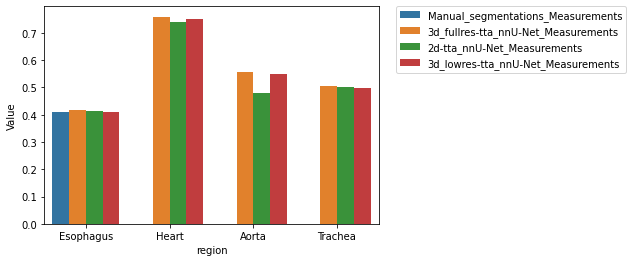

In [ ]:
sns.barplot(data=radiomics_single_series_df, x="region", y="Value", hue="SeriesDescription")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

### (paper figure #6) NSCLC Radiomics - Extract a single feature for all subjects and a single region

We also demonstrate how to extract a single feature for all subjects for a single region. We then plot the distributions of the features for the manual segmentations and the three nnU-Net predicted models. We link the OHIF viewer to further investigate any possible outliers.

In [ ]:
# Query to get a single feature for all series for a single region

client = bigquery.Client(project=project_name)
table_id = ".".join(['bigquery-public-data', 'idc_current', 'quantitative_measurements']) 
print(table_id)

region = "Heart"

query = f"""
WITH features AS (

  SELECT 
    sourceSegmentedSeriesUID, 
    SOPInstanceUID, 
    SeriesDescription, 
    Value  
  FROM 
    `bigquery-public-data.idc_current.quantitative_measurements` 
  WHERE
    Quantity[OFFSET(0)].CodeMeaning = "Sphericity" AND 
    findingSite.CodeMeaning = @region
)

SELECT 
  DISTINCT(features.sourceSegmentedSeriesUID), 
  features.SOPInstanceUID, 
  dicom_all.StudyInstanceUID, 
  dicom_all.PatientID, 
  features.SeriesDescription, 
  features.Value,
  # CONCAT("https://viewer.imaging.datacommons.cancer.gov/viewer/",dicom_all.StudyInstanceUID,"?seriesInstanceUID=",features.sourceSegmentedSeriesUID) as viewer_url 
  CONCAT("https://viewer.imaging.datacommons.cancer.gov/viewer/",dicom_all.StudyInstanceUID) as viewer_url 

FROM 
  features
LEFT JOIN 
  `bigquery-public-data.idc_current.dicom_all` as dicom_all 
ON 
  features.sourceSegmentedSeriesUID = dicom_all.SeriesInstanceUID 
WHERE
  dicom_all.collection_id = "nsclc_radiomics" 
ORDER BY 
  dicom_all.PatientID, 
  features.sourceSegmentedSeriesUID 
""" 

job_config = bigquery.QueryJobConfig(query_parameters=[
                                                       bigquery.ScalarQueryParameter("region", "STRING", region)
                                                       ])
radiomics_df = client.query(query, job_config=job_config).to_dataframe()


bigquery-public-data.idc_current.quantitative_measurements


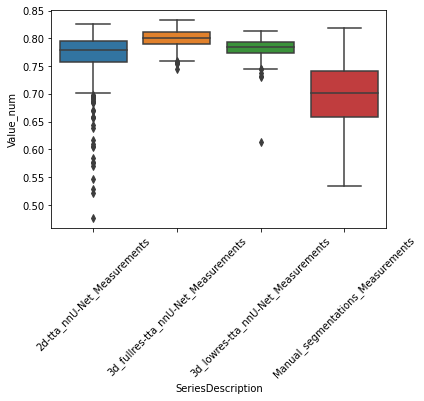

In [ ]:
# Plot the distributions of the features for the manual + 3 predicted models 

radiomics_df["Value_num"] = [np.float16(f) for f in radiomics_df["Value"]]
ax = sns.boxplot(data=radiomics_df, x="SeriesDescription", y="Value_num")
ax.tick_params(axis='x', rotation=45)

In [ ]:
# https://docs.bokeh.org/en/latest/docs/user_guide/categorical.html
# http://jaredmmoore.com/bokeh-boxplot-color-by-factor-and-legend-outside-plot/
# https://github.com/jaredmoore/Bokeh_Plot_Examples/blob/master/Bokeh%2012.10%20Boxplot%20AutoGroup.ipynb

from bokeh.models import ColumnDataSource, OpenURL, TapTool
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook
from bokeh.colors import RGB
from bokeh.transform import jitter

from bokeh.models import HoverTool, PanTool, WheelZoomTool, BoxZoomTool, ResetTool, TapTool
from bokeh.models import Legend, LegendItem

from bokeh.palettes import brewer

from bokeh.layouts import row


In [ ]:
def color_list_generator(df, treatment_col):
    """ Create a list of colors per treatment given a dataframe and 
        column representing the treatments.
        
        Args:
            df - dataframe to get data from
            treatment_col - column to use to get unique treatments.
                
        Inspired by creating colors for each treatment 
        Rough Source: http://bokeh.pydata.org/en/latest/docs/gallery/brewer.html#gallery-brewer
        Fine Tune Source: http://bokeh.pydata.org/en/latest/docs/gallery/iris.html
    """
    # Get the number of colors we'll need for the plot.
    # colors = brewer["Dark2"][len(df[treatment_col].unique())] # was Spectral

    print('check this value: ' + str(len(df[treatment_col].unique())))

    if (len(df[treatment_col].unique()))==1:
      # value = len(df[treatment_col].unique()[0])
      # print('value: ' + str(value))
      colors = brewer["Dark2"][3][0:1] # Spectral, Dark2
    elif (len(df[treatment_col].unique()))==2: 
      colors = brewer["Dark2"][3][0:2]
    elif (len(df[treatment_col].unique()))>8: 
      num_colors = len(df[treatment_col].unique())
      num_colormaps = np.int32(np.ceil(num_colors/8))
      colormap_chained = brewer["Dark2"][8]*num_colormaps 
      colors = colormap_chained[0:num_colors]
    else: 
      colors = brewer["Dark2"][len(df[treatment_col].unique())]
    print(colors)

    # Create a map between treatment and color.
    colormap = {i: colors[k] for k,i in enumerate(df[treatment_col].unique())}

    # Return a list of colors for each value that we will be looking at.
    return colormap, [colormap[x] for x in df[treatment_col]]

In [ ]:
# Link of OHIF url for the above 

# SeriesDescriptions_list = list(set(list(df_plot['SeriesDescription'].values)))
# num_SeriesDescriptions = len(SeriesDescriptions_list)
# print ('num_SeriesDescriptions: ' + str(num_SeriesDescriptions))

###########################################################
# --- Create a plot for each feature - just 1 for now --- #
###########################################################

#--- create df of the feature we want to plot ---# 

df_plot = radiomics_df
new_column = [np.float32(f) for f in df_plot['Value'].values]
df_plot['Value_numeric'] = new_column

SeriesDescriptions_list = list(set(list(df_plot['SeriesDescription'].values)))
num_SeriesDescriptions = len(SeriesDescriptions_list)
print ('num_SeriesDescriptions: ' + str(num_SeriesDescriptions))

#--- Plot using bokeh ---# 

output_notebook()

hover = HoverTool(tooltips=[
  (''.join(["(",'Sphericity',")"]), "($y)")
])

wZoom = WheelZoomTool()
bZoom = BoxZoomTool()
reset = ResetTool()
tap = TapTool()
pan = PanTool()

# Get a color for each region 
colormap, colors = color_list_generator(df_plot, 'SeriesDescription')
df_plot['colors'] = colors
colormap_list_keys = list(colormap.keys())
print('colormap: ' + str(colormap))
print('colormap_list_keys: ' + str(colormap_list_keys))
SeriesDescriptions = colormap_list_keys 
print('SeriesDescriptions: ' + str(SeriesDescriptions))

# cats = df_plot.measurementGroup_number_region.unique()
cats = df_plot.SeriesDescription.unique()
print('cats: ' + str(cats))

colors = list(colormap.values())
print('colors: ' + str(colors))

p = figure(tools = [hover, wZoom, bZoom, reset, tap, pan],
          # x_range=cats,
            x_range=SeriesDescriptions,
          title='Sphericity')

p.circle(y='Value_numeric', x=jitter('SeriesDescription', width=0.6, range=p.x_range), source=df_plot, alpha=1, color='colors')


### Include the box plots ### 
# find the quartiles and IQR for each category
# groups = df_plot.groupby('regions')
# groups = df_plot.groupby('measurementGroup_number_str')
# groups = df_plot.groupby('measurementGroup_number_str')

# regions are in order we want 
category_SeriesDescription = pd.api.types.CategoricalDtype(categories=SeriesDescriptions, ordered=True)
df_plot['SeriesDescription'] = df_plot['SeriesDescription'].astype(category_SeriesDescription)

groups = df_plot.groupby('SeriesDescription')
q1 = groups.quantile(q=0.25)
q2 = groups.quantile(q=0.5)
q3 = groups.quantile(q=0.75)
iqr = q3 - q1
upper = q3 + 1.5*iqr
lower = q1 - 1.5*iqr

# Form the source data to call vbar for upper and lower
# boxes to be formed later.
upper_source = ColumnDataSource(data=dict(
    x=cats,
    bottom=q2.Value_numeric,
    top=q3.Value_numeric, 
    fill_color=colors,
    legend=cats
))

lower_source = ColumnDataSource(data=dict(
    x=cats,
    bottom=q1.Value_numeric, 
    top=q2.Value_numeric,
    fill_color=colors
))


# p = figure(tools="save", title="", x_range=df_plot.regions.unique())

# stems (Don't need colors of treatment)
p.segment(cats, upper.Value_numeric, cats, q3.Value_numeric, line_color="black")
p.segment(cats, lower.Value_numeric, cats, q1.Value_numeric, line_color="black")

# Add the upper and lower quartiles
l=p.vbar(source = upper_source, x='x', width=0.7, bottom='bottom', top='top', fill_color='fill_color', line_color="black")
p.vbar(source = lower_source, x='x', width=0.7, bottom='bottom', top='top', fill_color='fill_color', line_color="black")

# whiskers (almost-0 height rects simpler than segments)
# p.rect(cats, lower.Value_numeric, 0.2, 0.01, line_color="black")
# p.rect(cats, upper.Value_numeric, 0.2, 0.01, line_color="black")
p.rect(cats, lower.Value_numeric, 0.2, 0.0001, line_color="black")
p.rect(cats, upper.Value_numeric, 0.2, 0.0001, line_color="black")

# Using the newer autogrouped syntax.
# Grab a renderer, in this case upper quartile and then
# create the legend explicitly.  
# Guidance from: https://groups.google.com/a/continuum.io/forum/#!msg/bokeh/uEliQlgj390/Jyhsc5HqAAAJ
legend = Legend(items=[LegendItem(label=dict(field="x"), renderers=[l])])

p.add_layout(legend, 'below')    
# p.add_layout(legend, 'right')

# Setup plot titles and such.
p.title.text = 'Sphericity'
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = "white"
p.grid.grid_line_width = 2
p.xaxis.major_label_text_font_size="0pt"
p.xaxis.major_label_orientation = np.pi/4
p.xaxis.axis_label = "nnUNet model"
p.yaxis.axis_label="Sphericity"
# p.legend.location = (100,10)



url="@viewer_url"
taptool = p.select(type=TapTool)
taptool.callback = OpenURL(url=url)

show(p)

num_SeriesDescriptions: 4
check this value: 4
('#1b9e77', '#d95f02', '#7570b3', '#e7298a')
colormap: {'2d-tta_nnU-Net_Measurements': '#1b9e77', '3d_fullres-tta_nnU-Net_Measurements': '#d95f02', '3d_lowres-tta_nnU-Net_Measurements': '#7570b3', 'Manual_segmentations_Measurements': '#e7298a'}
colormap_list_keys: ['2d-tta_nnU-Net_Measurements', '3d_fullres-tta_nnU-Net_Measurements', '3d_lowres-tta_nnU-Net_Measurements', 'Manual_segmentations_Measurements']
SeriesDescriptions: ['2d-tta_nnU-Net_Measurements', '3d_fullres-tta_nnU-Net_Measurements', '3d_lowres-tta_nnU-Net_Measurements', 'Manual_segmentations_Measurements']
cats: ['2d-tta_nnU-Net_Measurements' '3d_fullres-tta_nnU-Net_Measurements'
 '3d_lowres-tta_nnU-Net_Measurements' 'Manual_segmentations_Measurements']
colors: ['#1b9e77', '#d95f02', '#7570b3', '#e7298a']


Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.


### **(paper figure #7)** NLST - Extract a single feature for all subjects and a single region

For the NLST collection, as we do not have expert segmentations, we can plot a single feature across all four regions. Here we pick the Sphericity feature and plot the values across all series. 

Let's first query to get the dataframe we need for plotting. This is the same query as before, but with a different collection_id. 

In [76]:
# Query to get a single feature for all series for a single region

client = bigquery.Client(project=project_name)
table_id = ".".join(['bigquery-public-data', 'idc_current', 'quantitative_measurements']) 
print(table_id)

query = f"""
WITH features AS (

  SELECT 
    sourceSegmentedSeriesUID, 
    SOPInstanceUID, 
    SeriesDescription, 
    findingSite.CodeMeaning as region, 
    Value  
  FROM 
    `bigquery-public-data.idc_current.quantitative_measurements` 
  WHERE
    Quantity[OFFSET(0)].CodeMeaning = "Sphericity"
)

SELECT 
  DISTINCT(features.sourceSegmentedSeriesUID), 
  features.SOPInstanceUID, 
  dicom_all.StudyInstanceUID, 
  dicom_all.PatientID, 
  features.SeriesDescription, 
  features.region,
  features.Value,
  # CONCAT("https://viewer.imaging.datacommons.cancer.gov/viewer/",dicom_all.StudyInstanceUID,"?seriesInstanceUID=",features.sourceSegmentedSeriesUID) as viewer_url 
  CONCAT("https://viewer.imaging.datacommons.cancer.gov/viewer/",dicom_all.StudyInstanceUID) as viewer_url 

FROM 
  features
LEFT JOIN 
  `bigquery-public-data.idc_current.dicom_all` as dicom_all 
ON 
  features.sourceSegmentedSeriesUID = dicom_all.SeriesInstanceUID 
WHERE
  dicom_all.collection_id = "nlst" 
ORDER BY 
  dicom_all.PatientID, 
  features.sourceSegmentedSeriesUID 
""" 

job_config = bigquery.QueryJobConfig(query_parameters=[
                                                       bigquery.ScalarQueryParameter("region", "STRING", region)
                                                       ])
df_plot = client.query(query, job_config=job_config).to_dataframe()

bigquery-public-data.idc_current.quantitative_measurements


Now we use use bokeh to plot like before.

In [88]:

#--- create df of the feature we want to plot ---# 

new_column = [np.float32(f) for f in df_plot['Value'].values]
df_plot['Value_numeric'] = new_column

#### for each feature ### 

# Get a color for each region 
colormap, colors = color_list_generator(df_plot, 'region')
df_plot['colors'] = colors
colormap_list_keys = list(colormap.keys())
print('colormap: ' + str(colormap))
print('colormap_list_keys: ' + str(colormap_list_keys))
regions = colormap_list_keys 
print('regions: ' + str(regions))

colors = list(colormap.values())
print('colors: ' + str(colors))

hover = HoverTool(tooltips=[
    ("(Value)", "($y)")
])

wZoom = WheelZoomTool()
bZoom = BoxZoomTool()
reset = ResetTool()
tap = TapTool()
pan = PanTool()

cats = list(df_plot.region.unique()) # had to add list to this.
print('cats: ' + str(cats))
print('regions: ' + str(regions))

# regions are in order we want 
category_region = pd.api.types.CategoricalDtype(categories=regions, ordered=True)
df_plot['region'] = df_plot['region'].astype(category_region)

p = figure(tools = [hover, wZoom, bZoom, reset, tap, pan],
          # x_range=regions,
          x_range=cats, 
          title="Shape feature value")

# p.circle(y='Value_numeric', x=jitter('regions', width=0.6, range=p.x_range), source=df_plot, alpha=1, color='colors')
p.circle(y='Value_numeric', x=jitter('region', width=0.6, range=p.x_range), source=df_plot, alpha=1, color='colors')

### Include the box plots ### 
# find the quartiles and IQR for each category

groups = df_plot.groupby('region')
q1 = groups.quantile(q=0.25)
q2 = groups.quantile(q=0.5)
q3 = groups.quantile(q=0.75)
iqr = q3 - q1
upper = q3 + 1.5*iqr
lower = q1 - 1.5*iqr

# Form the source data to call vbar for upper and lower
# boxes to be formed later.
upper_source = ColumnDataSource(data=dict(
    x=cats, 
    # x=regions,
    bottom=q2.Value_numeric,
    top=q3.Value_numeric,
    fill_color=colors,
    legend=cats
    # legend=regions
))

lower_source = ColumnDataSource(data=dict(
    x=cats, 
    # x=regions,
    bottom=q1.Value_numeric,
    top=q2.Value_numeric,
    fill_color=colors
))


# p = figure(tools="save", title="", x_range=df_plot.regions.unique())

# stems (Don't need colors of treatment)
p.segment(cats, upper.Value_numeric, cats, q3.Value_numeric, line_color="black")
p.segment(cats, lower.Value_numeric, cats, q1.Value_numeric, line_color="black")

# Add the upper and lower quartiles
l=p.vbar(source = upper_source, x='x', width=0.7, bottom='bottom', top='top', fill_color='fill_color', line_color="black")
p.vbar(source = lower_source, x='x', width=0.7, bottom='bottom', top='top', fill_color='fill_color', line_color="black")

# whiskers (almost-0 height rects simpler than segments)
p.rect(cats, lower.Value_numeric, 0.2, 0.000001, line_color="black") # was 0.01
p.rect(cats, upper.Value_numeric, 0.2, 0.000001, line_color="black")

# Using the newer autogrouped syntax.
# Grab a renderer, in this case upper quartile and then
# create the legend explicitly.  
# Guidance from: https://groups.google.com/a/continuum.io/forum/#!msg/bokeh/uEliQlgj390/Jyhsc5HqAAAJ
legend = Legend(items=[LegendItem(label=dict(field="x"), renderers=[l])])

p.add_layout(legend, 'below')   

# Setup plot titles and such.
p.title.text = "Sphericity"
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = "white"
p.grid.grid_line_width = 2
p.xaxis.major_label_text_font_size="0pt"
p.xaxis.major_label_orientation = np.pi/4
p.xaxis.axis_label="Regions"
p.yaxis.axis_label="Sphericity"
p.legend.location = (100,10)

# show(p)



########
# p.legend.visible=False 

url="@viewer_url"
taptool = p.select(type=TapTool)
taptool.callback = OpenURL(url=url)

show(p)

check this value: 4
('#1b9e77', '#d95f02', '#7570b3', '#e7298a')
colormap: {'Aorta': '#1b9e77', 'Trachea': '#d95f02', 'Esophagus': '#7570b3', 'Heart': '#e7298a'}
colormap_list_keys: ['Aorta', 'Trachea', 'Esophagus', 'Heart']
regions: ['Aorta', 'Trachea', 'Esophagus', 'Heart']
colors: ['#1b9e77', '#d95f02', '#7570b3', '#e7298a']
cats: ['Aorta', 'Trachea', 'Esophagus', 'Heart']
regions: ['Aorta', 'Trachea', 'Esophagus', 'Heart']


Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.


### Download a DICOM Structured Report for one subject

In [ ]:
radiomics_df

sourceSegmentedSeriesUID  \
0     1.3.6.1.4.1.32722.99.99.2989917765213423750108...   
1     1.3.6.1.4.1.32722.99.99.2989917765213423750108...   
2     1.3.6.1.4.1.32722.99.99.2989917765213423750108...   
3     1.3.6.1.4.1.32722.99.99.2329880015517990803358...   
4     1.3.6.1.4.1.32722.99.99.2329880015517990803358...   
...                                                 ...   
1359  1.3.6.1.4.1.32722.99.99.3051646366712319699947...   
1360  1.3.6.1.4.1.32722.99.99.2350774061601826088292...   
1361  1.3.6.1.4.1.32722.99.99.2350774061601826088292...   
1362  1.3.6.1.4.1.32722.99.99.2350774061601826088292...   
1363  1.3.6.1.4.1.32722.99.99.2350774061601826088292...   

                                         SOPInstanceUID  \
0     1.2.276.0.7230010.3.1.4.481034752.468135.16657...   
1     1.2.276.0.7230010.3.1.4.481034752.183145.16656...   
2     1.2.276.0.7230010.3.1.4.481034752.147481.16643...   
3     1.2.276.0.7230010.3.1.4.481037312.51276.167148...   
4     1.2.276.0.7230010.3.1.4.481034752.112553.16656...   
...                                                 ...   
1359  1.2.276.0.7230010.3.1.4.481034752.187281.16656...   
1360  1.2.276.0.7230010.3.1.4.481034752.115316.16656...   
1361  1.2.276.0.7230010.3.1.4.481034752.401483.16657...   
1362  1.2.276.0.7230010.3.1.4.481034752.71671.166429...   
1363  1.2.276.0.7230010.3.1.4.481037312.52493.167148...   

                                       StudyInstanceUID  PatientID  \
0     1.3.6.1.4.1.32722.99.99.2393413539117143687725...  LUNG1-001   
1     1.3.6.1.4.1.32722.99.99.2393413539117143687725...  LUNG1-001   
2     1.3.6.1.4.1.32722.99.99.2393413539117143687725...  LUNG1-001   
3     1.3.6.1.4.1.32722.99.99.2037150038059966416957...  LUNG1-002   
4     1.3.6.1.4.1.32722.99.99.2037150038059966416957...  LUNG1-002   
...                                                 ...        ...   
1359  1.3.6.1.4.1.32722.99.99.9487282134711408248112...  LUNG1-421   
1360  1.3.6.1.4.1.32722.99.99.3228297855554221494057...  LUNG1-422   
1361  1.3.6.1.4.1.32722.99.99.3228297855554221494057...  LUNG1-422   
1362  1.3.6.1.4.1.32722.99.99.3228297855554221494057...  LUNG1-422   
1363  1.3.6.1.4.1.32722.99.99.3228297855554221494057...  LUNG1-422   

                        SeriesDescription        Value  \
0             2d-tta_nnU-Net_Measurements  0.744000000   
1      3d_lowres-tta_nnU-Net_Measurements  0.788000000   
2     3d_fullres-tta_nnU-Net_Measurements  0.797000000   
3       Manual_segmentations_Measurements  0.753000000   
4      3d_lowres-tta_nnU-Net_Measurements  0.769000000   
...                                   ...          ...   
1359   3d_lowres-tta_nnU-Net_Measurements  0.800000000   
1360   3d_lowres-tta_nnU-Net_Measurements  0.766000000   
1361          2d-tta_nnU-Net_Measurements  0.771000000   
1362  3d_fullres-tta_nnU-Net_Measurements  0.788000000   
1363    Manual_segmentations_Measurements  0.673000000   

                                             viewer_url  Value_num  \
0     https://viewer.imaging.datacommons.cancer.gov/...   0.744141   
1     https://viewer.imaging.datacommons.cancer.gov/...   0.788086   
2     https://viewer.imaging.datacommons.cancer.gov/...   0.796875   
3     https://viewer.imaging.datacommons.cancer.gov/...   0.752930   
4     https://viewer.imaging.datacommons.cancer.gov/...   0.769043   
...                                                 ...        ...   
1359  https://viewer.imaging.datacommons.cancer.gov/...   0.799805   
1360  https://viewer.imaging.datacommons.cancer.gov/...   0.766113   
1361  https://viewer.imaging.datacommons.cancer.gov/...   0.770996   
1362  https://viewer.imaging.datacommons.cancer.gov/...   0.788086   
1363  https://viewer.imaging.datacommons.cancer.gov/...   0.672852   

      Value_numeric   colors  
0             0.744  #1b9e77  
1             0.788  #d95f02  
2             0.797  #7570b3  
3             0.753  #e7298a  
4             0.769  #d95f02  
...             ...      ...  
1359          0.8

In [ ]:
# Pick a single Radiomics SR from previous df 

# sourceSegmentedSeriesUID = radiomics_df['sourceSegmentedSeriesUID'].values[0] 
SOPInstanceUID = radiomics_df['SOPInstanceUID'].values[0]
SOPInstanceUID

'1.2.276.0.7230010.3.1.4.481034752.468135.1665722540.260168'

In [ ]:
# Get the gcs_url for download for the above sourceSegmentedSeriesUID 

client = bigquery.Client(project=project_name)
table_id = ".".join(['bigquery-public-data', 'idc_current', 'dicom_all'])
print(table_id)

query = f"""
  SELECT 
    SeriesDescription, 
    gcs_url
  FROM 
    {table_id}
  WHERE
    # Modality = "SR" AND 
    # collection_id = "nsclc_radiomics" AND 
    SOPInstanceUID = @SOPInstanceUID
"""

job_config = bigquery.QueryJobConfig(query_parameters=[
                                                       bigquery.ScalarQueryParameter("SOPInstanceUID", "STRING", SOPInstanceUID)
                                                       ])
sr_df = client.query(query, job_config=job_config).to_dataframe()

bigquery-public-data.idc_current.dicom_all


In [ ]:
sr_df

SeriesDescription  \
0  2d-tta_nnU-Net_Measurements   

                                             gcs_url  
0  gs://public-datasets-idc/4344dae8-58de-4f8e-8c...

In [ ]:
# Download this single SR 

# Create the text file to hold gsc_url 
gcsurl_temp = sr_df["gcs_url"]
gs_file_path = "gcs_paths.txt"
gcsurl_temp.to_csv(gs_file_path, header = False, index = False)

# Download the series 
sr_directory = "/content/sr"
if not os.path.isdir(sr_directory):
  os.mkdir(sr_directory)

# !cat manifest.txt | gsutil -m cp -I .
!cat gcs_paths.txt | gsutil -m cp -I $sr_directory

# Rename file with sr.dcm 
sr_file_temp = [os.path.join(sr_directory,f) for f in os.listdir(sr_directory) if f.endswith('.dcm')][0]
sr_file = os.path.join(sr_directory, 'sr.dcm')
print(sr_file_temp)
print(sr_file)
shutil.move(sr_file_temp, sr_file)

Copying gs://public-datasets-idc/4344dae8-58de-4f8e-8cad-c914d587f5c2.dcm...
/ [1/1 files][168.3 KiB/168.3 KiB] 100% Done                                    
Operation completed over 1 objects/168.3 KiB.                                    
/content/sr/4344dae8-58de-4f8e-8cad-c914d587f5c2.dcm
/content/sr/sr.dcm


'/content/sr/sr.dcm'

### Use highdicom to extract relevant fields from the SR

In [ ]:
# Read the regions SR 

from pathlib import Path

import highdicom as hd
from pydicom.filereader import dcmread
from pydicom.sr.codedict import codes

features_sr_df = pd.DataFrame() 

segment_names = [] 
segment_numbers = [] 

feature_name_values = [] 
feature_name_codes = [] 
feature_name_meanings = [] 

feature_unit_values = [] 
feature_unit_codes = [] 
feature_unit_meanings = [] 

values = [] 
ref_seg_sop_ids = [] 

features_sr_df = pd.DataFrame() 

# Path to SR document instance stored as PS3.10 file
print('sr_file: ' + str(sr_file))
document_file = Path(sr_file)

# Load document from file on disk
sr_dataset = dcmread(str(document_file))

containers_level1 = hd.sr.utils.find_content_items(
    dataset=sr_dataset,
    relationship_type=RelationshipTypeValues.CONTAINS,
    value_type=ValueTypeValues.CONTAINER,
    name=codes.DCM.ImagingMeasurements
)

containers_level2 = hd.sr.utils.find_content_items(
    dataset=containers_level1[0],
    relationship_type=RelationshipTypeValues.CONTAINS
)
num_segments = len(containers_level2)
print('num_segments: ' + str(num_segments))

for segment_index in range(0,num_segments): 

  print('segment_index: ' + str(segment_index))

  # For each segment in num_segments, get the segment_name, segment_number, and referencedsegmentSOPInstanceUID  
  containers_level2A = hd.sr.utils.find_content_items(
      # dataset=containers_level2[0],
      dataset=containers_level2[segment_index],
      relationship_type=RelationshipTypeValues.HAS_CONCEPT_MOD,
      value_type=ValueTypeValues.CODE
  )

  # segment_name = hd.sr.utils.get_coded_value(containers_level2A[0])['CodeMeaning'].value
  # segment_name = hd.sr.utils.get_coded_value(containers_level2A[0])['CodeMeaning'].value
  segment_name = hd.sr.utils.get_coded_value(containers_level2A[0])['CodeMeaning'].value
  # print('   segment_name: ' + str(segment_name))

  containers_level3A = hd.sr.utils.find_content_items(
      # dataset=containers_level2[0],
      dataset=containers_level2[segment_index],
      relationship_type=RelationshipTypeValues.CONTAINS,
      value_type=ValueTypeValues.IMAGE
  )

  segment_number = containers_level3A[0].ReferencedSOPSequence[0].ReferencedSegmentNumber
  ref_seg_sop_id = containers_level3A[0].ReferencedSOPSequence[0].ReferencedSOPInstanceUID
  # print('   segment_number: ' + str(segment_number))
  # print('   ref_seg_sop_id: ' + str(ref_seg_sop_id))

  ### The below works, just need to get segment info first ### 
  containers_level3 = hd.sr.utils.find_content_items(
      # dataset=containers_level2[0],
      dataset=containers_level2[segment_index],
      relationship_type=RelationshipTypeValues.CONTAINS,
      value_type=ValueTypeValues.NUM
  )
  num_features = len(containers_level3)
  # print('   num_features: ' + str(num_features))

  for feature_index in range(0,num_features):

    feature_name_value = hd.sr.utils.get_coded_name(containers_level3[feature_index])['CodeValue'].value
    feature_name_code = hd.sr.utils.get_coded_name(containers_level3[feature_index])['CodingSchemeDesignator'].value
    feature_name_meaning = hd.sr.utils.get_coded_name(containers_level3[feature_index])['CodeMeaning'].value
    # print('      feature_name_value: ' + str(feature_name_value) + ' feature_name_code: ' + str(feature_name_code) + 'feature_name_meaning: ' + str(feature_name_meaning))

    feature_unit_value = containers_level3[feature_index].MeasuredValueSequence[0].MeasurementUnitsCodeSequence[0]['CodeValue'].value
    feature_unit_code = containers_level3[feature_index].MeasuredValueSequence[0].MeasurementUnitsCodeSequence[0]['CodingSchemeDesignator'].value
    feature_unit_meaning = containers_level3[feature_index].MeasuredValueSequence[0].MeasurementUnitsCodeSequence[0]['CodeMeaning'].value
    # print('      feature_unit_value: ' + str(feature_unit_value) + ' feature_unit_code: ' + str(feature_unit_code) + 'feature_unit_meaning: ' + str(feature_unit_meaning))

    value = containers_level3[feature_index].MeasuredValueSequence[0].NumericValue
    # print('      value: ' + str(value))

    # Append for all 
    segment_numbers.append(segment_number)
    segment_names.append(segment_name)
    feature_name_values.append(feature_name_value)
    feature_name_codes.append(feature_name_code) 
    feature_name_meanings.append(feature_name_meaning)
    feature_unit_values.append(feature_unit_value) 
    feature_unit_codes.append(feature_unit_code)
    feature_unit_meanings.append(feature_unit_meaning)
    values.append(value)
    ref_seg_sop_ids.append(ref_seg_sop_id)



# Form dataframe 

features_sr_df['segment_number'] = segment_numbers 
features_sr_df['segment_name'] = segment_name

features_sr_df['feature_name_value'] = feature_name_values 
features_sr_df['feature_name_code'] = feature_name_codes 
features_sr_df['feature_name_meaning'] = feature_name_meanings

features_sr_df['feature_unit_value'] = feature_unit_values 
features_sr_df['feature_unit_code'] = feature_unit_codes
features_sr_df['features_unit_meaning'] = feature_unit_meanings 

features_sr_df['value'] = values 

features_sr_df['ref_sop_id'] = ref_seg_sop_ids 

features_sr_df 

sr_file: /content/sr/sr.dcm
num_segments: 4
segment_index: 0
segment_index: 1
segment_index: 2
segment_index: 3


segment_number segment_name feature_name_value feature_name_code  \
0                1        Aorta               Q3CK              IBSI   
1                1        Aorta               N17B              IBSI   
2                1        Aorta               7J51              IBSI   
3                1        Aorta               TDIC              IBSI   
4                1        Aorta               L0JK              IBSI   
5                1        Aorta               RNU0              IBSI   
6                1        Aorta               P9VJ              IBSI   
7                1        Aorta               QCFX              IBSI   
8                1        Aorta               C0JK              IBSI   
9                1        Aorta               2PR5              IBSI   
10               1        Aorta               YEKZ              IBSI   
11               1        Aorta               SKGS              IBSI   
12               1        Aorta               BQWJ              IBSI   
13               1        Aorta               KRCK              IBSI   
14               2        Aorta               Q3CK              IBSI   
15               2        Aorta               N17B              IBSI   
16               2        Aorta               7J51              IBSI   
17               2        Aorta               TDIC              IBSI   
18               2        Aorta               L0JK              IBSI   
19               2        Aorta               RNU0              IBSI   
20               2        Aorta               P9VJ              IBSI   
21               2        Aorta               QCFX              IBSI   
22               2        Aorta               C0JK              IBSI   
23               2        Aorta               2PR5              IBSI   
24               2        Aorta               YEKZ              IBSI   
25               2        Aorta               SKGS              IBSI   
26               2        Aorta               BQWJ              IBSI   
27               2        Aorta               KRCK              IBSI   
28               3        Aorta               Q3CK              IBSI   
29               3        Aorta               N17B              IBSI   
30               3        Aorta               7J51              IBSI   
31               3        Aorta               TDIC              IBSI   
32               3        Aorta               L0JK              IBSI   
33               3        Aorta               RNU0              IBSI   
34               3        Aorta               P9VJ              IBSI   
35               3        Aorta               QCFX              IBSI   
36               3        Aorta               C0JK              IBSI   
37               3        Aorta               2PR5              IBSI   
38               3        Aorta               YEKZ              IBSI   
39               3        Aorta               SKGS              IBSI   
40               3        Aorta               BQWJ              IBSI   
41               3        Aorta               KRCK              IBSI   
42               4        Aorta               Q3CK              IBSI   
43               4        Aorta               N17B              IBSI   
44               4        Aorta               7J51              IBSI   
45               4        Aorta               TDIC              IBSI   
46               4        Aorta               L0JK              IBSI   
47               4        Aorta               RNU0              IBSI   
48               4        Aorta               P9VJ              IBSI   
49               4        Aorta               QCFX              IBSI   
50               4        Aorta               C0JK              IBSI   
51               4        Aorta               2PR5              IBSI   
52               4        Aorta               YEKZ              IBSI   
53               4        Aorta               SKGS              IBSI   
54               4        Aorta             

### Use dcmqi to read the SR

In [ ]:
output_directory_sr_features_converted_dcmqi = "/content/sr_features_dcmqi"
if not os.path.isdir(output_directory_sr_features_converted_dcmqi): 
  os.mkdir(output_directory_sr_features_converted_dcmqi)
outputMetadata = os.path.join(output_directory_sr_features_converted_dcmqi, "sr_features.json")

!tid1500reader --inputDICOM $sr_file --outputMetadata $outputMetadata 

dcmqi repository URL: git@github.com:QIICR/dcmqi.git revision: 1153738 tag: v1.2.5


In [ ]:
f = open(outputMetadata) 
sr_features_json = json.load(f)
sr_features_json

{'CompletionFlag': 'COMPLETE',
 'InstanceNumber': '1',
 'Measurements': [{'Finding': {'CodeMeaning': 'Organ',
    'CodeValue': '113343008',
    'CodingSchemeDesignator': 'SCT'},
   'FindingSite': {'CodeMeaning': 'Esophagus',
    'CodeValue': '32849002',
    'CodingSchemeDesignator': 'SCT'},
   'ReferencedSegment': 1,
   'SourceSeriesForImageSegmentation': '1.3.6.1.4.1.32722.99.99.298991776521342375010861296712563382046',
   'TrackingIdentifier': 'Measurements group 1',
   'TrackingUniqueIdentifier': '1.3.6.1.4.1.43046.3.1.4.481034752.468135.1665722540.260164',
   'activitySession': '1',
   'measurementItems': [{'measurementAlgorithmIdentification': {'AlgorithmName': 'pyradiomics',
      'AlgorithmVersion': 'v3.0.1'},
     'quantity': {'CodeMeaning': 'Elongation',
      'CodeValue': 'Q3CK',
      'CodingSchemeDesignator': 'IBSI'},
     'units': {'CodeMeaning': 'millimeter',
      'CodeValue': 'mm',
      'CodingSchemeDesignator': 'UCUM'},
     'value': '0.187'},
    {'measurementAlgorit

# Body Part Prediction results analysis

## Landmarks analysis

### **(paper figure #3)** NSCLC-Radiomics - Query and extract values from the landmarks SR and plot 

We first get a list of all the possible landmarks from the csv file. 

In [ ]:
!wget -N https://raw.githubusercontent.com/ImagingDataCommons/ai_medima_misc/main/bpr/data/bpr_landmarks_code_mapping.csv
landmarks_df = pd.read_csv("bpr_landmarks_code_mapping.csv")

--2023-03-16 18:46:00--  https://raw.githubusercontent.com/ImagingDataCommons/ai_medima_misc/main/bpr/data/bpr_landmarks_code_mapping.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1797 (1.8K) [text/plain]
Saving to: ‘bpr_landmarks_code_mapping.csv’

bpr_landmarks_code_ 100%[===================>]   1.75K  --.-KB/s    in 0s      

Last-modified header missing -- time-stamps turned off.
2023-03-16 18:46:00 (21.7 MB/s) - ‘bpr_landmarks_code_mapping.csv’ saved [1797/1797]



We then need to download the public BPR model from Zenodo and get the inference-settings.json file as we need the ordering of the landmarks from inferior to superior. 

In [ ]:
bpr_model_url = "https://zenodo.org/record/5113483/files/public_bpr_model.zip"
model_download_path = "/content/models/bpr_model.zip"
if not os.path.isdir("/content/models"):
  os.mkdir("/content/models")

!wget -O $model_download_path $bpr_model_url 

model_extract_path = "/content/models/bpr_model"
!unzip $model_download_path -d $model_extract_path

--2023-03-16 15:37:49--  https://zenodo.org/record/5113483/files/public_bpr_model.zip
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 55645041 (53M) [application/octet-stream]
Saving to: ‘/content/models/bpr_model.zip’

/content/models/bpr 100%[===================>]  53.07M  1.05MB/s    in 61s     

2023-03-16 15:38:52 (889 KB/s) - ‘/content/models/bpr_model.zip’ saved [55645041/55645041]

Archive:  /content/models/bpr_model.zip
   creating: /content/models/bpr_model/public_bpr_model/
  inflating: /content/models/bpr_model/public_bpr_model/reference.xlsx  
  inflating: /content/models/bpr_model/public_bpr_model/inference-settings.json  
  inflating: /content/models/bpr_model/public_bpr_model/model.pt  
  inflating: /content/models/bpr_model/public_bpr_model/config.json  


Let's get the data from the inference-settings.json file. 

In [ ]:
inference_settings_file = "/content/models/bpr_model/public_bpr_model/inference-settings.json" 
with open(inference_settings_file) as f: 
  inference_settings_json = json.load(f)

landmarks_inference = inference_settings_json['lookuptable_train_val']['transformed']

# create new dictionary with ordered landmarks 
landmarks_inference_sorted = dict(sorted(landmarks_inference.items(), key=lambda item: item[1]['mean'])) 

In [ ]:
# Create a dataframe with the landmarks_inference_sorted 

landmarks_inference_sorted_df = pd.DataFrame() 
landmarks_inference_sorted_df['landmark'] = landmarks_inference_sorted.keys() 
landmarks_inference_sorted_df['mean'] = [landmarks_inference_sorted[f]['mean'] for f in landmarks_inference_sorted.keys()]
landmarks_inference_sorted_df['std'] = [landmarks_inference_sorted[f]['std'] for f in landmarks_inference_sorted.keys()]

# To this dataframe we add the corresponding fields from landmarks_df, in the correct order
num_codes = len(landmarks_inference_sorted_df)
landmark_CodeMeanings = [] 
modifier_CodeMeanings = [] 

# for each 
for n in range(0,num_codes): 
  bpr_code = landmarks_inference_sorted_df['landmark'].values[n]
  landmark_CodeMeaning = landmarks_df[landmarks_df['BPR_code']==bpr_code]['CodeMeaning'].values[0]
  modifier_CodeMeaning = landmarks_df[landmarks_df['BPR_code']==bpr_code]['modifier_CodeMeaning'].values[0]
  landmark_CodeMeanings.append(landmark_CodeMeaning)
  modifier_CodeMeanings.append(modifier_CodeMeaning)

landmarks_inference_sorted_df['landmark_CodeMeaning'] = landmark_CodeMeanings 
landmarks_inference_sorted_df['modifier_CodeMeaning'] = modifier_CodeMeanings 
landmarks_inference_sorted_df['landmark_and_modifier_name'] = [f + ' ' + g for f,g in zip(landmark_CodeMeanings,modifier_CodeMeanings)]

In [ ]:
landmarks_inference_sorted_df

landmark     mean    std                   landmark_CodeMeaning  \
0   pelvis_start    0.000  1.983                                 Pelvis   
1      femur_end   13.616  1.198                                  Femur   
2             L5   25.532  1.854                            L5 vertebra   
3     pelvis_end   28.824  1.881                                 Pelvis   
4             L4   29.414  2.098                            L4 vertebra   
5             L3   33.817  2.290                            L3 vertebra   
6         kidney   37.597  4.116                                 Kidney   
7             L2   37.763  2.335                            L2 vertebra   
8             L1   41.478  2.276                            L1 vertebra   
9     lung_start   44.143  4.385                                   Lung   
10          Th12   44.952  2.287                           T12 vertebra   
11          Th11   47.725  2.503                           T11 vertebra   
12          Th10   51.069  2.717                           T10 vertebra   
13           Th9   53.994  2.613                            T9 vertebra   
14     liver_end   54.479  3.986                                  Liver   
15           Th8   56.856  2.360                            T8 vertebra   
16           Th7   59.851  2.822                            T7 vertebra   
17           Th6   63.177  2.404                            T6 vertebra   
18           Th5   65.964  2.118                            T5 vertebra   
19           Th4   68.499  2.051                            T4 vertebra   
20           Th3   70.973  2.038                            T3 vertebra   
21           Th2   73.401  1.694                            T2 vertebra   
22      lung_end   75.389  1.478                                   Lung   
23           Th1   75.794  1.811                            T1 vertebra   
24            C7   77.937  1.849                            C7 vertebra   
25            C6   79.497  1.637                            C6 vertebra   
26            C5   81.826  1.527                            C5 vertebra   
27            C4   83.817  1.378                            C4 vertebra   
28            C3   85.647  1.472                            C3 vertebra   
29         teeth   86.908  3.253  Teeth, gums and supporting structures   
30            C2   87.206  1.327                            C2 vertebra   
31            C1   89.234  1.397                            C1 vertebra   
32          nose   92.567  5.355                                   Nose   
33      eyes_end  100.000  3.789                                    Eye   
34      head_end  107.756  1.785                                   Head   

   modifier_CodeMeaning                    landmark_and_modifier_name  
0                Bottom                                 Pelvis Bottom  
1                   Top                                     Femur Top  
2                Center                            L5 vertebra Center  
3                   Top                                    Pelvis Top  
4                Center                            L4 vertebra Center  
5                Center                            L3 vertebra Center  
6                Bottom                                 Kidney Bottom  
7                Center                            L2 vertebra Center  
8                Center                            L1 vertebra Center  
9                Bottom                                   Lung Bottom  
10               Center                           T12 vertebra Center  
11               Center                           T11 vertebra Center  
12               Center                           T10 vertebra Center  
13               Center                            T9 vertebra Center  
14                  Top                                     Liver Top  
15               Center                            T8 vertebra Center  
16               Center                            T7 vertebra Center  
17         

We then query to get the landmarks for NSCLC-Radiomics. 

In [89]:
client = bigquery.Client(project=project_name)
table_id = ".".join(['bigquery-public-data', 'idc_current', 'dicom_all']) 

print(table_id)

query = f"""
--creating a temporary table that is flatenned on most columns using left joins and 
--unnesting upto three levels starting with zeroth level
--the temporary table could be very helpful to visualize.
--Once the table is flattened,
--sub tables are created, one for each attribute of interest.
--then they are joined on measurement group numbers and sop instance uid.

-- Start by creating a temporary table called 'temp'
with temp as (
  -- In the SELECT statement, we're choosing which columns to include in the temporary table
  SELECT
  SOPInstanceUID, 
  bid.SeriesInstanceUID, 
  measurementGroup_number, -- Number assigned to a measurement group
  cs_l2.UID, -- Unique identifier for the content sequence at level 2
  cs_l2.TextValue, -- Text value associated with the content sequence at level 2
  collection_id, # I added 
  PatientID, 
  SeriesDescription, 
  SOPClassUID,
  cts_l0.MappingResource, -- Resource used to map the content template sequence at level 0
  cts_l0.TemplateIdentifier, -- Unique identifier for the content template sequence at level 0
  cs_l0.ValueType, -- Type of value associated with the content sequence at level 0
  cs_l1_cncs.CodeMeaning, -- Code meaning associated with the concept name coding sequence at level 1
  cs_l2.ValueType, -- Type of value associated with the content sequence at level 2
  cs_l2_cncs.CodeValue, -- Code value associated with the concept name coding sequence at level 2
  cs_l2_cncs.CodingSchemeDesignator, -- Coding scheme designator associated with the concept name coding sequence at level 2
  cs_l2_cncs.CodeMeaning as cm2, -- Code meaning associated with the concept name coding sequence at level 2, with an alias of 'cm2'
  cs_l2_rss.ReferencedSOPClassUID, -- Unique identifier for the referenced SOP class
  cs_l2_rss.ReferencedSOPInstanceUID, -- Unique identifier for the referenced SOP instance
  cs_l2_rss.ReferencedSegmentNumber, -- Number assigned to a referenced segment
  cs_l2_css, -- concept Code sequence associated with the content sequence at level 2
  cs_l1, -- Content sequence at level 1
  cs_l2, 
  crpes_rss.SeriesInstanceUID as crpes_ref, 
  cs_l2_cncs,
  cs_l3.ValueType vt3, -- Type of value associated with the content sequence at level 3
  cs_l3_cncs.CodeValue cv3,  -- Code value associated with the concept name coding sequence at level 3
  cs_l3_cncs.CodingSchemeDesignator,  -- Coding scheme designator associated with the concept name coding sequence at level 3
  cs_l3_cncs.CodeMeaning as cm3, -- Code meaning associated with the concept name coding sequence at level 3, with an alias of 'cm3'
  cs_l3_css, -- concept Code sequence associated with the content sequence at level 3

  FROM
  `bigquery-public-data.idc_current.dicom_all` bid -- Data source
  --bigquery-public-data.idc_current.dicom_metadata bid -- Data source
  -- Left join zeroth level of ContentTemplateSequence
  LEFT JOIN
  UNNEST(bid.ContentTemplateSequence) cts_l0
  -- Left join zeroth level of ContentSequence
  LEFT JOIN
  UNNEST(bid.ContentSequence) cs_l0
  -- *generate from chatgpt* 
  LEFT JOIN
  UNNEST(bid.CurrentRequestedProcedureEvidenceSequence) crpes
  -- *generate from chatgpt* 
  LEFT JOIN 
  UNNEST(crpes.ReferencedSeriesSequence) crpes_rss
  -- Unnest content sequence at level 1, with an offset assigned to measurementGroup_number
  LEFT JOIN
  unnest(cs_l0.ContentSequence) cs_l1
  WITH
  OFFSET
  AS measurementGroup_number
  -- Left join ConceptNameCodeSequence at level 1
  LEFT JOIN
  unnest(cs_l1.ConceptNameCodeSequence) cs_l1_cncs
  -- Unnest content sequence at level 2
  LEFT JOIN
  unnest(cs_l1.ContentSequence) cs_l2
  -- Left join ConceptNameCodeSequence at level 2
  LEFT JOIN
  unnest(cs_l2.ConceptNameCodeSequence) cs_l2_cncs
  -- Left join ReferencedSOPSequence at level 2
  LEFT JOIN
  unnest(cs_l2.ReferencedSOPSequence) cs_l2_rss
  -- Left join ConceptCodeSequence at level 2
  LEFT JOIN
  unnest(cs_l2.ConceptCodeSequence) cs_l2_css
  -- Unnest content sequence at level 3
  LEFT JOIN
  unnest(cs_l2.ContentSequence) cs_l3
  -- Left join ConceptNameCodeSequence at level 3
  LEFT JOIN
  unnest(cs_l3.ConceptNameCodeSequence) cs_l3_cncs
  -- Left join ConceptCodeSequence at level 2
  LEFT JOIN
  unnest(cs_l3.ConceptCodeSequence) cs_l3_css
  
  WHERE
  --SeriesDescription not in ("BPR landmark annotations", "BPR region annotations") and
  --PatientID in ('LUNG1-002') AND
  -- We only want to include records where the TemplateIdentifier is 1500 and MappingResource is DCMR
  TemplateIdentifier IN ('1500')
  AND MappingResource IN ('DCMR')

  -- We only want to include CONTAINER value types in the first level of content sequence
  AND cs_l0.ValueType IN ('CONTAINER')

  -- We only want to include Measurement Group Code Meanings in the second level of content sequence
  AND cs_l1_cncs.CodeMeaning IN ("Measurement Group")

  -- We want to include certain value types and code values in the third level of content sequence
  AND (
    -- Tracking Identifier-- TEXT value type with specific Code Value and Coding Scheme Designator
    (cs_l2.ValueType IN ('TEXT') AND cs_l2_cncs.CodeValue IN ('112039')AND cs_l2_cncs.CodingSchemeDesignator IN ('DCM')) 
    -- Tracking Unique Identifier--UIDREF value type with specific Code Value and Coding Scheme Designator
    OR (cs_l2.ValueType IN ('UIDREF') AND cs_l2_cncs.CodeValue IN ('112040')AND cs_l2_cncs.CodingSchemeDesignator IN ('DCM'))  
    -- Referenced Segment or Source--IMAGE value type with specific Referenced SOP Class UID
    OR (cs_l2.ValueType IN ('IMAGE') AND  cs_l2_rss.ReferencedSOPClassUID IN ("1.2.840.10008.5.1.4.1.1.66.4","1.2.840.10008.5.1.4.1.1.2"))--allowing one more class for 'Source'
    -- Source series for segmentation--UIDREF value type with specific Code Value and Coding Scheme Designator
    OR (cs_l2.ValueType IN ('UIDREF') AND cs_l2_cncs.CodeValue IN ('121232')AND cs_l2_cncs.CodingSchemeDesignator IN ('DCM')) 
    -- Finding--CODE value type with specific Code Value and Coding Scheme Designator
    OR (cs_l2.ValueType IN ('CODE') AND cs_l2_cncs.CodeValue IN ('121071')AND cs_l2_cncs.CodingSchemeDesignator IN ('DCM')) 
    -- Finding Site--CODE value type with specific Code Value and Coding Scheme Designator
    OR (cs_l2.ValueType IN ('CODE') AND cs_l2_cncs.CodeValue IN ('G-C0E3')AND cs_l2_cncs.CodingSchemeDesignator IN ('SRT'))
    -- Finding Site--CODE value type with specific Code Value and Coding Scheme Designator
    OR (cs_l2.ValueType IN ('CODE') AND cs_l2_cncs.CodeValue IN ('363698007')AND cs_l2_cncs.CodingSchemeDesignator IN ('SCT'))  
  )
  -- We only want to include certain SOP Class UIDs
  AND SOPClassUID IN ("1.2.840.10008.5.1.4.1.1.88.11", "1.2.840.10008.5.1.4.1.1.88.22", "1.2.840.10008.5.1.4.1.1.88.33","1.2.840.10008.5.1.4.1.1.88.34","1.2.840.10008.5.1.4.1.1.88.35") 
--and PatientID in ('LUNG1-002')
  -- We could activate the below line for testing
  -- AND SOPInstanceUID in ('1.2.276.0.7230010.3.1.4.0.11647.1553294587.292373'
),
finding as (SELECT * from temp where cm2 ='Finding'),
findingsite as (SELECT * from temp where cm2 ='Finding Site'),
ReferencedSegment as (SELECT * from temp where cm2 ='Referenced Segment'),
SourceSeriesforsegmentation as (SELECT * from temp where cm2 ='Source series for segmentation'),
TrackingIdentifier as (SELECT * from temp where cm2 ='Tracking Identifier'),
TrackingUniqueIdentifier as  (SELECT * from temp where cm2 ='Tracking Unique Identifier'),
SourceInstance as  (SELECT * from temp where cm2 ='Source')

Select
TrackingIdentifier.SOPInstanceUID, 
TrackingIdentifier.SeriesInstanceUID,
TrackingIdentifier.measurementGroup_number,
TrackingUniqueIdentifier.UID as trackingUniqueIdentifier,
TrackingIdentifier.TextValue as trackingIdentifier,
TrackingIdentifier.PatientID,
TrackingIdentifier.collection_id, 
--TrackingIdentifier.SeriesDescription,  --different from measurement groups query
SourceSeriesforsegmentation.UID as sourceSegmentedSeriesUID,
SourceInstance.ReferencedSOPInstanceUID as sourceReferencedSOPInstanceUID,--newly introduced column compared to previous qualitative query
ReferencedSegment.ReferencedSOPInstanceUID as segmentationInstanceUID,
ReferencedSegment.ReferencedSegmentNumber as segmentationSegmentNumber,
findingsite.cs_l2_cncs as Quantity, --different from measurements groups query
findingsite.cs_l2_css as Value,--different from measurements groups query
finding.cs_l2_css as finding,
findingsite.cs_l2_css as findingSite,
findingsite.cs_l3_css as findingSite_topographicalModifier, --newly introduced array compared to previous qualitative query
TrackingIdentifier.crpes_ref
# TrackingUniqueIdentifier.crpes_ref   

--TrackingIdentifier.cs_l1 as contentSequence --different from measurements groups query

from TrackingIdentifier
join TrackingUniqueIdentifier using (SOPInstanceUID, measurementGroup_number)
left join finding using (SOPInstanceUID, measurementGroup_number)
left join findingsite using (SOPInstanceUID, measurementGroup_number)
left join ReferencedSegment using (SOPInstanceUID, measurementGroup_number)
left join SourceSeriesforsegmentation using (SOPInstanceUID, measurementGroup_number)
left join SourceInstance using (SOPInstanceUID, measurementGroup_number)

-- left JOIN 
--   `bigquery-public-data.idc_current.dicom_all` as dicom_all 
-- ON 
--   SourceInstance.ReferencedSOPInstanceUID = dicom_all.SOPInstanceUID 

--the bottom line are different from measurement groups query
where findingsite.cs_l2.ValueType in ('CODE') and findingsite.cs_l2_cncs.CodeValue not in ('121071','G-C0E3') and TrackingIdentifier.collection_id = "nsclc_radiomics"

-- ORDER BY 
--   PatientID, 
--   measurementGroup_number 
"""

job_config = bigquery.QueryJobConfig()
qual_df = client.query(query, job_config=job_config).to_dataframe()

bigquery-public-data.idc_current.dicom_all


We need to form a dataframe with just the landmarks/regions. 

In [ ]:
# We need to form a data frame 

# includes landmarks and regions 
landmarks_regions_df = qual_df[qual_df['sourceSegmentedSeriesUID'].isin([None])] 

# just includes landmarks 
landmarks_series_df = landmarks_regions_df[landmarks_regions_df['trackingIdentifier'].str.contains("landmarks")]

Let's pick a single seriesInstanceUID

In [ ]:

series_ids = list(set(list(landmarks_series_df['crpes_ref'].values)))
# series_ids_keep = series_ids[0:3]
# print(series_ids_keep)
series_id = series_ids[0] 
print(series_id)

# landmarks_series_df_keep = landmarks_series_df[landmarks_series_df["crpes_ref"].isin(series_ids_keep)]
# landmarks_series_df_keep = landmarks_series_df[landmarks_series_df["crpes_ref"].isin([series_ids])]
landmarks_series_df_keep = landmarks_series_df[landmarks_series_df["crpes_ref"]==series_id]

1.3.6.1.4.1.32722.99.99.286714454369710809238330584946086450994


In order to form the overlay pictures, we need to get the original CT files. We will need to get the IPP in order to get the actual axial slice index that each landmark corresponds to. We have the referencedSOPInstanceUID. 

In [ ]:
# Get the CT series instance UID, download and convert to nifti for the 3 series 
# Get the ImagePositionPatient, ImageOrientationPatient and calculate the correct IPP for each slice. 
# Add this to the dataframe all_ct_series_df

all_ct_series_df = pd.DataFrame()

# for n in range(0,3): 

### Query to get gcs_urls ### 

# series_id = series_ids_keep[n]
client = bigquery.Client(project=project_name)
query = f"""
  SELECT 
    SeriesInstanceUID,
    SOPInstanceUID, 
    gcs_url,
    ARRAY_TO_STRING(ImagePositionPatient,"/") AS ImagePositionPatient, 
    ARRAY_TO_STRING(ImageOrientationPatient, "/") AS ImageOrientationPatient, 
    ARRAY_TO_STRING(PixelSpacing, "/") AS PixelSpacing
  FROM
    `bigquery-public-data.idc_current.dicom_all` 
  WHERE
    SeriesInstanceUID = @series_id;
  """

job_config = bigquery.QueryJobConfig(query_parameters=[
                                                      bigquery.ScalarQueryParameter("series_id", "STRING", series_id)
                                                      ])
result = client.query(query, job_config=job_config) 
series_df = result.to_dataframe(create_bqstorage_client=True)
all_ct_series_df = pd.concat([all_ct_series_df,series_df])

### Download the gcs_urls ###

# Create the text file to hold gsc_url 
gs_file_path = "gcs_paths.txt"
series_df["gcs_url"].to_csv(gs_file_path, header = False, index = False)

# Download the series 
download_path_temp = "/content/raw_temp"
if not os.path.isdir(download_path_temp):
  os.mkdir(download_path_temp)

# !cat manifest.txt | gsutil -m cp -I .
!cat gcs_paths.txt | gsutil -m cp -I $download_path_temp

### Convert to nii ### 

ct_nifti_directory_temp = "/content/ct_nii_temp" 
if not os.path.isdir(ct_nifti_directory_temp): 
  os.mkdir(ct_nifti_directory_temp)

cmd = 'dcm2niix -z y -m y -o %s  %s ' % (ct_nifti_directory_temp, download_path_temp)
print(cmd)
ret = os.system(cmd)
print(ret)

# Rename file 

nii_file_orig = [os.path.join(ct_nifti_directory_temp,f) for f in os.listdir(ct_nifti_directory_temp) if f.endswith('.nii.gz')][0] 
nii_file = os.path.join("/content/ct_qualitative", series_id + ".nii.gz")
if not os.path.isdir("/content/ct_qualitative"):
  os.mkdir("/content/ct_qualitative")
os.rename(nii_file_orig, nii_file)

### Delete from folders ### 
!rm -rf "/content/raw_temp"
!rm -rf "/content/ct_nii_temp" 



### Now add a column with the calculated IPP ### 

num_sop = len(all_ct_series_df)
SOPInstanceUIDs = list(all_ct_series_df['SOPInstanceUID'].values) 

pos_all = [] 

for n in range(0,num_sop): 
  
  sop_id = SOPInstanceUIDs[n] 
  all_ct_series_df_temp = all_ct_series_df[all_ct_series_df['SOPInstanceUID']==sop_id]
  ImageOrientation = all_ct_series_df_temp['ImageOrientationPatient'].values[0] 
  ImageOrientation = ImageOrientation.split('/')
  ImageOrientation = [np.float32(f) for f in ImageOrientation]
  ImagePositionPatient = all_ct_series_df_temp['ImagePositionPatient'].values[0] 
  ImagePositionPatient = ImagePositionPatient.split('/')
  ImagePositionPatient = [np.float32(f) for f in ImagePositionPatient]

  # calculate z value
  x_vector = ImageOrientation[0:3]
  y_vector = ImageOrientation[3:]
  z_vector = np.cross(x_vector,y_vector)

  # multiple z_vector by ImagePositionPatient
  pos = np.dot(z_vector,ImagePositionPatient)
  pos_all.append(pos)


# all_ct_series_df_ordered = pd.DataFrame() 

# for n in range(0,3): 
# series_id = series_ids_keep[n]
# series_df = all_ct_series_df[all_ct_series_df['SeriesInstanceUID'] == series_id]
# order rows according to calculated pos 
# series_df = series_df.sort_values(by=['pos']) 
# add an index value to the dataframe 
# all_ct_series_df_ordered = pd.concat([all_ct_series_df_ordered, series_df])



Copying gs://idc-open-cr/4f238705-6208-4e0d-9c9d-bfbcea1bf5e9.dcm...
Copying gs://idc-open-cr/4d228d1d-d99e-4d91-8d54-907478c1b1d4.dcm...
Copying gs://idc-open-cr/21ad6de7-9dbb-4bde-bb23-2f569a879004.dcm...
Copying gs://idc-open-cr/1acaf5b6-b287-4b07-a4bc-587887364eb0.dcm...
Copying gs://idc-open-cr/d8f3b82a-4d2d-48f3-80d2-5fb1911e4075.dcm...
Copying gs://idc-open-cr/8e5667f4-cd88-45fc-ba83-2bf073d41cfe.dcm...
Copying gs://idc-open-cr/e2335c0d-9722-4dfa-8730-2d1e37ce72c8.dcm...
Copying gs://idc-open-cr/dcd9d3b2-0a85-4061-92ba-23c8e0305fd9.dcm...
Copying gs://idc-open-cr/1e0db447-746d-44c8-9a02-7cc5c2b40ce4.dcm...
Copying gs://idc-open-cr/dc70176e-b346-432c-8b14-bd5dcd3c9f7c.dcm...
Copying gs://idc-open-cr/7fb4a2da-1546-42f0-a24f-b80f68ce71a9.dcm...
Copying gs://idc-open-cr/7d5b71fc-de2b-487a-8115-50a1d694f1f8.dcm...
Copying gs://idc-open-cr/b0d56657-1584-490d-a546-7920817ca9fa.dcm...
Copying gs://idc-open-cr/20dabbe2-ff2e-4809-8a45-24a161627efa.dcm...
Copying gs://idc-open-cr/20a60fe2-

Reorder the rows from min and max and add the index value. 

In [ ]:
# all_ct_series_df['pos'] = pos_all 
series_df['pos'] = pos_all

### Reorder rows from min to max and put index value ### 
series_df = series_df.sort_values(by=['pos'])

series_df = series_df.sort_values(by=['pos'])
slice_index = range(0,len(series_df))
series_df['slice_index'] = slice_index 
series_df 

# all_ct_series_df_ordered = pd.DataFrame() 

# for n in range(0,3): 
# series_id = series_ids_keep[n]
# series_df = all_ct_series_df[all_ct_series_df['SeriesInstanceUID'] == series_id]
# order rows according to calculated pos 
# series_df = series_df.sort_values(by=['pos']) 
# add an index value to the dataframe 
# slice_index = range(0,len(series_df))
# series_df['slice_index'] = slice_index
# all_ct_series_df_ordered = pd.concat([all_ct_series_df_ordered, series_df])

SeriesInstanceUID  \
87   1.3.6.1.4.1.32722.99.99.2867144543697108092383...   
126  1.3.6.1.4.1.32722.99.99.2867144543697108092383...   
109  1.3.6.1.4.1.32722.99.99.2867144543697108092383...   
113  1.3.6.1.4.1.32722.99.99.2867144543697108092383...   
63   1.3.6.1.4.1.32722.99.99.2867144543697108092383...   
..                                                 ...   
111  1.3.6.1.4.1.32722.99.99.2867144543697108092383...   
108  1.3.6.1.4.1.32722.99.99.2867144543697108092383...   
81   1.3.6.1.4.1.32722.99.99.2867144543697108092383...   
57   1.3.6.1.4.1.32722.99.99.2867144543697108092383...   
24   1.3.6.1.4.1.32722.99.99.2867144543697108092383...   

                                        SOPInstanceUID  \
87   1.3.6.1.4.1.32722.99.99.3161718301880190406013...   
126  1.3.6.1.4.1.32722.99.99.2282913668506062389546...   
109  1.3.6.1.4.1.32722.99.99.2549092535801997300830...   
113  1.3.6.1.4.1.32722.99.99.6993484434803817526529...   
63   1.3.6.1.4.1.32722.99.99.1858024035499569559882...   
..                                                 ...   
111  1.3.6.1.4.1.32722.99.99.1394322418971856264150...   
108  1.3.6.1.4.1.32722.99.99.4050054187409238534890...   
81   1.3.6.1.4.1.32722.99.99.8258511880649750164641...   
57   1.3.6.1.4.1.32722.99.99.1046354343112241226007...   
24   1.3.6.1.4.1.32722.99.99.2632902983465110181622...   

                                               gcs_url  \
87   gs://idc-open-cr/7fecf333-0162-422e-a52b-80234...   
126  gs://idc-open-cr/5e78bc45-da04-4205-bee3-49f7f...   
109  gs://idc-open-cr/69fa9671-974a-4f45-94de-6810e...   
113  gs://idc-open-cr/5e73920a-b15c-47fb-b85d-d6550...   
63   gs://idc-open-cr/4129aef7-4025-42c2-b185-a1628...   
..                                                 ...   
111  gs://idc-open-cr/3c35b6bf-23ca-4ff9-a3c3-d2b12...   
108  gs://idc-open-cr/7a94860e-a6e2-44af-9740-60c67...   
81   gs://idc-open-cr/6f245fc2-49c2-453f-8bf2-3dcaa...   
57   gs://idc-open-cr/7311d266-9ac2-43ff-956f-5f7de...   
24   gs://idc-open-cr/add26131-395e-4a69-baf5-7c338...   

                   ImagePositionPatient ImageOrientationPatient  \
87   -249.51171875/-419.51171875/-747.5             1/0/0/0/1/0   
126  -249.51171875/-419.51171875/-744.5             1/0/0/0/1/0   
109  -249.51171875/-419.51171875/-741.5             1/0/0/0/1/0   
113  -249.51171875/-419.51171875/-738.5             1/0/0/0/1/0   
63   -249.51171875/-419.51171875/-735.5             1/0/0/0/1/0   
..                                  ...                     ...   
111  -249.51171875/-419.51171875/-360.5             1/0/0/0/1/0   
108  -249.51171875/-419.51171875/-357.5             1/0/0/0/1/0   
81   -249.51171875/-419.51171875/-354.5             1/0/0/0/1/0   
57   -249.51171875/-419.51171875/-351.5             1/0/0/0/1/0   
24   -249.51171875/-419.51171875/-348.5             1/0/0/0/1/0   

            PixelSpacing    pos  slice_index  
87   0.9765625/0.9765625 -747.5            0  
126  0.9765625/0.9765625 -744.5            1  
109  0.9765625/0.9765625 -741.5            2  
113  0.9765625/0.9765625 -738.5            3  
63   0.9765625/0.9765625 -735.5            4  
..                   ...    ...          ...  
111  0.9765625/0.9765625 -360.5          129  
108  0.9765625/0.9765625 -357.5          130  
81   0.9765625/0.9765625 -354.5          131  
57   0.9765625/0.9765625 -351.5          132  
24   0.9765625/0.9765625 -348.5          133  

[134 rows x 8 columns]

To the landmarks_series_df, add the index value of the actual axial slice index it corresponds to, based on the SOPInstanceUID and which one it matches to the original CT files. 

In [ ]:
num_sop = len(landmarks_series_df_keep)

# for each sourceReferencedSOPInstanceUID in the landmarks_single_series_df, get the index value in the series_df 
landmark_axial_indices = [] 
for n in range(0,num_sop): 
  sourceReferencedSOPInstanceUID = landmarks_series_df_keep['sourceReferencedSOPInstanceUID'].values[n]
  landmark_axial_index = series_df[series_df['SOPInstanceUID']==sourceReferencedSOPInstanceUID]['slice_index'].values[0]
  landmark_axial_indices.append(landmark_axial_index)

landmarks_series_df_keep['slice_index'] = landmark_axial_indices

Add the unnested names of the landmarks to the dataframe 

In [ ]:
# # Now add the three columns to landmarks_series_df
# landmarks_series_df_keep['ImagePositionPatient'] = ImagePositionPatient_all 
# landmarks_series_df_keep['ImageOrientationPatient'] = ImageOrientationPatient_all 
# landmarks_series_df_keep['pos'] = pos_all

# Add the names of the landmarks as well 
series_landmarks_site = [f['CodeMeaning'] for f in landmarks_series_df_keep['findingSite'].values]
series_landmarks_modifier = [f['CodeMeaning'] for f in landmarks_series_df_keep['findingSite_topographicalModifier'].values] 
# join these two 
series_landmarks = [f + ' ' + g for f,g in zip(series_landmarks_site,series_landmarks_modifier)]
landmarks_series_df_keep['landmark_names'] = series_landmarks
landmarks_series_df_keep


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


SOPInstanceUID  \
183708  1.2.826.0.1.3680043.8.498.28495371806652085857...   
183709  1.2.826.0.1.3680043.8.498.28495371806652085857...   
183710  1.2.826.0.1.3680043.8.498.28495371806652085857...   
183711  1.2.826.0.1.3680043.8.498.28495371806652085857...   
183712  1.2.826.0.1.3680043.8.498.28495371806652085857...   
183713  1.2.826.0.1.3680043.8.498.28495371806652085857...   
183714  1.2.826.0.1.3680043.8.498.28495371806652085857...   
183715  1.2.826.0.1.3680043.8.498.28495371806652085857...   
183716  1.2.826.0.1.3680043.8.498.28495371806652085857...   
183717  1.2.826.0.1.3680043.8.498.28495371806652085857...   
183718  1.2.826.0.1.3680043.8.498.28495371806652085857...   
183719  1.2.826.0.1.3680043.8.498.28495371806652085857...   
183720  1.2.826.0.1.3680043.8.498.28495371806652085857...   
183721  1.2.826.0.1.3680043.8.498.28495371806652085857...   
183722  1.2.826.0.1.3680043.8.498.28495371806652085857...   
183723  1.2.826.0.1.3680043.8.498.28495371806652085857...   
183724  1.2.826.0.1.3680043.8.498.28495371806652085857...   
183725  1.2.826.0.1.3680043.8.498.28495371806652085857...   
183726  1.2.826.0.1.3680043.8.498.28495371806652085857...   
183727  1.2.826.0.1.3680043.8.498.28495371806652085857...   

                                        SeriesInstanceUID  \
183708  1.2.826.0.1.3680043.8.498.71753374453839344167...   
183709  1.2.826.0.1.3680043.8.498.71753374453839344167...   
183710  1.2.826.0.1.3680043.8.498.71753374453839344167...   
183711  1.2.826.0.1.3680043.8.498.71753374453839344167...   
183712  1.2.826.0.1.3680043.8.498.71753374453839344167...   
183713  1.2.826.0.1.3680043.8.498.71753374453839344167...   
183714  1.2.826.0.1.3680043.8.498.71753374453839344167...   
183715  1.2.826.0.1.3680043.8.498.71753374453839344167...   
183716  1.2.826.0.1.3680043.8.498.71753374453839344167...   
183717  1.2.826.0.1.3680043.8.498.71753374453839344167...   
183718  1.2.826.0.1.3680043.8.498.71753374453839344167...   
183719  1.2.826.0.1.3680043.8.498.71753374453839344167...   
183720  1.2.826.0.1.3680043.8.498.71753374453839344167...   
183721  1.2.826.0.1.3680043.8.498.71753374453839344167...   
183722  1.2.826.0.1.3680043.8.498.71753374453839344167...   
183723  1.2.826.0.1.3680043.8.498.71753374453839344167...   
183724  1.2.826.0.1.3680043.8.498.71753374453839344167...   
183725  1.2.826.0.1.3680043.8.498.71753374453839344167...   
183726  1.2.826.0.1.3680043.8.498.71753374453839344167...   
183727  1.2.826.0.1.3680043.8.498.71753374453839344167...   

        measurementGroup_number  \
183708                        0   
183709                        1   
183710                        2   
183711                        3   
183712                        4   
183713                        5   
183714                        6   
183715                        7   
183716                        8   
183717                        9   
183718                       10   
183719                       11   
183720                       12   
183721                       13   
183722                       14   
183723                       15   
183724                       16   
183725                       17   
183726                       18   
183727                       19   

                                 trackingUniqueIdentifier  \
183708  1.2.826.0.1.3680043.8.498.20172256717110165336...   
183709  1.2.826.0.1.3680043.8.498.84306092710314342931...   
183710  1.2.826.0.1.3680043.8.498.53798985479637531123...   
183711  1.2.826.0.1.3680043.8.498.76992089997921484924...   
183712  1.2.826.0.1.3680043.8.498.24268892783752047845...   
183713  1.2.826.0.1.3680043.8.498.12179494845810221732...   
183714  1.2.826.0.1.3680043.8.498.13046745540145011423...   
183715  1.2.826.0.1.3680043.8.498.72472015448192243623...   
183716  1.2.826.0.1.3680043.8.498.86375789026131074232...   
183717  1.2.826.0.1.3680043.8.498.14066567332785320844...   
183718  1.2.826.0.1.3680043.8.498.67711262482426397792...   
183719  1.2

Now we can plot the landmarks on a coronal slice 

Option 1: lines across in white 

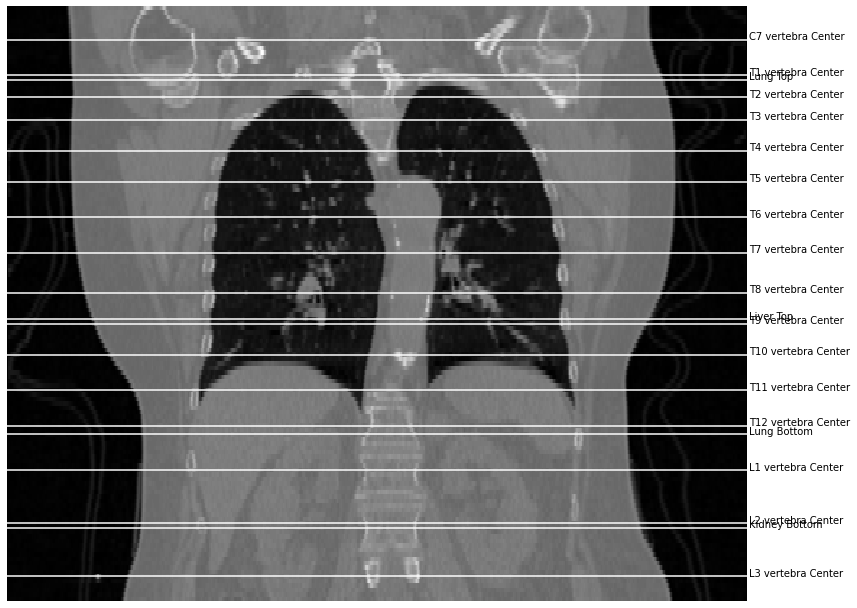

In [ ]:
ct_df_plot = series_df 
landmarks_df_plot = landmarks_series_df_keep

# Get number of possible landmarks 
from matplotlib import cm
num_landmarks = len(landmarks_inference_sorted_df)
# color_map = cm.get_cmap('viridis', num_landmarks)
colormap = cm.get_cmap('plasma', num_landmarks)

# Get the center coronal slice from the CT volume 
ct_nii = os.path.join("/content/ct_qualitative", series_id + '.nii.gz')
nii = nib.load(ct_nii)
img = nii.get_fdata() 
dim = img.shape 
pixel_spacing = nii.header['pixdim'][1:4]
coronal_slice_index = np.uint16(np.floor(dim[1]/2))
coronal_slice = np.squeeze(img[:,coronal_slice_index,:])
coronal_slice_rotated = ndimage.rotate(coronal_slice, 90)

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(12,16)

plt.imshow(coronal_slice_rotated, 'gray', interpolation='none', aspect='auto')
# Now add a line for each landmark 
num_series_landmarks = len(landmarks_df_plot)

color_index = [] 
plot_legend = [] 

for n in range(0,num_series_landmarks): 

  # Get corresponding index of this landmark in the total list so we know what color to assign 
  landmark_name = landmarks_df_plot['landmark_names'].values[n] 
  ind = landmarks_inference_sorted_df.index[landmarks_inference_sorted_df['landmark_and_modifier_name'] == landmark_name].tolist()[0]
  color_index.append(ind)
  slice_index = landmarks_df_plot['slice_index'].values[n]
  slice_index = dim[2]-slice_index
  # print(slice_index)
  # plt.axhline(y=slice_index, color=colormap.colors[ind,:], linestyle='-')
  plt.axhline(y=slice_index, color='w', linestyle='-')

  plt.annotate(landmark_name, xy=(dim[0]+1,slice_index), xycoords='data',annotation_clip=False)


cor_aspect = pixel_spacing[2]/pixel_spacing[0]
ax.set_aspect(cor_aspect)
plt.axis('off')
fig = ax.get_figure()
fig.tight_layout()
plt.show() 

Option 2: small lines on one side 

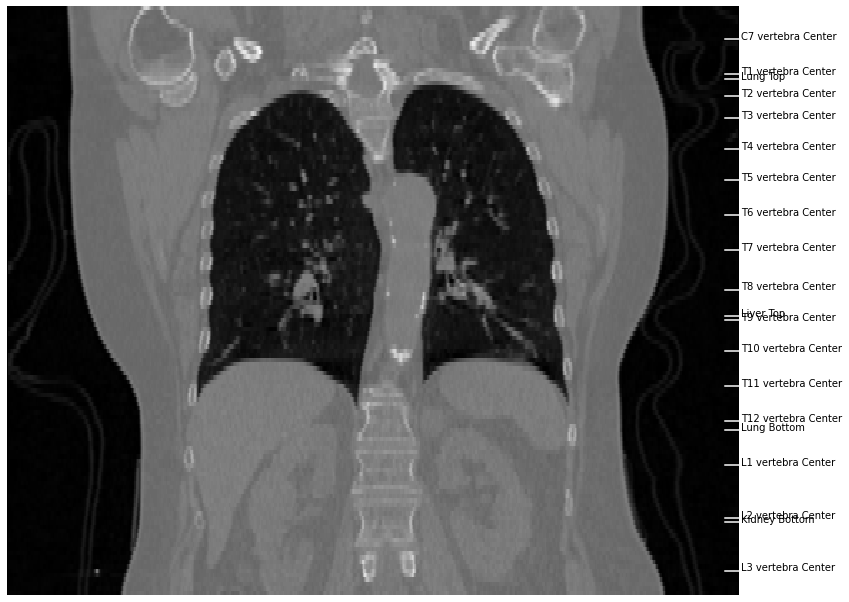

In [ ]:
ct_df_plot = series_df 
landmarks_df_plot = landmarks_series_df_keep

# Get number of possible landmarks 
from matplotlib import cm
num_landmarks = len(landmarks_inference_sorted_df)
# color_map = cm.get_cmap('viridis', num_landmarks)
colormap = cm.get_cmap('plasma', num_landmarks)

# Get the center coronal slice from the CT volume 
ct_nii = os.path.join("/content/ct_qualitative", series_id + '.nii.gz')
nii = nib.load(ct_nii)
img = nii.get_fdata() 
dim = img.shape 
pixel_spacing = nii.header['pixdim'][1:4]
coronal_slice_index = np.uint16(np.floor(dim[1]/2))
coronal_slice = np.squeeze(img[:,coronal_slice_index,:])
coronal_slice_rotated = ndimage.rotate(coronal_slice, 90)

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(12,16)

plt.imshow(coronal_slice_rotated, 'gray', interpolation='none', aspect='auto')
# Now add a line for each landmark 
num_series_landmarks = len(landmarks_df_plot)

color_index = [] 
plot_legend = [] 

for n in range(0,num_series_landmarks): 

  # Get corresponding index of this landmark in the total list so we know what color to assign 
  landmark_name = landmarks_df_plot['landmark_names'].values[n] 
  ind = landmarks_inference_sorted_df.index[landmarks_inference_sorted_df['landmark_and_modifier_name'] == landmark_name].tolist()[0]
  color_index.append(ind)
  slice_index = landmarks_df_plot['slice_index'].values[n]
  slice_index = dim[2]-slice_index
  # print(slice_index)
  # plt.axhline(y=slice_index, color=colormap.colors[ind,:], linestyle='-')
  # plt.axhline(y=slice_index, color='w', linestyle='-')

  # plt.annotate(landmark_name,(dim[0],slice_index)) 
  plt.plot([dim[0]-10, dim[0]+10], 
        [slice_index, slice_index],
        color='w', 
        linestyle='-')
  plt.annotate(landmark_name,xy=(dim[0]+1,slice_index), xycoords='data',annotation_clip=False)


cor_aspect = pixel_spacing[2]/pixel_spacing[0]
ax.set_aspect(cor_aspect)
plt.axis('off')
fig = ax.get_figure()
fig.tight_layout()
plt.show() 

Option 3: small lines on either side, right has anything with center modifier and left has top/bottom modifiers 

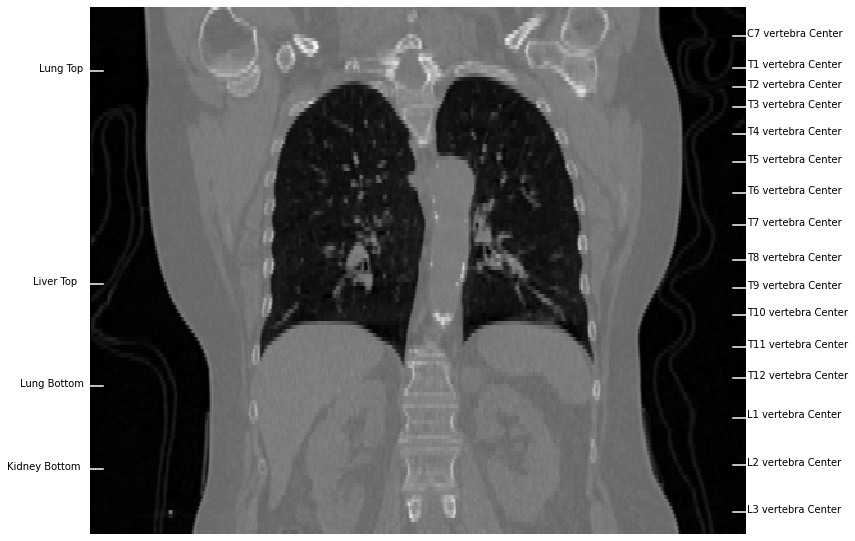

In [ ]:
ct_df_plot = series_df 
landmarks_df_plot = landmarks_series_df_keep

# Get number of possible landmarks 
from matplotlib import cm
num_landmarks = len(landmarks_inference_sorted_df)
# color_map = cm.get_cmap('viridis', num_landmarks)
colormap = cm.get_cmap('plasma', num_landmarks)

# Get the center coronal slice from the CT volume 
ct_nii = os.path.join("/content/ct_qualitative", series_id + '.nii.gz')
nii = nib.load(ct_nii)
img = nii.get_fdata() 
dim = img.shape 
pixel_spacing = nii.header['pixdim'][1:4]
coronal_slice_index = np.uint16(np.floor(dim[1]/2))
coronal_slice = np.squeeze(img[:,coronal_slice_index,:])
coronal_slice_rotated = ndimage.rotate(coronal_slice, 90)

fig, ax = plt.subplots(1, 1)
# fig.set_size_inches(6,8)
fig.set_size_inches(12,16)

plt.imshow(coronal_slice_rotated, 'gray', interpolation='none', aspect='auto')
# Now add a line for each landmark 
num_series_landmarks = len(landmarks_df_plot)

color_index = [] 
plot_legend = [] 

for n in range(0,num_series_landmarks): 

  # Get corresponding index of this landmark in the total list so we know what color to assign 
  landmark_name = landmarks_df_plot['landmark_names'].values[n] 
  ind = landmarks_inference_sorted_df.index[landmarks_inference_sorted_df['landmark_and_modifier_name'] == landmark_name].tolist()[0]
  color_index.append(ind)
  slice_index = landmarks_df_plot['slice_index'].values[n]
  slice_index = dim[2]-slice_index
  # print(slice_index)
  # plt.axhline(y=slice_index, color=colormap.colors[ind,:], linestyle='-')
  # plt.axhline(y=slice_index, color='w', linestyle='-')

  # plt.annotate(landmark_name,(dim[0],slice_index))
  if (('Bottom' in landmark_name) or ('Top' in landmark_name)):
    plt.plot([-10, 10], 
          [slice_index, slice_index],
          color='w', 
          linestyle='-')
    # plt.annotate(landmark_name,xy=(-60,slice_index), xycoords='data',annotation_clip=False)
    plt.annotate(landmark_name,xy=(len(landmark_name)*-5,slice_index), xycoords='data',annotation_clip=False)

  else: 
    plt.plot([dim[0]-10, dim[0]+10], 
          [slice_index, slice_index],
          color='w', 
          linestyle='-')
    plt.annotate(landmark_name,xy=(dim[0]+1,slice_index), xycoords='data',annotation_clip=False)


cor_aspect = pixel_spacing[2]/pixel_spacing[0]
ax.set_aspect(cor_aspect)
plt.axis('off')
fig = ax.get_figure()
fig.tight_layout()
plt.show() 

(134, 512)


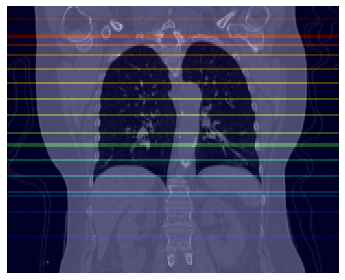

In [ ]:
# ct_df_plot = series_df 
# landmarks_df_plot = landmarks_series_df_keep

# # Get the center coronal slice from the CT volume 
# ct_nii = os.path.join("/content/ct_qualitative", series_id + '.nii.gz')
# nii = nib.load(ct_nii)
# img = nii.get_fdata() 
# dim = img.shape 
# pixel_spacing = nii.header['pixdim'][1:4]
# coronal_slice_index = np.uint16(np.floor(dim[1]/2))
# coronal_slice = np.squeeze(img[:,coronal_slice_index,:])
# coronal_slice_rotated = ndimage.rotate(coronal_slice, 90)

# from matplotlib import cm
# num_landmarks = len(landmarks_inference_sorted)
# viridis = cm.get_cmap('viridis', num_landmarks)
# # Create overlay labelmap 
# landmarks_array = np.zeros((dim[2], dim[0]))
# print(landmarks_array.shape)

# slice_indices = landmarks_df_plot['slice_index'].values

# for m in range(0,len(slice_indices)): 
#   # landmarks_array[slice_indices[m],:] = m
#   # later use index from where the landmark appears in the list - want the same colors across subjects 
#   landmarks_array[slice_indices[m],:] = m
# # flip
# landmarks_array = np.flipud(landmarks_array) # because of plotting 

# fig, ax = plt.subplots(1, 1)
# # ax.imshow(coronal_slice_rotated, cmap='gray', vmax=1500, vmin=-1000, aspect="auto")
# # ax.imshow(landmarks_array, cmap='OrRd', aspect="auto", alpha=0.5, interpolation='none')

# plt.imshow(coronal_slice_rotated, 'gray', interpolation='none', aspect='auto')
# plt.imshow(landmarks_array, 'jet', interpolation='none', alpha=0.3)


# cor_aspect = pixel_spacing[2]/pixel_spacing[0]
# ax.set_aspect(cor_aspect)
# # plt.gca().invert_yaxis()
# plt.axis('off')
# fig = ax.get_figure()
# fig.tight_layout()
# # plt.legend(loc="upper right", bbox_to_anchor=(1.25, 1.0))
# plt.show() 




### **(paper figure #8)** NSCLC-Radiomics - Distributions of the distance between the superior slice of the expert lung delineations and the lung_top landmark, and between the inferior slice of the expert lung delineations and the lung_bottom landmark

First we have to get the bpr landmarks information of the lung 

In [228]:
client = bigquery.Client(project=project_name)
table_id = ".".join(['bigquery-public-data', 'idc_current', 'dicom_all']) 

print(table_id)

query = f"""
--creating a temporary table that is flatenned on most columns using left joins and 
--unnesting upto three levels starting with zeroth level
--the temporary table could be very helpful to visualize.
--Once the table is flattened,
--sub tables are created, one for each attribute of interest.
--then they are joined on measurement group numbers and sop instance uid.

-- Start by creating a temporary table called 'temp'
with temp as (
  -- In the SELECT statement, we're choosing which columns to include in the temporary table
  SELECT
  SOPInstanceUID, 
  bid.SeriesInstanceUID, 
  measurementGroup_number, -- Number assigned to a measurement group
  cs_l2.UID, -- Unique identifier for the content sequence at level 2
  cs_l2.TextValue, -- Text value associated with the content sequence at level 2
  collection_id, # I added 
  PatientID, 
  SeriesDescription, 
  SOPClassUID,
  cts_l0.MappingResource, -- Resource used to map the content template sequence at level 0
  cts_l0.TemplateIdentifier, -- Unique identifier for the content template sequence at level 0
  cs_l0.ValueType, -- Type of value associated with the content sequence at level 0
  cs_l1_cncs.CodeMeaning, -- Code meaning associated with the concept name coding sequence at level 1
  cs_l2.ValueType, -- Type of value associated with the content sequence at level 2
  cs_l2_cncs.CodeValue, -- Code value associated with the concept name coding sequence at level 2
  cs_l2_cncs.CodingSchemeDesignator, -- Coding scheme designator associated with the concept name coding sequence at level 2
  cs_l2_cncs.CodeMeaning as cm2, -- Code meaning associated with the concept name coding sequence at level 2, with an alias of 'cm2'
  cs_l2_rss.ReferencedSOPClassUID, -- Unique identifier for the referenced SOP class
  cs_l2_rss.ReferencedSOPInstanceUID, -- Unique identifier for the referenced SOP instance
  cs_l2_rss.ReferencedSegmentNumber, -- Number assigned to a referenced segment
  cs_l2_css, -- concept Code sequence associated with the content sequence at level 2
  cs_l1, -- Content sequence at level 1
  cs_l2, 
  crpes_rss.SeriesInstanceUID as crpes_ref, 
  cs_l2_cncs,
  cs_l3.ValueType vt3, -- Type of value associated with the content sequence at level 3
  cs_l3_cncs.CodeValue cv3,  -- Code value associated with the concept name coding sequence at level 3
  cs_l3_cncs.CodingSchemeDesignator,  -- Coding scheme designator associated with the concept name coding sequence at level 3
  cs_l3_cncs.CodeMeaning as cm3, -- Code meaning associated with the concept name coding sequence at level 3, with an alias of 'cm3'
  cs_l3_css, -- concept Code sequence associated with the content sequence at level 3

  FROM
  `bigquery-public-data.idc_current.dicom_all` bid -- Data source
  --bigquery-public-data.idc_current.dicom_metadata bid -- Data source
  -- Left join zeroth level of ContentTemplateSequence
  LEFT JOIN
  UNNEST(bid.ContentTemplateSequence) cts_l0
  -- Left join zeroth level of ContentSequence
  LEFT JOIN
  UNNEST(bid.ContentSequence) cs_l0
  -- *generate from chatgpt* 
  LEFT JOIN
  UNNEST(bid.CurrentRequestedProcedureEvidenceSequence) crpes
  -- *generate from chatgpt* 
  LEFT JOIN 
  UNNEST(crpes.ReferencedSeriesSequence) crpes_rss
  -- Unnest content sequence at level 1, with an offset assigned to measurementGroup_number
  LEFT JOIN
  unnest(cs_l0.ContentSequence) cs_l1
  WITH
  OFFSET
  AS measurementGroup_number
  -- Left join ConceptNameCodeSequence at level 1
  LEFT JOIN
  unnest(cs_l1.ConceptNameCodeSequence) cs_l1_cncs
  -- Unnest content sequence at level 2
  LEFT JOIN
  unnest(cs_l1.ContentSequence) cs_l2
  -- Left join ConceptNameCodeSequence at level 2
  LEFT JOIN
  unnest(cs_l2.ConceptNameCodeSequence) cs_l2_cncs
  -- Left join ReferencedSOPSequence at level 2
  LEFT JOIN
  unnest(cs_l2.ReferencedSOPSequence) cs_l2_rss
  -- Left join ConceptCodeSequence at level 2
  LEFT JOIN
  unnest(cs_l2.ConceptCodeSequence) cs_l2_css
  -- Unnest content sequence at level 3
  LEFT JOIN
  unnest(cs_l2.ContentSequence) cs_l3
  -- Left join ConceptNameCodeSequence at level 3
  LEFT JOIN
  unnest(cs_l3.ConceptNameCodeSequence) cs_l3_cncs
  -- Left join ConceptCodeSequence at level 2
  LEFT JOIN
  unnest(cs_l3.ConceptCodeSequence) cs_l3_css
  
  WHERE
  --SeriesDescription not in ("BPR landmark annotations", "BPR region annotations") and
  --PatientID in ('LUNG1-002') AND
  -- We only want to include records where the TemplateIdentifier is 1500 and MappingResource is DCMR
  TemplateIdentifier IN ('1500')
  AND MappingResource IN ('DCMR')

  -- We only want to include CONTAINER value types in the first level of content sequence
  AND cs_l0.ValueType IN ('CONTAINER')

  -- We only want to include Measurement Group Code Meanings in the second level of content sequence
  AND cs_l1_cncs.CodeMeaning IN ("Measurement Group")

  -- We want to include certain value types and code values in the third level of content sequence
  AND (
    -- Tracking Identifier-- TEXT value type with specific Code Value and Coding Scheme Designator
    (cs_l2.ValueType IN ('TEXT') AND cs_l2_cncs.CodeValue IN ('112039')AND cs_l2_cncs.CodingSchemeDesignator IN ('DCM')) 
    -- Tracking Unique Identifier--UIDREF value type with specific Code Value and Coding Scheme Designator
    OR (cs_l2.ValueType IN ('UIDREF') AND cs_l2_cncs.CodeValue IN ('112040')AND cs_l2_cncs.CodingSchemeDesignator IN ('DCM'))  
    -- Referenced Segment or Source--IMAGE value type with specific Referenced SOP Class UID
    OR (cs_l2.ValueType IN ('IMAGE') AND  cs_l2_rss.ReferencedSOPClassUID IN ("1.2.840.10008.5.1.4.1.1.66.4","1.2.840.10008.5.1.4.1.1.2"))--allowing one more class for 'Source'
    -- Source series for segmentation--UIDREF value type with specific Code Value and Coding Scheme Designator
    OR (cs_l2.ValueType IN ('UIDREF') AND cs_l2_cncs.CodeValue IN ('121232')AND cs_l2_cncs.CodingSchemeDesignator IN ('DCM')) 
    -- Finding--CODE value type with specific Code Value and Coding Scheme Designator
    OR (cs_l2.ValueType IN ('CODE') AND cs_l2_cncs.CodeValue IN ('121071')AND cs_l2_cncs.CodingSchemeDesignator IN ('DCM')) 
    -- Finding Site--CODE value type with specific Code Value and Coding Scheme Designator
    OR (cs_l2.ValueType IN ('CODE') AND cs_l2_cncs.CodeValue IN ('G-C0E3')AND cs_l2_cncs.CodingSchemeDesignator IN ('SRT'))
    -- Finding Site--CODE value type with specific Code Value and Coding Scheme Designator
    OR (cs_l2.ValueType IN ('CODE') AND cs_l2_cncs.CodeValue IN ('363698007')AND cs_l2_cncs.CodingSchemeDesignator IN ('SCT'))  
  )
  -- We only want to include certain SOP Class UIDs
  AND SOPClassUID IN ("1.2.840.10008.5.1.4.1.1.88.11", "1.2.840.10008.5.1.4.1.1.88.22", "1.2.840.10008.5.1.4.1.1.88.33","1.2.840.10008.5.1.4.1.1.88.34","1.2.840.10008.5.1.4.1.1.88.35") 
--and PatientID in ('LUNG1-002')
  -- We could activate the below line for testing
  -- AND SOPInstanceUID in ('1.2.276.0.7230010.3.1.4.0.11647.1553294587.292373'
),
finding as (SELECT * from temp where cm2 ='Finding'),
findingsite as (SELECT * from temp where cm2 ='Finding Site'),
ReferencedSegment as (SELECT * from temp where cm2 ='Referenced Segment'),
SourceSeriesforsegmentation as (SELECT * from temp where cm2 ='Source series for segmentation'),
TrackingIdentifier as (SELECT * from temp where cm2 ='Tracking Identifier'),
TrackingUniqueIdentifier as  (SELECT * from temp where cm2 ='Tracking Unique Identifier'),
SourceInstance as  (SELECT * from temp where cm2 ='Source')

Select
TrackingIdentifier.SOPInstanceUID, 
TrackingIdentifier.SeriesInstanceUID,
TrackingIdentifier.measurementGroup_number,
TrackingUniqueIdentifier.UID as trackingUniqueIdentifier,
TrackingIdentifier.TextValue as trackingIdentifier,
TrackingIdentifier.PatientID,
TrackingIdentifier.collection_id, 
--TrackingIdentifier.SeriesDescription,  --different from measurement groups query
SourceSeriesforsegmentation.UID as sourceSegmentedSeriesUID,
SourceInstance.ReferencedSOPInstanceUID as sourceReferencedSOPInstanceUID,--newly introduced column compared to previous qualitative query
ReferencedSegment.ReferencedSOPInstanceUID as segmentationInstanceUID,
ReferencedSegment.ReferencedSegmentNumber as segmentationSegmentNumber,
findingsite.cs_l2_cncs as Quantity, --different from measurements groups query
findingsite.cs_l2_css as Value,--different from measurements groups query
finding.cs_l2_css as finding,
findingsite.cs_l2_css as findingSite,
findingsite.cs_l3_css as findingSite_topographicalModifier, --newly introduced array compared to previous qualitative query
TrackingIdentifier.crpes_ref
# TrackingUniqueIdentifier.crpes_ref   

--TrackingIdentifier.cs_l1 as contentSequence --different from measurements groups query

from TrackingIdentifier
join TrackingUniqueIdentifier using (SOPInstanceUID, measurementGroup_number)
left join finding using (SOPInstanceUID, measurementGroup_number)
left join findingsite using (SOPInstanceUID, measurementGroup_number)
left join ReferencedSegment using (SOPInstanceUID, measurementGroup_number)
left join SourceSeriesforsegmentation using (SOPInstanceUID, measurementGroup_number)
left join SourceInstance using (SOPInstanceUID, measurementGroup_number)

-- left JOIN 
--   `bigquery-public-data.idc_current.dicom_all` as dicom_all 
-- ON 
--   SourceInstance.ReferencedSOPInstanceUID = dicom_all.SOPInstanceUID 

--the bottom line are different from measurement groups query
where findingsite.cs_l2.ValueType in ('CODE') and findingsite.cs_l2_cncs.CodeValue not in ('121071','G-C0E3') and TrackingIdentifier.collection_id = "nsclc_radiomics" 

-- ORDER BY 
--   PatientID, 
--   measurementGroup_number 
"""

job_config = bigquery.QueryJobConfig()
qual_df = client.query(query, job_config=job_config).to_dataframe()

bigquery-public-data.idc_current.dicom_all


Now we get just the landmarks from the qualitative qual_df above.

In [229]:
# We need to form a data frame 

# includes landmarks and regions 
landmarks_regions_df = qual_df[qual_df['sourceSegmentedSeriesUID'].isin([None])] 

# just includes landmarks 
landmarks_series_df = landmarks_regions_df[landmarks_regions_df['trackingIdentifier'].str.contains("landmarks")]

# now just include where the region is lung and the modifier is top or bottom 
findingSite = [f['CodeMeaning'] for f in list(landmarks_series_df['findingSite'].values)]
findingSite_modifier = [f['CodeMeaning'] for f in list(landmarks_series_df['findingSite_topographicalModifier'].values)]
# add 
landmarks_series_df['landmark_name'] = findingSite  
landmarks_series_df['landmark_modifier'] = findingSite_modifier  
# now keep the ones with lung 
landmarks_series_df = landmarks_series_df[landmarks_series_df['landmark_name']=="Lung"]



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [230]:
landmarks_series_df

SOPInstanceUID  \
992     1.2.826.0.1.3680043.8.498.21938328022180484722...   
1005    1.2.826.0.1.3680043.8.498.21938328022180484722...   
2800    1.2.826.0.1.3680043.8.498.76924982888691069226...   
3898    1.2.826.0.1.3680043.8.498.76596695966105786600...   
3911    1.2.826.0.1.3680043.8.498.76596695966105786600...   
...                                                   ...   
421199  1.2.826.0.1.3680043.8.498.12598006227664584713...   
422341  1.2.826.0.1.3680043.8.498.40580784996639576457...   
422354  1.2.826.0.1.3680043.8.498.40580784996639576457...   
424849  1.2.826.0.1.3680043.8.498.10494504349192411415...   
424862  1.2.826.0.1.3680043.8.498.10494504349192411415...   

                                        SeriesInstanceUID  \
992     1.2.826.0.1.3680043.8.498.88836949109720836913...   
1005    1.2.826.0.1.3680043.8.498.88836949109720836913...   
2800    1.2.826.0.1.3680043.8.498.32137980857204121708...   
3898    1.2.826.0.1.3680043.8.498.81663289490458228604...   
3911    1.2.826.0.1.3680043.8.498.81663289490458228604...   
...                                                   ...   
421199  1.2.826.0.1.3680043.8.498.11505663862317974768...   
422341  1.2.826.0.1.3680043.8.498.91840531126503059115...   
422354  1.2.826.0.1.3680043.8.498.91840531126503059115...   
424849  1.2.826.0.1.3680043.8.498.47999418577788290822...   
424862  1.2.826.0.1.3680043.8.498.47999418577788290822...   

        measurementGroup_number  \
992                           3   
1005                         16   
2800                         10   
3898                          0   
3911                         13   
...                         ...   
421199                       14   
422341                        2   
422354                       15   
424849                        0   
424862                       13   

                                 trackingUniqueIdentifier  \
992     1.2.826.0.1.3680043.8.498.13132972513237804050...   
1005    1.2.826.0.1.3680043.8.498.88568353444851429085...   
2800    1.2.826.0.1.3680043.8.498.12740580998086916601...   
3898    1.2.826.0.1.3680043.8.498.83943710728355709926...   
3911    1.2.826.0.1.3680043.8.498.15496579000470680500...   
...                                                   ...   
421199  1.2.826.0.1.3680043.8.498.21353676869615057062...   
422341  1.2.826.0.1.3680043.8.498.10119978893882420072...   
422354  1.2.826.0.1.3680043.8.498.92870435321266418876...   
424849  1.2.826.0.1.3680043.8.498.35561893813726053946...   
424862  1.2.826.0.1.3680043.8.498.11787444043313863308...   

                    trackingIdentifier  PatientID    collection_id  \
992      Annotations group landmarks 4  LUNG1-346  nsclc_radiomics   
1005    Annotations group landmarks 17  LUNG1-346  nsclc_radiomics   
2800    Annotations group landmarks 11  LUNG1-253  nsclc_radiomics   
3898     Annotations group landmarks 1  LUNG1-023  nsclc_radiomics   
3911    Annotations group landmarks 14  LUNG1-023  nsclc_radiomics   
...                                ...        ...              ...   
421199  Annotations group landmarks 15  LUNG1-289  nsclc_radiomics   
422341   Annotations group landmarks 3  LUNG1-075  nsclc_radiomics   
422354  Annotations group landmarks 16  LUNG1-075  nsclc_radiomics   
424849   Annotations group landmarks 1  LUNG1-406  nsclc_radiomics   
424862  Annotations group landmarks 14  LUNG1-406  nsclc_radiomics   

       sourceSegmentedSeriesUID  \
992                        None   
1005                       None   
2800                       None   
3898                       None   
3911                       None   
...                         ...   
421199                     None   
422341                     None   
422354                     None   
424849                     None   
424862                     None   

                           sourceReferencedSOPInstanceUID  \
992     1.3.6.1.4.1.32722.99.99.1989128455006765108846...   
1005    1.3.6.1.4.1.32722.99.99.1185307

Now we have to calculate the actual position of the lung landmarks (top, bottom, or both) for each SOPInstanceUID. For this we need to query again. 

In [231]:
sop_ids = list(landmarks_series_df['sourceReferencedSOPInstanceUID'].values) 

client = bigquery.Client(project=project_name)
query = f"""
  SELECT 
    DISTINCT(SOPInstanceUID),
    PatientID,
    StudyInstanceUID,
    SeriesInstanceUID, 
    CONCAT("https://viewer.imaging.datacommons.cancer.gov/viewer/",StudyInstanceUID) as viewer_url, 
    ARRAY_TO_STRING(ImagePositionPatient,"/") AS ImagePositionPatient, 
    ARRAY_TO_STRING(ImageOrientationPatient, "/") AS ImageOrientationPatient
  FROM
    `bigquery-public-data.idc_current.dicom_all` 
  WHERE
    SOPInstanceUID IN UNNEST(@sop_ids)
  ORDER BY 
    PatientID, 
    StudyInstanceUID;
  """

job_config = bigquery.QueryJobConfig(query_parameters=[
                                                      bigquery.ArrayQueryParameter("sop_ids", "STRING", sop_ids)
                                                      ])
result = client.query(query, job_config=job_config) 
sop_ipp_df = result.to_dataframe(create_bqstorage_client=True)

For each row, calculate the actual position and add it as a column to the table. 

In [232]:
# sop_ids = list(landmarks_series_df['sourceReferencedSOPInstanceUID'].values) ## is this sourceReferencedSOPInstanceUID wrong?? 
sop_ids = list(sop_ipp_df['SOPInstanceUID'].values) 
num_series = len(sop_ids) 

pos_all = [] 

for n in range(0,num_series):
  
  sop_id = sop_ids[n] 
  # sop_df = landmarks_series_df[landmarks_series_df['sourceReferencedSOPInstanceUID']==sop_id]
  sop_df = sop_ipp_df[sop_ipp_df['SOPInstanceUID']==sop_id]
  ImageOrientation = sop_df['ImageOrientationPatient'].values[0] 
  ImageOrientation = ImageOrientation.split('/')
  ImageOrientation = [np.float32(f) for f in ImageOrientation]
  ImagePositionPatient = sop_df['ImagePositionPatient'].values[0] 
  ImagePositionPatient = ImagePositionPatient.split('/')
  ImagePositionPatient = [np.float32(f) for f in ImagePositionPatient]

  # calculate z value
  x_vector = ImageOrientation[0:3]
  y_vector = ImageOrientation[3:]
  z_vector = np.cross(x_vector,y_vector)

  # multiple z_vector by ImagePositionPatient
  pos = np.dot(z_vector,ImagePositionPatient)
  pos_all.append(pos)

# landmarks_series_df['pos'] = pos_all 
sop_ipp_df['pos'] = pos_all

In [233]:
sop_ipp_df

SOPInstanceUID  PatientID  \
0    1.3.6.1.4.1.32722.99.99.1132685649015073607577...  LUNG1-001   
1    1.3.6.1.4.1.32722.99.99.2631590101868572590236...  LUNG1-001   
2    1.3.6.1.4.1.32722.99.99.3363327544272700629355...  LUNG1-002   
3    1.3.6.1.4.1.32722.99.99.1410032064864351004350...  LUNG1-002   
4    1.3.6.1.4.1.32722.99.99.1747536477884928147436...  LUNG1-003   
..                                                 ...        ...   
734  1.3.6.1.4.1.32722.99.99.3417478691990293066959...  LUNG1-420   
735  1.3.6.1.4.1.32722.99.99.2965769160880948211427...  LUNG1-421   
736  1.3.6.1.4.1.32722.99.99.7071267995414975425742...  LUNG1-421   
737  1.3.6.1.4.1.32722.99.99.1714568817777621328265...  LUNG1-422   
738  1.3.6.1.4.1.32722.99.99.1852086356579095129522...  LUNG1-422   

                                      StudyInstanceUID  \
0    1.3.6.1.4.1.32722.99.99.2393413539117143687725...   
1    1.3.6.1.4.1.32722.99.99.2393413539117143687725...   
2    1.3.6.1.4.1.32722.99.99.2037150038059966416957...   
3    1.3.6.1.4.1.32722.99.99.2037150038059966416957...   
4    1.3.6.1.4.1.32722.99.99.2477262867958601216867...   
..                                                 ...   
734  1.3.6.1.4.1.32722.99.99.2607665217932065751026...   
735  1.3.6.1.4.1.32722.99.99.9487282134711408248112...   
736  1.3.6.1.4.1.32722.99.99.9487282134711408248112...   
737  1.3.6.1.4.1.32722.99.99.3228297855554221494057...   
738  1.3.6.1.4.1.32722.99.99.3228297855554221494057...   

                                     SeriesInstanceUID  \
0    1.3.6.1.4.1.32722.99.99.2989917765213423750108...   
1    1.3.6.1.4.1.32722.99.99.2989917765213423750108...   
2    1.3.6.1.4.1.32722.99.99.2329880015517990803358...   
3    1.3.6.1.4.1.32722.99.99.2329880015517990803358...   
4    1.3.6.1.4.1.32722.99.99.2389222799296192439904...   
..                                                 ...   
734  1.3.6.1.4.1.32722.99.99.3116735173196404572362...   
735  1.3.6.1.4.1.32722.99.99.3051646366712319699947...   
736  1.3.6.1.4.1.32722.99.99.3051646366712319699947...   
737  1.3.6.1.4.1.32722.99.99.2350774061601826088292...   
738  1.3.6.1.4.1.32722.99.99.2350774061601826088292...   

                                            viewer_url  \
0    https://viewer.imaging.datacommons.cancer.gov/...   
1    https://viewer.imaging.datacommons.cancer.gov/...   
2    https://viewer.imaging.datacommons.cancer.gov/...   
3    https://viewer.imaging.datacommons.cancer.gov/...   
4    https://viewer.imaging.datacommons.cancer.gov/...   
..                                                 ...   
734  https://viewer.imaging.datacommons.cancer.gov/...   
735  https://viewer.imaging.datacommons.cancer.gov/...   
736  https://viewer.imaging.datacommons.cancer.gov/...   
737  https://viewer.imaging.datacommons.cancer.gov/...   
738  https://viewer.imaging.datacommons.cancer.gov/...   

                   ImagePositionPatient  \
0    -249.51171875/-460.51171875/-354.5   
1    -249.51171875/-460.51171875/-612.5   
2         -250.1120/-250.1120/-103.4000   
3          -250.1120/-250.1120/157.6000   
4          -250.1120/-250.1120/-71.9000   
..                                  ...   
734    -249.51171875/-447.51171875/-619   
735    -249.51171875/-390.51171875/-356   
736    -249.51171875/-390.51171875/-611   
737    -249.51171875/-439.51171875/-553   
738    -249.51171875/-439.51171875/-328   

                       ImageOrientationPatient         pos  
0                                  1/0/0/0/1/0 -354.500000  
1                                  1/0/0/0/1/0 -612.500000  
2    1.0000/0.0000/0.0000/0.0000/1.0000/0.0000 -103.400002  
3    1.0000/0.0000/0.0000/0.0000/1.0000/0.0000  157.600006  
4    1.0000/0.0000/0.0000/0.0000/1.0000/0.0000  -71.900002  
..                                         ...         ...  
734                                1/0/0/0/1/0 -619.000000  
735                                1/0/0/0/1/0 -356.000000  
736                                1/0/0/0/1/0 -611.00

Let's add the landmark name and modifier to sop_ipp_df for the lung landmarks from the landmarks_series_df.

In [234]:
landmark_names = [] 
landmark_modifiers = [] 

for n in range(0,num_series): 
  sop_id = sop_ids[n]
  # sop_df = sop_ipp_df[sop_ipp_df['SOPInstanceUID']==sop_id]
  landmark_name = landmarks_series_df[landmarks_series_df['sourceReferencedSOPInstanceUID']==sop_id]['landmark_name'].values[0] 
  landmark_modifier = landmarks_series_df[landmarks_series_df['sourceReferencedSOPInstanceUID']==sop_id]['landmark_modifier'].values[0]
  landmark_names.append(landmark_name)
  landmark_modifiers.append(landmark_modifier)
# Add to sop_ipp_df 
sop_ipp_df['landmark_name'] = landmark_names 
sop_ipp_df['landmark_modifier'] = landmark_modifiers 

In [235]:
sop_ipp_df.head()

SOPInstanceUID  PatientID  \
0  1.3.6.1.4.1.32722.99.99.1132685649015073607577...  LUNG1-001   
1  1.3.6.1.4.1.32722.99.99.2631590101868572590236...  LUNG1-001   
2  1.3.6.1.4.1.32722.99.99.3363327544272700629355...  LUNG1-002   
3  1.3.6.1.4.1.32722.99.99.1410032064864351004350...  LUNG1-002   
4  1.3.6.1.4.1.32722.99.99.1747536477884928147436...  LUNG1-003   

                                    StudyInstanceUID  \
0  1.3.6.1.4.1.32722.99.99.2393413539117143687725...   
1  1.3.6.1.4.1.32722.99.99.2393413539117143687725...   
2  1.3.6.1.4.1.32722.99.99.2037150038059966416957...   
3  1.3.6.1.4.1.32722.99.99.2037150038059966416957...   
4  1.3.6.1.4.1.32722.99.99.2477262867958601216867...   

                                   SeriesInstanceUID  \
0  1.3.6.1.4.1.32722.99.99.2989917765213423750108...   
1  1.3.6.1.4.1.32722.99.99.2989917765213423750108...   
2  1.3.6.1.4.1.32722.99.99.2329880015517990803358...   
3  1.3.6.1.4.1.32722.99.99.2329880015517990803358...   
4  1.3.6.1.4.1.32722.99.99.2389222799296192439904...   

                                          viewer_url  \
0  https://viewer.imaging.datacommons.cancer.gov/...   
1  https://viewer.imaging.datacommons.cancer.gov/...   
2  https://viewer.imaging.datacommons.cancer.gov/...   
3  https://viewer.imaging.datacommons.cancer.gov/...   
4  https://viewer.imaging.datacommons.cancer.gov/...   

                 ImagePositionPatient  \
0  -249.51171875/-460.51171875/-354.5   
1  -249.51171875/-460.51171875/-612.5   
2       -250.1120/-250.1120/-103.4000   
3        -250.1120/-250.1120/157.6000   
4        -250.1120/-250.1120/-71.9000   

                     ImageOrientationPatient         pos landmark_name  \
0                                1/0/0/0/1/0 -354.500000          Lung   
1                                1/0/0/0/1/0 -612.500000          Lung   
2  1.0000/0.0000/0.0000/0.0000/1.0000/0.0000 -103.400002          Lung   
3  1.0000/0.0000/0.0000/0.0000/1.0000/0.0000  157.600006          Lung   
4  1.0000/0.0000/0.0000/0.0000/1.0000/0.0000  -71.900002          Lung   

  landmark_modifier  
0               Top  
1            Bottom  
2            Bottom  
3               Top  
4               Top

Then we have to query for the ground truth segmentations for NSCLC-Radiomics

In [236]:
client = bigquery.Client(project=project_name)

query = """

# First get a list of the SOPInstanceUIDs of the DICOM Segmentation objects for the expert in the NSCLC-Radiomics collection
WITH seg_sops AS (
  SELECT 
    PatientID, 
    SeriesInstanceUID, 
    SOPInstanceUID,
    SeriesDescription,
    gcs_url
  FROM 
    `bigquery-public-data.idc_current.dicom_all`
  WHERE
    Modality = "SEG" AND 
    collection_id = "nsclc_radiomics" AND 
    SeriesDescription = "Segmentation"
  ORDER BY 
    PatientID 
)

# Now join the above to get only the segmented_SeriesInstanceUIDs that have the regions we want
# We will use these to get the AI-derived DICOM Segmentation objects 
SELECT 
  DISTINCT(seg.segmented_SeriesInstanceUID), 
  seg.PatientID, 
  seg_sops.SOPInstanceUID,
  seg_sops.SeriesDescription,
  seg_sops.gcs_url

FROM 
  `bigquery-public-data.idc_current.segmentations` as seg 
JOIN 
  seg_sops 
ON 
  seg.SOPInstanceUID = seg_sops.SOPInstanceUID
WHERE
#   seg.SegmentedPropertyType.CodeMeaning = "Esophagus" OR 
#   seg.SegmentedPropertyType.CodeMeaning = "Heart" OR
#   seg.SegmentedPropertyType.CodeMeaning = "Trachea" OR
#   seg.SegmentedPropertyType.CodeMeaning = "Aorta"
  seg.SegmentedPropertyType.CodeMeaning = "Lung"
ORDER BY 
  seg.PatientID; 

"""

job_config = bigquery.QueryJobConfig()
seg_expert_df = client.query(query, job_config=job_config).to_dataframe()

In [237]:
seg_expert_df 

segmented_SeriesInstanceUID  PatientID  \
0    1.3.6.1.4.1.32722.99.99.2989917765213423750108...  LUNG1-001   
1    1.3.6.1.4.1.32722.99.99.2329880015517990803358...  LUNG1-002   
2    1.3.6.1.4.1.32722.99.99.2389222799296192439904...  LUNG1-003   
3    1.3.6.1.4.1.32722.99.99.2809816144625926346520...  LUNG1-004   
4    1.3.6.1.4.1.32722.99.99.3490584753983772067630...  LUNG1-005   
..                                                 ...        ...   
406  1.3.6.1.4.1.32722.99.99.1452469930699451440457...  LUNG1-418   
407  1.3.6.1.4.1.32722.99.99.1485019640321281490267...  LUNG1-419   
408  1.3.6.1.4.1.32722.99.99.3116735173196404572362...  LUNG1-420   
409  1.3.6.1.4.1.32722.99.99.3051646366712319699947...  LUNG1-421   
410  1.3.6.1.4.1.32722.99.99.2350774061601826088292...  LUNG1-422   

                                        SOPInstanceUID SeriesDescription  \
0    1.2.276.0.7230010.3.1.4.2323910823.20524.15972...      Segmentation   
1    1.2.276.0.7230010.3.1.4.2323910823.11504.15972...      Segmentation   
2    1.2.276.0.7230010.3.1.4.2323910823.23864.15972...      Segmentation   
3    1.2.276.0.7230010.3.1.4.2323910823.4780.159726...      Segmentation   
4    1.2.276.0.7230010.3.1.4.2323910823.11644.15972...      Segmentation   
..                                                 ...               ...   
406  1.2.276.0.7230010.3.1.4.2323910823.9396.159725...      Segmentation   
407  1.2.276.0.7230010.3.1.4.2323910823.25160.15972...      Segmentation   
408  1.2.276.0.7230010.3.1.4.2323910823.1672.159725...      Segmentation   
409  1.2.276.0.7230010.3.1.4.2323910823.18724.15972...      Segmentation   
410  1.2.276.0.7230010.3.1.4.2323910823.20536.15972...      Segmentation   

                                               gcs_url  
0    gs://idc-open-cr/553521b9-f9e8-4103-b04d-5f032...  
1    gs://idc-open-cr/eff917af-8a2a-42fe-9e12-22bce...  
2    gs://idc-open-cr/8b8ec28d-1e6f-41a3-85f6-d1dac...  
3    gs://idc-open-cr/a3619297-0f76-4fc2-8fc5-b5c59...  
4    gs://idc-open-cr/7481751e-53e9-437e-b70b-572a7...  
..                                                 ...  
406  gs://idc-open-cr/1847ef93-fae7-4282-9057-5be93...  
407  gs://idc-open-cr/8300eea1-30fd-4710-a437-9331f...  
408  gs://idc-open-cr/66aa1bb6-32b6-47ca-aad3-3c29f...  
409  gs://idc-open-cr/86dac2ac-a0f2-4738-a65b-4a711...  
410  gs://idc-open-cr/2787cbe8-9a93-4ddc-b998-129f2...  

[411 rows x 5 columns]

In [238]:
num_expert_seg = len(seg_expert_df)
print(num_expert_seg)

411


We next need to get the image position patient and orientation information from the original CT files that correspond to these series. These will later be used to calculate the distances between the expert delineated lung and the landmarks. 

In [239]:
series_ids = list(seg_expert_df['segmented_SeriesInstanceUID'].values)
print(len(series_ids))

411


In [240]:
client = bigquery.Client(project=project_name)

query = """
  SELECT 
    PatientID, 
    StudyInstanceUID,
    SeriesInstanceUID, 
    SOPInstanceUID, 
    ARRAY_TO_STRING(ImagePositionPatient, "/") as ImagePositionPatient,
    ARRAY_TO_STRING(ImageOrientationPatient, "/") as ImageOrientationPatient,
    CONCAT("https://viewer.imaging.datacommons.cancer.gov/viewer/",StudyInstanceUID) as viewer_url
  FROM 
    `bigquery-public-data.idc_current.dicom_all`
  WHERE
    SeriesInstanceUID IN UNNEST(@series_ids) AND 
    Modality = "CT" 
  ORDER BY 
    PatientID, 
    StudyInstanceUID,
    SeriesInstanceUID;
"""

job_config = bigquery.QueryJobConfig(    
    query_parameters=[
        bigquery.ArrayQueryParameter("series_ids", "STRING", series_ids)])
ct_df = client.query(query, job_config=job_config).to_dataframe()

In [241]:
ct_df

PatientID                                   StudyInstanceUID  \
0      LUNG1-001  1.3.6.1.4.1.32722.99.99.2393413539117143687725...   
1      LUNG1-001  1.3.6.1.4.1.32722.99.99.2393413539117143687725...   
2      LUNG1-001  1.3.6.1.4.1.32722.99.99.2393413539117143687725...   
3      LUNG1-001  1.3.6.1.4.1.32722.99.99.2393413539117143687725...   
4      LUNG1-001  1.3.6.1.4.1.32722.99.99.2393413539117143687725...   
...          ...                                                ...   
49905  LUNG1-422  1.3.6.1.4.1.32722.99.99.3228297855554221494057...   
49906  LUNG1-422  1.3.6.1.4.1.32722.99.99.3228297855554221494057...   
49907  LUNG1-422  1.3.6.1.4.1.32722.99.99.3228297855554221494057...   
49908  LUNG1-422  1.3.6.1.4.1.32722.99.99.3228297855554221494057...   
49909  LUNG1-422  1.3.6.1.4.1.32722.99.99.3228297855554221494057...   

                                       SeriesInstanceUID  \
0      1.3.6.1.4.1.32722.99.99.2989917765213423750108...   
1      1.3.6.1.4.1.32722.99.99.2989917765213423750108...   
2      1.3.6.1.4.1.32722.99.99.2989917765213423750108...   
3      1.3.6.1.4.1.32722.99.99.2989917765213423750108...   
4      1.3.6.1.4.1.32722.99.99.2989917765213423750108...   
...                                                  ...   
49905  1.3.6.1.4.1.32722.99.99.2350774061601826088292...   
49906  1.3.6.1.4.1.32722.99.99.2350774061601826088292...   
49907  1.3.6.1.4.1.32722.99.99.2350774061601826088292...   
49908  1.3.6.1.4.1.32722.99.99.2350774061601826088292...   
49909  1.3.6.1.4.1.32722.99.99.2350774061601826088292...   

                                          SOPInstanceUID  \
0      1.3.6.1.4.1.32722.99.99.2018948692637691479971...   
1      1.3.6.1.4.1.32722.99.99.6082287416816897822368...   
2      1.3.6.1.4.1.32722.99.99.3445580699425002285883...   
3      1.3.6.1.4.1.32722.99.99.1378828584856047266870...   
4      1.3.6.1.4.1.32722.99.99.3078801584366390810576...   
...                                                  ...   
49905  1.3.6.1.4.1.32722.99.99.3036685415593231558500...   
49906  1.3.6.1.4.1.32722.99.99.1108592404245264827460...   
49907  1.3.6.1.4.1.32722.99.99.2863254384818911414341...   
49908  1.3.6.1.4.1.32722.99.99.3228635574913132352169...   
49909  1.3.6.1.4.1.32722.99.99.2503237804234706648734...   

                     ImagePositionPatient ImageOrientationPatient  \
0      -249.51171875/-460.51171875/-285.5             1/0/0/0/1/0   
1      -249.51171875/-460.51171875/-420.5             1/0/0/0/1/0   
2      -249.51171875/-460.51171875/-441.5             1/0/0/0/1/0   
3      -249.51171875/-460.51171875/-525.5             1/0/0/0/1/0   
4      -249.51171875/-460.51171875/-282.5             1/0/0/0/1/0   
...                                   ...                     ...   
49905    -249.51171875/-439.51171875/-364             1/0/0/0/1/0   
49906    -249.51171875/-439.51171875/-499             1/0/0/0/1/0   
49907    -249.51171875/-439.51171875/-298             1/0/0/0/1/0   
49908    -249.51171875/-439.51171875/-346             1/0/0/0/1/0   
49909    -249.51171875/-439.51171875/-322             1/0/0/0/1/0   

                                              viewer_url  
0      https://viewer.imaging.datacommons.cancer.gov/...  
1      https://viewer.imaging.datacommons.cancer.gov/...  
2      https://viewer.imaging.datacommons.cancer.gov/...  
3      https://viewer.imaging.datacommons.cancer.gov/...  
4      https://viewer.imaging.datacommons.cancer.gov/...  
...                                                  ...  
49905  https://viewer.imaging.datacommons.cancer.gov/...  
49906  https://viewer.imaging.datacommons.cancer.gov/...  
49907  https://viewer.imaging.datacommons.cancer.gov/...  
49908  https://viewer.imaging.datacommons.cancer.gov/...  
49909  https://viewer.imaging.datacommons.cancer.gov/...  

[49910 rows x 7 columns]

Now we need to calculate the actual position for each row in ct_df

In [242]:
num_rows = len(ct_df)
position = [] 

for n in range(0,num_rows):
  ImagePositionPatient = [np.float32(f) for f in ct_df['ImagePositionPatient'].values[n].split("/")]
  ImageOrientation = [np.float32(f) for f in ct_df['ImageOrientationPatient'].values[n].split("/")]
  # calculate z value
  x_vector = ImageOrientation[0:3]
  y_vector = ImageOrientation[3:]
  z_vector = np.cross(x_vector,y_vector)
  # multiple z_vector by ImagePositionPatient
  pos = np.dot(z_vector,ImagePositionPatient)
  position.append(pos)

# add to dataframe as column 
ct_df['position'] = position

Let's set the names of the dataset and table within that dataset, and create them if necessary. The table will be used to hold the final results and will be used for plotting 

In [243]:
dataset_table_id = 'dataset_nsclc' 
# nnunet_comparison_table_id = 'usage_notebook_nnunet_comparison_table'
lung_gt_table_id = 'usage_notebook_nsclc_groundtruth_lung'

In [244]:
# Check if the dataset exists within the project 
dataset_exists = dataset_exists_in_project(project_name, dataset_table_id)

# If it does not exist, create the dataset 
if not dataset_exists: 
  print ('creating dataset: ' + str(dataset_table_id))
  create_dataset(project_name, dataset_table_id)
else:
  print ('dataset ' + str(dataset_table_id) + ' already exists.')

dataset dataset_nsclc already exists.


In [245]:
# Set up the run parameters 

# Dice score and HD score table 
# If table doesn't exist, create the schema based on the above 

from google.cloud.exceptions import NotFound
client = bigquery.Client(project=project_name)

lung_gt_table_id_fullname = '.'.join([project_name, dataset_table_id, lung_gt_table_id])
print('lung_gt_table_id_fullname: ' + str(lung_gt_table_id_fullname))

try:
  client.get_table(lung_gt_table_id_fullname) 
  lung_gt_table_exists = 1 
except NotFound: 
  lung_gt_table_exists = 0 

if (lung_gt_table_exists==0):

  schema = [
      bigquery.SchemaField("PatientID", "STRING", mode="REQUIRED"), 
      bigquery.SchemaField("SeriesInstanceUID", "STRING", mode="REQUIRED"), 
      bigquery.SchemaField("SOPInstanceUID", "STRING", mode="REQUIRED"),
      bigquery.SchemaField("lung", "STRING", mode="REQUIRED"), # CHECK THIS.
      bigquery.SchemaField("ImagePositionPatient", "STRING", mode="REQUIRED"),
      bigquery.SchemaField("ImageOrientationPatient", "STRING", mode="REQUIRED"),
      # bigquery.SchemaField("position", "FLOAT", mode="REQUIRED")
      bigquery.SchemaField("position", "STRING", mode="REQUIRED")
  ] 

  table = bigquery.Table(lung_gt_table_id_fullname, schema=schema)
  table = client.create_table(table)  # Make an API request.
  print(
      "Created table {}.{}.{}".format(table.project, table.dataset_id, table.table_id)
  )

else: 
  print ("Table " + str(lung_gt_table_id_fullname) + ' already exists.')


lung_gt_table_id_fullname: idc-external-018.dataset_nsclc.usage_notebook_nsclc_groundtruth_lung
Created table idc-external-018.dataset_nsclc.usage_notebook_nsclc_groundtruth_lung


The following takes about 90 minutes to execute for all series in NSCLC-Radiomics. If instead you don't want to perform the calculation of the lung extents, you can load the results from a csv on github, and use this for plotting. 

In [246]:
# First get the list of SeriesInstanceUIDs that intersect between the ct_df and the sop_ipp_df 
# We may have series that were skipped by BPR because of pixel spacing or other issues, so we don't want to compute those in ct_df
# We also may have ones in sop_ipp_df that do not have ground truth 

series_id_list_ct = list(set(ct_df['SeriesInstanceUID'].values))
series_id_list_bpr = list(set(sop_ipp_df['SeriesInstanceUID'].values))
series_id_list_intersect = list(set(series_id_list_ct) & set(series_id_list_bpr))
print('series_id_list_ct: ' + str(len(series_id_list_ct)))
print('series_id_list_bpr: ' + str(len(series_id_list_bpr)))
print('series_id_list_intersect: ' + str(len(series_id_list_intersect)))

series_id_list_ct: 411
series_id_list_bpr: 413
series_id_list_intersect: 402


In [ ]:
# Need to create the table 
if (run_figure_8_expert_vs_ai_lung_segmentations):

  # series_id_list = list(set(ct_df['SeriesInstanceUID'].values))
  # num_segs = len(series_id_list)
  num_segs = len(series_id_list_intersect)

  seg_dicom_directory = '/content/seg_files_dicom'
  seg_nifti_directory = '/content/seg_files_nifti'

  if not os.path.isdir(seg_dicom_directory): 
    os.mkdir(seg_dicom_directory)
  if not os.path.isdir(seg_nifti_directory):
    os.mkdir(seg_nifti_directory)

  lung_df = pd.DataFrame()
  lung_min_max_list = [] 
  lung_patient_id_list = [] 
  lung_series_id_list = [] 
  lung_sop_id_list = [] 
  lung_ImagePositionPatient_list = [] 
  lung_ImageOrientationPatient_list = [] 
  lung_position_list = [] 

  client = bigquery.Client(project=project_name)

  for n in range(0,num_segs):

    # series_id = series_id_list[n]
    series_id = series_id_list_intersect[n] 
    # gcs_url = seg_df[seg_df['ReferencedSeriesInstanceUID']==series_id]['gcs_url'].values[0] 
    gcs_url = seg_expert_df[seg_expert_df['segmented_SeriesInstanceUID']==series_id]['gcs_url'].values[0]
    seg_dicom_file_path = os.path.join(seg_dicom_directory, 'seg.dcm')

    # patient_id = seg_df[seg_df['ReferencedSeriesInstanceUID']==series_id]["PatientID"].values[0] 
    patient_id = seg_expert_df[seg_expert_df['segmented_SeriesInstanceUID']==series_id]["PatientID"].values[0]
    print('patient_id: ' + str(patient_id))

    # Download DCM file 
    !gsutil cp $gcs_url $seg_dicom_file_path 

    # Convert from DICOM SEG to nifti 
    !segimage2itkimage --inputDICOM $seg_dicom_file_path --outputDirectory $seg_nifti_directory --outputType "nii"

    # Find the segments with lung in name and return min and max of each
    min_lung, max_lung = find_lung_extents(seg_nifti_directory) 
    print('min_lung: ' + str(min_lung))
    print('max_lung: ' + str(max_lung))

    # If lung is not found in the segments # should only happen for LUNG1-119 
    if (min_lung==-1 and max_lung==-1): 
      continue 
    # If lung is found in the segments 
    else: 
      # Get the df of the dicom files 
      # dicom_df = ct_df[ct_df['ReferencedSeriesInstanceUID']==series_id]
      dicom_df = ct_df[ct_df['SeriesInstanceUID']==series_id]
      # order from min to max position value 
      dicom_df = dicom_df.sort_values('position')

      # Get the corresponding SOPInstanceUIDs of the min and max slices 
      sop_ids = dicom_df['SOPInstanceUID'].values 
      min_sop_id = sop_ids[min_lung]
      max_sop_id = sop_ids[max_lung]
      min_ImagePositionPatient = dicom_df[dicom_df['SOPInstanceUID']==min_sop_id]['ImagePositionPatient'].values[0]
      max_ImagePositionPatient = dicom_df[dicom_df['SOPInstanceUID']==max_sop_id]['ImagePositionPatient'].values[0] 
      min_ImageOrientationPatient = dicom_df[dicom_df['SOPInstanceUID']==min_sop_id]['ImageOrientationPatient'].values[0]
      max_ImageOrientationPatient = dicom_df[dicom_df['SOPInstanceUID']==max_sop_id]['ImageOrientationPatient'].values[0]
      min_position = dicom_df[dicom_df['SOPInstanceUID']==min_sop_id]['position'].values[0] 
      max_position = dicom_df[dicom_df['SOPInstanceUID']==max_sop_id]['position'].values[0]

      # Save slice numbers to df with the corresponding sop 
      # For the min 
      lung_patient_id_list.append(patient_id)
      lung_series_id_list.append(series_id)
      lung_min_max_list.append('min')
      lung_sop_id_list.append(min_sop_id)
      lung_ImagePositionPatient_list.append(min_ImagePositionPatient)
      lung_ImageOrientationPatient_list.append(min_ImageOrientationPatient)
      lung_position_list.append(min_position)

      # For the max 
      lung_patient_id_list.append(patient_id)
      lung_series_id_list.append(series_id)
      lung_min_max_list.append('max')
      lung_sop_id_list.append(max_sop_id)
      lung_ImagePositionPatient_list.append(max_ImagePositionPatient)
      lung_ImageOrientationPatient_list.append(max_ImageOrientationPatient)
      lung_position_list.append(max_position)

      # add to table 

      row_to_insert = [] 
      row_to_insert_dict = OrderedDict([("PatientID", patient_id), 
                                        ("SeriesInstanceUID", series_id), 
                                        ("SOPInstanceUID", min_sop_id), 
                                        ("lung", "min"), 
                                        ("ImagePositionPatient", min_ImagePositionPatient), 
                                        ("ImageOrientationPatient", min_ImageOrientationPatient), 
                                        ("position", str(min_position))
                                        ])
      row_to_insert.append(row_to_insert_dict)

      append_row_to_bq_table_with_query_lung( project_name, 
                                              dataset_table_id, 
                                              lung_gt_table_id, 
                                              series_id, 
                                              "min", 
                                              row_to_insert)

      row_to_insert = [] 
      row_to_insert_dict = OrderedDict([("PatientID", patient_id), 
                                        ("SeriesInstanceUID", series_id), 
                                        ("SOPInstanceUID", max_sop_id), 
                                        ("lung", "max"), 
                                        ("ImagePositionPatient", max_ImagePositionPatient), 
                                        ("ImageOrientationPatient", max_ImageOrientationPatient), 
                                        ("position", str(max_position))
                                        ])
      row_to_insert.append(row_to_insert_dict)

      append_row_to_bq_table_with_query_lung( project_name, 
                                              dataset_table_id, 
                                              lung_gt_table_id, 
                                              series_id, 
                                              "max", 
                                              row_to_insert)
  

    # delete files in the seg_dicom_directory and seg_nifti_directory 
    !rm -r $seg_dicom_directory/* 
    !rm -r $seg_nifti_directory/*

  # # Create df 
  # lung_df = pd.DataFrame(list(zip(lung_patient_id_list, 
  #                                 lung_series_id_list, 
  #                                 lung_min_max_list, 
  #                                 lung_sop_id_list, 
  #                                 lung_ImagePositionPatient_list, 
  #                                 lung_ImageOrientationPatient_list, 
  #                                 lung_position_list)), 
  #                       columns = ['PatientID', 
  #                                   'SeriesInstanceUID', 
  #                                   'lung', 
  #                                   'SOPInstanceUID', 
  #                                   'ImagePositionPatient', 
  #                                   'ImageOrientationPatient', 
  #                                   'position'])

  # Write out to table 
  # job = client.load_table_from_dataframe(lung_df, lung_gt_table_id_fullname) # we could append 1 row to table like before. 


Streaming output truncated to the last 5000 lines.
min_lung: 0
max_lung: 77
0
Inserting row into table
0
Inserting row into table
patient_id: LUNG1-411
Copying gs://idc-open-cr/6a944813-72af-4e69-aa39-f1daf17d21bb.dcm...
/ [1 files][ 21.6 MiB/ 21.6 MiB]                                                
Operation completed over 1 objects/21.6 MiB.                                     
dcmqi repository URL: git@github.com:QIICR/dcmqi.git revision: 1153738 tag: v1.2.5
Row direction: 1 0 0
Col direction: 0 1 0
Z direction: 0 0 1
Total frames: 680
Total frames with unique IPP: 136
Total overlapping frames: 136
Origin: [-249.512, -422.512, -706]
num_regions: 5
label_values: [1, 2, 3, 4, 5]
label_names: ['Neoplasm, Primary', 'Heart', 'Lung_Left', 'Lung_Right', 'Spinal cord']
min_lung: 13
max_lung: 107
0
Inserting row into table
0
Inserting row into table
patient_id: LUNG1-076
Copying gs://idc-open-cr/934da5a9-d353-4db5-8e61-0ef23a7cf4f7.dcm...
/ [1 files][ 14.6 MiB/ 14.6 MiB]                    

In [103]:
# # Create df 
# lung_df = pd.DataFrame(list(zip(lung_patient_id_list, 
#                                 lung_series_id_list, 
#                                 lung_min_max_list, 
#                                 lung_sop_id_list, 
#                                 lung_ImagePositionPatient_list, 
#                                 lung_ImageOrientationPatient_list, 
#                                 lung_position_list)), 
#                       columns = ['PatientID', 
#                                   'SeriesInstanceUID', 
#                                   'lung', 
#                                   'SOPInstanceUID', 
#                                   'ImagePositionPatient', 
#                                   'ImageOrientationPatient', 
#                                   'position'])
# lung_df

PatientID                                  SeriesInstanceUID lung  \
0    LUNG1-325  1.3.6.1.4.1.32722.99.99.2961480425712283543510...  min   
1    LUNG1-325  1.3.6.1.4.1.32722.99.99.2961480425712283543510...  max   
2    LUNG1-022  1.3.6.1.4.1.32722.99.99.8681460013110355772969...  min   
3    LUNG1-022  1.3.6.1.4.1.32722.99.99.8681460013110355772969...  max   
4    LUNG1-404  1.3.6.1.4.1.32722.99.99.2182352103914078031518...  min   
..         ...                                                ...  ...   
571  LUNG1-122  1.3.6.1.4.1.32722.99.99.3643758456922379135645...  max   
572  LUNG1-243  1.3.6.1.4.1.32722.99.99.1206812591840676257937...  min   
573  LUNG1-243  1.3.6.1.4.1.32722.99.99.1206812591840676257937...  max   
574  LUNG1-032  1.3.6.1.4.1.32722.99.99.8810714598352739158837...  min   
575  LUNG1-032  1.3.6.1.4.1.32722.99.99.8810714598352739158837...  max   

                                        SOPInstanceUID  \
0    1.3.6.1.4.1.32722.99.99.1749301667192720087073...   
1    1.3.6.1.4.1.32722.99.99.2437442196587189458378...   
2    1.3.6.1.4.1.32722.99.99.1228718366925948094635...   
3    1.3.6.1.4.1.32722.99.99.2272443830946749911194...   
4    1.3.6.1.4.1.32722.99.99.2678043879821167956617...   
..                                                 ...   
571  1.3.6.1.4.1.32722.99.99.1439073232597941577680...   
572  1.3.6.1.4.1.32722.99.99.1169763884930328330089...   
573  1.3.6.1.4.1.32722.99.99.2634134183103008827435...   
574  1.3.6.1.4.1.32722.99.99.1259436318279251251603...   
575  1.3.6.1.4.1.32722.99.99.4063857304301491741992...   

                   ImagePositionPatient  \
0    -249.51171875/-458.51171875/-629.5   
1    -249.51171875/-458.51171875/-356.5   
2          -250.1120/-250.1120/-84.9000   
3          -250.1120/-250.1120/182.1000   
4    -249.51171875/-432.51171875/-639.5   
..                                  ...   
571          -249.5117/-249.5117/-360.5   
572  -249.51171875/-436.51171875/-639.5   
573  -249.51171875/-436.51171875/-408.5   
574  -249.51171875/-444.51171875/-642.5   
575  -249.51171875/-444.51171875/-351.5   

                       ImageOrientationPatient    position  
0                                  1/0/0/0/1/0 -629.500000  
1                                  1/0/0/0/1/0 -356.500000  
2    1.0000/0.0000/0.0000/0.0000/1.0000/0.0000  -84.900002  
3    1.0000/0.0000/0.0000/0.0000/1.0000/0.0000  182.100006  
4                                  1/0/0/0/1/0 -639.500000  
..                                         ...         ...  
571                                1/0/0/0/1/0 -360.500000  
572                                1/0/0/0/1/0 -639.500000  
573                                1/0/0/0/1/0 -408.500000  
574                                1/0/0/0/1/0 -642.500000  
575                                1/0/0/0/1/0 -351.500000  

[576 rows x 7 columns]

In [104]:
len(list(set(lung_df['SeriesInstanceUID'].values))) # should be 402?

288

In [107]:
### DELETE THIS CELL LATER. For putting csv on github ###

# Get table and convert to dataframe 

client = bigquery.Client(project=project_name)
lung_gt_table_id_fullname = ".".join([project_name, dataset_table_id, lung_gt_table_id])
print('lung_gt_table_id_fullname: ' + str(lung_gt_table_id_fullname)) 

query = f"""
  SELECT 
    * 
  FROM 
    {lung_gt_table_id_fullname};
"""

job_config = bigquery.QueryJobConfig()
lung_df = client.query(query, job_config=job_config).to_dataframe()

# Add the OHIF urls, need to first get the StudyInstanceUIDs 

client = bigquery.Client(project=project_name)
series_ids = list(lung_df['SeriesInstanceUID'].values)
query = f"""
  SELECT 
    DISTINCT(SeriesInstanceUID),
    StudyInstanceUID,
    CONCAT("https://viewer.imaging.datacommons.cancer.gov/viewer/",StudyInstanceUID) as viewer_url
  FROM 
    `bigquery-public-data.idc_current.dicom_all` 
  WHERE
    SeriesInstanceUID IN UNNEST(@series_ids); 
  """
job_config = bigquery.QueryJobConfig(query_parameters=[
                                                       bigquery.ArrayQueryParameter("series_ids", "STRING", series_ids)
                                                       ])
studyids_df = client.query(query, job_config=job_config).to_dataframe()

# Add the studyInstanceUIDS and viewer_urls to the lung_df 
study_ids = [] 
viewer_urls = [] 
for n in range(0,len(lung_df)):
  series_id = lung_df['SeriesInstanceUID'].values[n]
  # get matching studyInstanceUID and viewer_url and concat 
  study_id = studyids_df[studyids_df['SeriesInstanceUID']==series_id]['StudyInstanceUID'].values[0] 
  viewer_url = studyids_df[studyids_df['SeriesInstanceUID']==series_id]['viewer_url'].values[0] 
  study_ids.append(study_id)
  viewer_urls.append(viewer_url)
lung_df['StudyInstanceUID'] = study_ids 
lung_df['viewer_url'] = viewer_urls 

# Save as csv and download 

lung_segmentation_locations_expert_csv = "/content/lung_segmentation_locations_expert.csv"
filepath = Path(lung_segmentation_locations_expert_csv)
filepath.parent.mkdir(parents=True, exist_ok=True)
lung_df.to_csv(filepath, index=False)

from google.colab import files 
files.download(lung_segmentation_locations_expert_csv)

# Upload manually to github


lung_gt_table_id_fullname: idc-external-018.dataset_nsclc.usage_notebook_nsclc_groundtruth_lung


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Now let's load the data we need for plotting the difference between the lung expert segmentations and the AI derived lung landmarks. We will load it either from a bigquery table or from a csv from github.

In [248]:
# --- Load the table from BigQuery --- # 

if (run_figure_8_expert_vs_ai_lung_segmentations):

  client = bigquery.Client(project=project_name)
  lung_gt_table_id_fullname = ".".join([project_name, dataset_table_id, lung_gt_table_id])
  print('lung_gt_table_id_fullname: ' + str(lung_gt_table_id_fullname)) 
  query = f"""
    SELECT 
      * 
    FROM 
      {lung_gt_table_id_fullname};
  """
  job_config = bigquery.QueryJobConfig()
  lung_df = client.query(query, job_config=job_config).to_dataframe()

# --- Load the table from github ---# 
else: 

  # Get the csv 
  lung_segmentation_locations_expert_csv = "/content/lung_segmentation_locations_expert.csv"
  !wget -O $lung_segmentation_locations_expert_csv https://raw.githubusercontent.com/ImagingDataCommons/ai_medima_misc/main/usage_notebooks/lung_segmentation_locations_expert.csv
  # Convert to dataframe 
  lung_df = pd.read_csv(lung_segmentation_locations_expert_csv)  

--2023-03-22 19:54:18--  https://raw.githubusercontent.com/ImagingDataCommons/ai_medima_misc/main/usage_notebooks/lung_segmentation_locations_expert.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 216886 (212K) [text/plain]
Saving to: ‘/content/lung_segmentation_locations_expert.csv’

/content/lung_segme 100%[===================>] 211.80K  --.-KB/s    in 0.02s   

2023-03-22 19:54:18 (8.34 MB/s) - ‘/content/lung_segmentation_locations_expert.csv’ saved [216886/216886]



Now we are ready to plot the the lung extents from the expert vs the differences from the AI-derived lung landmarks. 

In [250]:
# Get list of SeriesInstanceUIDs that overlap between the lung_gt_table and bpr_landmarks_df

series_id_list_gt = list(set(lung_df['SeriesInstanceUID'].values))
# series_id_list_bpr = list(set(bpr_landmarks_df['ReferencedSeriesInstanceUID'].values))
series_id_list_bpr = list(set(sop_ipp_df['SeriesInstanceUID'].values))

series_id_list_overlap = list(set(series_id_list_gt+series_id_list_bpr))
num_series = len(series_id_list_overlap)
print('num_series that overlap: ' + str(num_series))

# For each series get the difference between min and lung bottom (if it exists)
# and the difference between max and lung top (if it exists)
# write all fields and differences to new dataframe and then save as table 

PatientID_keep = [] 
SeriesInstanceUID_keep = [] 
SOPInstanceUID_keep = [] 
StudyInstanceUID_keep = [] 
ImagePositionPatient_keep = [] 
ImageOrientationPatient_keep = [] 
lung_keep = [] 
position_gt_keep = [] 
position_bpr_keep = [] 
position_diff_keep = [] 
viewer_urls = [] 

for n in range(0,num_series): 

  lung_min_gt = [] 
  lung_max_gt = [] 
  lung_min_bpr = [] 
  lung_max_bpr = [] 

  series_id = series_id_list_overlap[n]
  gt = lung_df[lung_df['SeriesInstanceUID']==series_id]
  # bpr = bpr_landmarks_df[bpr_landmarks_df['ReferencedSeriesInstanceUID']==series_id]
  bpr = sop_ipp_df[sop_ipp_df['SeriesInstanceUID']==series_id]

  lung_values_gt = list(gt['lung'].values)
  # lung_values_bpr = list(bpr['target_region_modifier'].values)
  lung_values_bpr = list(bpr['landmark_modifier'].values)

  #-- get difference between min and lung bottom if it exists --# 
  # gt 
  if('min' in list(lung_values_gt)): 
    lung_min_gt = gt[gt['lung']=='min']['position'].values[0]
  # bpr 
  if ('Bottom' in list(lung_values_bpr)): 
    # lung_min_bpr = bpr[bpr['target_region_modifier']=="Bottom"]['position'].values[0]
    lung_min_bpr = bpr[bpr['landmark_modifier']=="Bottom"]['pos'].values[0]

  #-- get difference between max and lung top if it exists --#
  # gt 
  if ('max' in list(lung_values_gt)): 
    lung_max_gt = gt[gt['lung']=='max']['position'].values[0]
  # bpr 
  if ('Top' in list(lung_values_bpr)): 
    # lung_max_bpr = bpr[bpr['target_region_modifier']=="Top"]['position'].values[0] 
    lung_max_bpr = bpr[bpr['landmark_modifier']=="Top"]['pos'].values[0]

  if (lung_min_gt and lung_min_bpr): 
    lung_min_diff = lung_min_gt-lung_min_bpr 
    # append
    PatientID = lung_df[lung_df['SeriesInstanceUID']==series_id]['PatientID'].values[0] 
    PatientID_keep.append(PatientID)
    SeriesInstanceUID_keep.append(series_id)
    # StudyInstanceUID = bpr_landmarks_df[bpr_landmarks_df['ReferencedSeriesInstanceUID']==series_id]['ReferencedStudyInstanceUID'].values[0] 
    # StudyInstanceUID_keep.append(StudyInstanceUID)
    SOPInstanceUID = gt[gt['lung']=='min']['SOPInstanceUID'].values[0]
    SOPInstanceUID_keep.append(SOPInstanceUID) # the ref 
    ImagePositionPatient = gt[gt['lung']=='min']['ImagePositionPatient'].values[0]
    ImagePositionPatient_keep.append(ImagePositionPatient)
    ImageOrientation = gt[gt['lung']=='min']['ImageOrientationPatient'].values[0]
    ImageOrientationPatient_keep.append(ImageOrientation)
    viewer_url = lung_df[lung_df['SeriesInstanceUID']==series_id]['viewer_url'].values[0] 
    lung_keep.append('min')
    position_gt_keep.append(lung_min_gt)
    position_bpr_keep.append(lung_min_bpr)
    position_diff_keep.append(lung_min_diff)
    viewer_urls.append(viewer_url)

  if (lung_max_gt and lung_max_bpr): 
    lung_max_diff = lung_max_gt - lung_max_bpr 
    # append
    PatientID = lung_df[lung_df['SeriesInstanceUID']==series_id]['PatientID'].values[0]
    PatientID_keep.append(PatientID)
    SeriesInstanceUID_keep.append(series_id)
    # StudyInstanceUID = bpr_landmarks_df[bpr_landmarks_df['ReferencedSeriesInstanceUID']==series_id]['ReferencedStudyInstanceUID'].values[0] 
    # StudyInstanceUID_keep.append(StudyInstanceUID)
    SOPInstanceUID = gt[gt['lung']=='max']['SOPInstanceUID'].values[0]
    SOPInstanceUID_keep.append(SOPInstanceUID) # the ref 
    ImagePositionPatient = gt[gt['lung']=='min']['ImagePositionPatient'].values[0]
    ImagePositionPatient_keep.append(ImagePositionPatient)
    ImageOrientation = gt[gt['lung']=='min']['ImageOrientationPatient'].values[0]
    viewer_url = lung_df[lung_df['SeriesInstanceUID']==series_id]['viewer_url'].values[0]
    ImageOrientationPatient_keep.append(ImageOrientation)
    lung_keep.append('max')
    position_gt_keep.append(lung_max_gt)
    position_bpr_keep.append(lung_max_bpr)
    position_diff_keep.append(lung_max_diff)
    viewer_urls.append(viewer_url)


lung_diff_df = pd.DataFrame( {'PatientID': PatientID_keep, 
                              # 'StudyInstanceUID': StudyInstanceUID_keep, 
                              'SeriesInstanceUID': SeriesInstanceUID_keep, 
                              'SOPInstanceUID': SOPInstanceUID_keep, 
                              'ImagePositionPatient': ImagePositionPatient_keep, 
                              'ImageOrientationPatient': ImageOrientationPatient_keep,
                              'lung': lung_keep,
                              'position_gt': position_gt_keep,
                              'position_bpr': position_bpr_keep,
                              'position_diff': position_diff_keep, 
                              'viewer_url': viewer_urls}) 

num_series that overlap: 413


In [135]:
# temp = sop_ipp_df[sop_ipp_df['SeriesInstanceUID']==series_id]
# landmark_modifiers = sop_ipp_df['landmark_modifier'].values
# print(len(landmark_modifiers))
# print()

# temp[temp['landmark_modifier']=="Bottom"] 
# ['pos'].values[0]

# bpr[bpr['landmark_modifier']=="Top"]['pos'].values[0]

739


In [253]:
lung_diff_df

PatientID                                  SeriesInstanceUID  \
0    LUNG1-325  1.3.6.1.4.1.32722.99.99.2961480425712283543510...   
1    LUNG1-325  1.3.6.1.4.1.32722.99.99.2961480425712283543510...   
2    LUNG1-404  1.3.6.1.4.1.32722.99.99.2182352103914078031518...   
3    LUNG1-404  1.3.6.1.4.1.32722.99.99.2182352103914078031518...   
4    LUNG1-022  1.3.6.1.4.1.32722.99.99.8681460013110355772969...   
..         ...                                                ...   
513  LUNG1-122  1.3.6.1.4.1.32722.99.99.3643758456922379135645...   
514  LUNG1-243  1.3.6.1.4.1.32722.99.99.1206812591840676257937...   
515  LUNG1-243  1.3.6.1.4.1.32722.99.99.1206812591840676257937...   
516  LUNG1-123  1.3.6.1.4.1.32722.99.99.7691902295436175940433...   
517  LUNG1-123  1.3.6.1.4.1.32722.99.99.7691902295436175940433...   

                                        SOPInstanceUID  \
0    1.3.6.1.4.1.32722.99.99.1749301667192720087073...   
1    1.3.6.1.4.1.32722.99.99.2437442196587189458378...   
2    1.3.6.1.4.1.32722.99.99.2678043879821167956617...   
3    1.3.6.1.4.1.32722.99.99.3327251288905897945660...   
4    1.3.6.1.4.1.32722.99.99.1228718366925948094635...   
..                                                 ...   
513  1.3.6.1.4.1.32722.99.99.1439073232597941577680...   
514  1.3.6.1.4.1.32722.99.99.1169763884930328330089...   
515  1.3.6.1.4.1.32722.99.99.2634134183103008827435...   
516  1.3.6.1.4.1.32722.99.99.1656862312639188588980...   
517  1.3.6.1.4.1.32722.99.99.1385049516643487715907...   

                   ImagePositionPatient  \
0    -249.51171875/-458.51171875/-629.5   
1    -249.51171875/-458.51171875/-629.5   
2    -249.51171875/-432.51171875/-639.5   
3    -249.51171875/-432.51171875/-639.5   
4          -250.1120/-250.1120/-84.9000   
..                                  ...   
513          -249.5117/-249.5117/-582.5   
514  -249.51171875/-436.51171875/-639.5   
515  -249.51171875/-436.51171875/-639.5   
516            -249.5117/-249.5117/-620   
517            -249.5117/-249.5117/-620   

                       ImageOrientationPatient lung  position_gt  \
0                                  1/0/0/0/1/0  min       -629.5   
1                                  1/0/0/0/1/0  max       -356.5   
2                                  1/0/0/0/1/0  min       -639.5   
3                                  1/0/0/0/1/0  max       -372.5   
4    1.0000/0.0000/0.0000/0.0000/1.0000/0.0000  min        -84.9   
..                                         ...  ...          ...   
513                                1/0/0/0/1/0  max       -360.5   
514                                1/0/0/0/1/0  min       -639.5   
515                                1/0/0/0/1/0  max       -408.5   
516                                1/0/0/0/1/0  min       -620.0   
517                                1/0/0/0/1/0  max       -386.0   

     position_bpr  position_diff  \
0     -629.500000       0.000000   
1     -368.500000      12.000000   
2     -621.500000     -18.000000   
3     -369.500000      -3.000000   
4      -81.900002      -2.999998   
..            ...            ...   
513   -363.500000       3.000000   
514   -645.500000       6.000000   
515   -414.500000       6.000000   
516   -638.000000      18.000000   
517   -374.000000     -12.000000   

                                            viewer_url  
0    https://viewer.imaging.datacommons.cancer.gov/...  
1    https://viewer.imaging.datacommons.cancer.gov/...  
2    https://viewer.imaging.datacommons.cancer.gov/...  
3    https://viewer.imaging.datacommons.cancer.gov/...  
4    https://viewer.imaging.datacommons.cancer.gov/...  
..                                                 ...  
513  https://viewer.imaging.datacommons.cancer.gov/...  
514  https://viewer.imaging.datacommons.cancer.gov/...  
515  https://viewer.imaging.datacommons.cancer.gov/...  
516  https://viewer.imaging.datacommons.cancer.gov/...  
517  https://viewer.imaging.datacommons.cancer.gov/...  

[518 rows x 10 columns]

In [260]:
df_plot = lung_diff_df.copy(deep=True)
df_plot

PatientID                                  SeriesInstanceUID  \
0    LUNG1-325  1.3.6.1.4.1.32722.99.99.2961480425712283543510...   
1    LUNG1-325  1.3.6.1.4.1.32722.99.99.2961480425712283543510...   
2    LUNG1-404  1.3.6.1.4.1.32722.99.99.2182352103914078031518...   
3    LUNG1-404  1.3.6.1.4.1.32722.99.99.2182352103914078031518...   
4    LUNG1-022  1.3.6.1.4.1.32722.99.99.8681460013110355772969...   
..         ...                                                ...   
513  LUNG1-122  1.3.6.1.4.1.32722.99.99.3643758456922379135645...   
514  LUNG1-243  1.3.6.1.4.1.32722.99.99.1206812591840676257937...   
515  LUNG1-243  1.3.6.1.4.1.32722.99.99.1206812591840676257937...   
516  LUNG1-123  1.3.6.1.4.1.32722.99.99.7691902295436175940433...   
517  LUNG1-123  1.3.6.1.4.1.32722.99.99.7691902295436175940433...   

                                        SOPInstanceUID  \
0    1.3.6.1.4.1.32722.99.99.1749301667192720087073...   
1    1.3.6.1.4.1.32722.99.99.2437442196587189458378...   
2    1.3.6.1.4.1.32722.99.99.2678043879821167956617...   
3    1.3.6.1.4.1.32722.99.99.3327251288905897945660...   
4    1.3.6.1.4.1.32722.99.99.1228718366925948094635...   
..                                                 ...   
513  1.3.6.1.4.1.32722.99.99.1439073232597941577680...   
514  1.3.6.1.4.1.32722.99.99.1169763884930328330089...   
515  1.3.6.1.4.1.32722.99.99.2634134183103008827435...   
516  1.3.6.1.4.1.32722.99.99.1656862312639188588980...   
517  1.3.6.1.4.1.32722.99.99.1385049516643487715907...   

                   ImagePositionPatient  \
0    -249.51171875/-458.51171875/-629.5   
1    -249.51171875/-458.51171875/-629.5   
2    -249.51171875/-432.51171875/-639.5   
3    -249.51171875/-432.51171875/-639.5   
4          -250.1120/-250.1120/-84.9000   
..                                  ...   
513          -249.5117/-249.5117/-582.5   
514  -249.51171875/-436.51171875/-639.5   
515  -249.51171875/-436.51171875/-639.5   
516            -249.5117/-249.5117/-620   
517            -249.5117/-249.5117/-620   

                       ImageOrientationPatient lung  position_gt  \
0                                  1/0/0/0/1/0  min       -629.5   
1                                  1/0/0/0/1/0  max       -356.5   
2                                  1/0/0/0/1/0  min       -639.5   
3                                  1/0/0/0/1/0  max       -372.5   
4    1.0000/0.0000/0.0000/0.0000/1.0000/0.0000  min        -84.9   
..                                         ...  ...          ...   
513                                1/0/0/0/1/0  max       -360.5   
514                                1/0/0/0/1/0  min       -639.5   
515                                1/0/0/0/1/0  max       -408.5   
516                                1/0/0/0/1/0  min       -620.0   
517                                1/0/0/0/1/0  max       -386.0   

     position_bpr  position_diff  \
0     -629.500000       0.000000   
1     -368.500000      12.000000   
2     -621.500000     -18.000000   
3     -369.500000      -3.000000   
4      -81.900002      -2.999998   
..            ...            ...   
513   -363.500000       3.000000   
514   -645.500000       6.000000   
515   -414.500000       6.000000   
516   -638.000000      18.000000   
517   -374.000000     -12.000000   

                                            viewer_url   colors  
0    https://viewer.imaging.datacommons.cancer.gov/...  #1b9e77  
1    https://viewer.imaging.datacommons.cancer.gov/...  #d95f02  
2    https://viewer.imaging.datacommons.cancer.gov/...  #1b9e77  
3    https://viewer.imaging.datacommons.cancer.gov/...  #d95f02  
4    https://viewer.imaging.datacommons.cancer.gov/...  #1b9e77  
..                                                 ...      ...  
513  https://viewer.imaging.datacommons.cancer.gov/...  #d95f02  
514  https://viewer.imaging.datacommons.cancer.gov/...  #1b9e77  
515  https://viewer.imaging.datacommons.cancer.gov/...  #d95f02  
516  https://viewer.imaging.datacommons.cancer.gov/.

In [264]:
output_notebook()

# Get a color for each region 
# colormap, colors = color_list_generator(df_plot, 'regions')
colormap, colors = color_list_generator(df_plot, 'lung')
df_plot['colors'] = colors
colormap_list_keys = list(colormap.keys())
print('colormap: ' + str(colormap))
print('colormap_list_keys: ' + str(colormap_list_keys))
regions = colormap_list_keys 
print('regions: ' + str(regions))

colors = list(colormap.values())
print('colors: ' + str(colors))

hover = HoverTool(tooltips=[
    ("(Height)", "($y)")
])

wZoom = WheelZoomTool()
bZoom = BoxZoomTool()
reset = ResetTool()
tap = TapTool()
pan = PanTool()

# cats = df_plot.regions.unique()
cats = df_plot.lung.unique()
print('cats: ' + str(cats))
print('regions: ' + str(regions))

p1 = figure(tools = [hover, wZoom, bZoom, reset, tap, pan],
          x_range=regions,
          # x_range=cats, 
          title="Height of lung in mm")

# l1 = p1.circle(y='height', x=jitter('regions', width=0.6, range=p1.x_range), source=df_plot, alpha=1, color='colors')
l1 = p1.circle(y='position_diff', x=jitter('lung', width=0.6, range=p1.x_range), source=df_plot, alpha=1, color='colors')


# legend = Legend(items=[LegendItem(label=dict(field="lung"), renderers=[l1])])
# p1.add_layout(legend, 'below')    

### Include the box plots ### 
# find the quartiles and IQR for each category

# regions are in order we want 
category_region = pd.api.types.CategoricalDtype(categories=regions, ordered=True)
# df_plot['regions'] = df_plot['regions'].astype(category_region)
df_plot['lung'] = df_plot['lung'].astype(category_region)

# groups = df_plot.groupby('regions')
groups = df_plot.groupby('lung')
q1 = groups.quantile(q=0.25)
q2 = groups.quantile(q=0.5)
q3 = groups.quantile(q=0.75)
iqr = q3 - q1
upper = q3 + 1.5*iqr
lower = q1 - 1.5*iqr

# Form the source data to call vbar for upper and lower
# boxes to be formed later.
upper_source = ColumnDataSource(data=dict(
    x=cats, 
    bottom=q2.position_diff,
    top=q3.position_diff,
    fill_color=colors,
    legend=cats
))

lower_source = ColumnDataSource(data=dict(
    x=cats, 
    bottom=q1.position_diff,
    top=q2.position_diff,
    fill_color=colors
))


# stems (Don't need colors of treatment)
p1.segment(cats, upper.position_diff, cats, q3.position_diff, line_color="black", alpha=0.5)
p1.segment(cats, lower.position_diff, cats, q1.position_diff, line_color="black", alpha=0.5)

# Add the upper and lower quartiles
l=p1.vbar(source = upper_source, x='x', width=0.7, bottom='bottom', top='top', fill_color='fill_color', line_color="black", alpha=0.5) # width was 0.7
p1.vbar(source = lower_source, x='x', width=0.7, bottom='bottom', top='top', fill_color='fill_color', line_color="black", alpha=0.5)

# whiskers (almost-0 height rects simpler than segments)
p1.rect(cats, lower.position_diff, 0.2, 0.000001, line_color="black", alpha=0.5) # was 0.01
p1.rect(cats, upper.position_diff, 0.2, 0.000001, line_color="black", alpha=0.5)

# Using the newer autogrouped syntax.
# Grab a renderer, in this case upper quartile and then
# create the legend explicitly.  
# Guidance from: https://groups.google.com/a/continuum.io/forum/#!msg/bokeh/uEliQlgj390/Jyhsc5HqAAAJ
legend = Legend(items=[LegendItem(label=dict(field="x"), renderers=[l])])

p1.add_layout(legend, 'below')    

# Setup plot titles and such.
# p2.title.text = "Height of lung"
p1.title.text = "Difference in lung"
p1.xgrid.grid_line_color = None
p1.ygrid.grid_line_color = "white"
p1.grid.grid_line_width = 2
p1.xaxis.major_label_text_font_size="0pt"
p1.xaxis.major_label_orientation = np.pi/4
# p2.xaxis.axis_label="Regions"
p1.xaxis.axis_label = "Lung region"
# p2.yaxis.axis_label="Height of lung in mm"
p1.yaxis.axis_label = "Difference in lung in mm"
p1.legend.location = (100,10)

########
# p.legend.visible=False 

url="@viewer_url"
taptool = p1.select(type=TapTool)
taptool.callback = OpenURL(url=url)

show(p1)


check this value: 2
('#1b9e77', '#d95f02')
colormap: {'min': '#1b9e77', 'max': '#d95f02'}
colormap_list_keys: ['min', 'max']
regions: ['min', 'max']
colors: ['#1b9e77', '#d95f02']
cats: ['min', 'max']
Categories (2, object): ['min' < 'max']
regions: ['min', 'max']


Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.


In [ ]:
# output_notebook()

# # Get a color for each region 
# # colormap, colors = color_list_generator(df_plot, 'regions')
# colormap, colors = color_list_generator(df_plot, 'lung')
# df_plot['colors'] = colors
# colormap_list_keys = list(colormap.keys())
# print('colormap: ' + str(colormap))
# print('colormap_list_keys: ' + str(colormap_list_keys))
# regions = colormap_list_keys 
# print('regions: ' + str(regions))


# colors = list(colormap.values())
# print('colors: ' + str(colors))

# hover = HoverTool(tooltips=[
#     ("(Height)", "($y)")
# ])

# wZoom = WheelZoomTool()
# bZoom = BoxZoomTool()
# reset = ResetTool()
# tap = TapTool()
# pan = PanTool()

# # cats = df_plot.regions.unique()
# cats = df_plot.lung.unique()
# print('cats: ' + str(cats))
# print('regions: ' + str(regions))

# p1 = figure(tools = [hover, wZoom, bZoom, reset, tap, pan],
#           x_range=regions,
#           # x_range=cats, 
#           title="Height of lung in mm")

# # l1 = p1.circle(y='height', x=jitter('regions', width=0.6, range=p1.x_range), source=df_plot, alpha=1, color='colors')
# l1 = p1.circle(y='position_diff', x=jitter('lung', width=0.6, range=p1.x_range), source=df_plot, alpha=1, color='colors')


# legend = Legend(items=[LegendItem(label=dict(field="lung"), renderers=[l1])])
# p1.add_layout(legend, 'below')    

# # Setup plot titles and such.
# # p1.title.text = "Height of lung"
# p1.title.text = "Difference in lung"
# p1.xgrid.grid_line_color = None
# p1.ygrid.grid_line_color = "white"
# p1.grid.grid_line_width = 2
# p1.xaxis.major_label_text_font_size="0pt"
# p1.xaxis.major_label_orientation = np.pi/4
# # p1.xaxis.axis_label="Regions"
# p1.xaxis.axis_label = "Lung region"
# # p1.yaxis.axis_label="Height of lung in mm"
# p1.yaxis.axis_label = "Difference in lung in mm"
# p1.legend.location = (100,10)

# ### Include the box plots ### 
# # find the quartiles and IQR for each category


# p2 = figure(tools = [hover, wZoom, bZoom, reset, pan],
#           x_range=regions,
#           # x_range=cats, 
#           # title="Height of lung in mm"
#           title="Difference in lung in mm")


# # regions are in order we want 
# category_region = pd.api.types.CategoricalDtype(categories=regions, ordered=True)
# # df_plot['regions'] = df_plot['regions'].astype(category_region)
# df_plot['lung'] = df_plot['lung'].astype(category_region)

# # groups = df_plot.groupby('regions')
# groups = df_plot.groupby('lung')
# q1 = groups.quantile(q=0.25)
# q2 = groups.quantile(q=0.5)
# q3 = groups.quantile(q=0.75)
# iqr = q3 - q1
# upper = q3 + 1.5*iqr
# lower = q1 - 1.5*iqr

# # Form the source data to call vbar for upper and lower
# # boxes to be formed later.
# upper_source = ColumnDataSource(data=dict(
#     x=cats, 
#     bottom=q2.position_diff,
#     top=q3.position_diff,
#     fill_color=colors,
#     legend=cats
# ))

# lower_source = ColumnDataSource(data=dict(
#     x=cats, 
#     bottom=q1.position_diff,
#     top=q2.position_diff,
#     fill_color=colors
# ))


# # p = figure(tools="save", title="", x_range=df_plot.regions.unique())

# # stems (Don't need colors of treatment)
# p2.segment(cats, upper.position_diff, cats, q3.position_diff, line_color="black", alpha=0.5)
# p2.segment(cats, lower.position_diff, cats, q1.position_diff, line_color="black", alpha=0.5)


# # Add the upper and lower quartiles
# l=p2.vbar(source = upper_source, x='x', width=0.7, bottom='bottom', top='top', fill_color='fill_color', line_color="black", alpha=0.5) # width was 0.7
# p2.vbar(source = lower_source, x='x', width=0.7, bottom='bottom', top='top', fill_color='fill_color', line_color="black", alpha=0.5)

# # whiskers (almost-0 height rects simpler than segments)
# p2.rect(cats, lower.position_diff, 0.2, 0.000001, line_color="black", alpha=0.5) # was 0.01
# p2.rect(cats, upper.position_diff, 0.2, 0.000001, line_color="black", alpha=0.5)

# # Using the newer autogrouped syntax.
# # Grab a renderer, in this case upper quartile and then
# # create the legend explicitly.  
# # Guidance from: https://groups.google.com/a/continuum.io/forum/#!msg/bokeh/uEliQlgj390/Jyhsc5HqAAAJ
# legend = Legend(items=[LegendItem(label=dict(field="x"), renderers=[l])])

# p2.add_layout(legend, 'below')    

# # Setup plot titles and such.
# # p2.title.text = "Height of lung"
# p2.title.text = "Difference in lung"
# p2.xgrid.grid_line_color = None
# p2.ygrid.grid_line_color = "white"
# p2.grid.grid_line_width = 2
# p2.xaxis.major_label_text_font_size="0pt"
# p2.xaxis.major_label_orientation = np.pi/4
# # p2.xaxis.axis_label="Regions"
# p2.xaxis.axis_label = "Lung region"
# # p2.yaxis.axis_label="Height of lung in mm"
# p2.yaxis.axis_label = "Difference in lung in mm"
# p2.legend.location = (100,10)

# # show(p)

# # print(p.x_range)
# # Put points after creating the boxplots so I can click 
# # p.circle(y='height', x=jitter('regions', width=0.6, range=p.x_range), source=df_plot, alpha=1, color='colors')



# ########
# # p.legend.visible=False 

# url="@ohif_viewer_url"
# taptool = p1.select(type=TapTool)
# taptool.callback = OpenURL(url=url)

# # show(p)
# show(row(p1, p2))

### **(paper figure #9)** NLST - Calculation of the distributions of the lung extent between the lung_bottom and lung_top landmarks 

Since we do not have expert segmentations of the lung for NLST like we do for NSCLC-Radiomics, one way that we can validate the landmark annotation is to calculate the distance between the lung_top and lung_bottom landmarks. We can then plot a distribution of these landmarks and see if there are any outliers, which could indicate an issue with either the landmark prediction or the anatomy of the patient.

We start by querying and creating a dataframe of the landmarks. 

In [144]:
client = bigquery.Client(project=project_name)
table_id = ".".join(['bigquery-public-data', 'idc_current', 'dicom_all']) 

print(table_id)

query = f"""
--creating a temporary table that is flatenned on most columns using left joins and 
--unnesting upto three levels starting with zeroth level
--the temporary table could be very helpful to visualize.
--Once the table is flattened,
--sub tables are created, one for each attribute of interest.
--then they are joined on measurement group numbers and sop instance uid.

-- Start by creating a temporary table called 'temp'
with temp as (
  -- In the SELECT statement, we're choosing which columns to include in the temporary table
  SELECT
  SOPInstanceUID, 
  bid.SeriesInstanceUID, 
  measurementGroup_number, -- Number assigned to a measurement group
  cs_l2.UID, -- Unique identifier for the content sequence at level 2
  cs_l2.TextValue, -- Text value associated with the content sequence at level 2
  collection_id, # I added 
  PatientID, 
  SeriesDescription, 
  SOPClassUID,
  cts_l0.MappingResource, -- Resource used to map the content template sequence at level 0
  cts_l0.TemplateIdentifier, -- Unique identifier for the content template sequence at level 0
  cs_l0.ValueType, -- Type of value associated with the content sequence at level 0
  cs_l1_cncs.CodeMeaning, -- Code meaning associated with the concept name coding sequence at level 1
  cs_l2.ValueType, -- Type of value associated with the content sequence at level 2
  cs_l2_cncs.CodeValue, -- Code value associated with the concept name coding sequence at level 2
  cs_l2_cncs.CodingSchemeDesignator, -- Coding scheme designator associated with the concept name coding sequence at level 2
  cs_l2_cncs.CodeMeaning as cm2, -- Code meaning associated with the concept name coding sequence at level 2, with an alias of 'cm2'
  cs_l2_rss.ReferencedSOPClassUID, -- Unique identifier for the referenced SOP class
  cs_l2_rss.ReferencedSOPInstanceUID, -- Unique identifier for the referenced SOP instance
  cs_l2_rss.ReferencedSegmentNumber, -- Number assigned to a referenced segment
  cs_l2_css, -- concept Code sequence associated with the content sequence at level 2
  cs_l1, -- Content sequence at level 1
  cs_l2, 
  crpes_rss.SeriesInstanceUID as crpes_ref, 
  cs_l2_cncs,
  cs_l3.ValueType vt3, -- Type of value associated with the content sequence at level 3
  cs_l3_cncs.CodeValue cv3,  -- Code value associated with the concept name coding sequence at level 3
  cs_l3_cncs.CodingSchemeDesignator,  -- Coding scheme designator associated with the concept name coding sequence at level 3
  cs_l3_cncs.CodeMeaning as cm3, -- Code meaning associated with the concept name coding sequence at level 3, with an alias of 'cm3'
  cs_l3_css, -- concept Code sequence associated with the content sequence at level 3

  FROM
  `bigquery-public-data.idc_current.dicom_all` bid -- Data source
  --bigquery-public-data.idc_current.dicom_metadata bid -- Data source
  -- Left join zeroth level of ContentTemplateSequence
  LEFT JOIN
  UNNEST(bid.ContentTemplateSequence) cts_l0
  -- Left join zeroth level of ContentSequence
  LEFT JOIN
  UNNEST(bid.ContentSequence) cs_l0
  -- *generate from chatgpt* 
  LEFT JOIN
  UNNEST(bid.CurrentRequestedProcedureEvidenceSequence) crpes
  -- *generate from chatgpt* 
  LEFT JOIN 
  UNNEST(crpes.ReferencedSeriesSequence) crpes_rss
  -- Unnest content sequence at level 1, with an offset assigned to measurementGroup_number
  LEFT JOIN
  unnest(cs_l0.ContentSequence) cs_l1
  WITH
  OFFSET
  AS measurementGroup_number
  -- Left join ConceptNameCodeSequence at level 1
  LEFT JOIN
  unnest(cs_l1.ConceptNameCodeSequence) cs_l1_cncs
  -- Unnest content sequence at level 2
  LEFT JOIN
  unnest(cs_l1.ContentSequence) cs_l2
  -- Left join ConceptNameCodeSequence at level 2
  LEFT JOIN
  unnest(cs_l2.ConceptNameCodeSequence) cs_l2_cncs
  -- Left join ReferencedSOPSequence at level 2
  LEFT JOIN
  unnest(cs_l2.ReferencedSOPSequence) cs_l2_rss
  -- Left join ConceptCodeSequence at level 2
  LEFT JOIN
  unnest(cs_l2.ConceptCodeSequence) cs_l2_css
  -- Unnest content sequence at level 3
  LEFT JOIN
  unnest(cs_l2.ContentSequence) cs_l3
  -- Left join ConceptNameCodeSequence at level 3
  LEFT JOIN
  unnest(cs_l3.ConceptNameCodeSequence) cs_l3_cncs
  -- Left join ConceptCodeSequence at level 2
  LEFT JOIN
  unnest(cs_l3.ConceptCodeSequence) cs_l3_css
  
  WHERE
  --SeriesDescription not in ("BPR landmark annotations", "BPR region annotations") and
  --PatientID in ('LUNG1-002') AND
  -- We only want to include records where the TemplateIdentifier is 1500 and MappingResource is DCMR
  TemplateIdentifier IN ('1500')
  AND MappingResource IN ('DCMR')

  -- We only want to include CONTAINER value types in the first level of content sequence
  AND cs_l0.ValueType IN ('CONTAINER')

  -- We only want to include Measurement Group Code Meanings in the second level of content sequence
  AND cs_l1_cncs.CodeMeaning IN ("Measurement Group")

  -- We want to include certain value types and code values in the third level of content sequence
  AND (
    -- Tracking Identifier-- TEXT value type with specific Code Value and Coding Scheme Designator
    (cs_l2.ValueType IN ('TEXT') AND cs_l2_cncs.CodeValue IN ('112039')AND cs_l2_cncs.CodingSchemeDesignator IN ('DCM')) 
    -- Tracking Unique Identifier--UIDREF value type with specific Code Value and Coding Scheme Designator
    OR (cs_l2.ValueType IN ('UIDREF') AND cs_l2_cncs.CodeValue IN ('112040')AND cs_l2_cncs.CodingSchemeDesignator IN ('DCM'))  
    -- Referenced Segment or Source--IMAGE value type with specific Referenced SOP Class UID
    OR (cs_l2.ValueType IN ('IMAGE') AND  cs_l2_rss.ReferencedSOPClassUID IN ("1.2.840.10008.5.1.4.1.1.66.4","1.2.840.10008.5.1.4.1.1.2"))--allowing one more class for 'Source'
    -- Source series for segmentation--UIDREF value type with specific Code Value and Coding Scheme Designator
    OR (cs_l2.ValueType IN ('UIDREF') AND cs_l2_cncs.CodeValue IN ('121232')AND cs_l2_cncs.CodingSchemeDesignator IN ('DCM')) 
    -- Finding--CODE value type with specific Code Value and Coding Scheme Designator
    OR (cs_l2.ValueType IN ('CODE') AND cs_l2_cncs.CodeValue IN ('121071')AND cs_l2_cncs.CodingSchemeDesignator IN ('DCM')) 
    -- Finding Site--CODE value type with specific Code Value and Coding Scheme Designator
    OR (cs_l2.ValueType IN ('CODE') AND cs_l2_cncs.CodeValue IN ('G-C0E3')AND cs_l2_cncs.CodingSchemeDesignator IN ('SRT'))
    -- Finding Site--CODE value type with specific Code Value and Coding Scheme Designator
    OR (cs_l2.ValueType IN ('CODE') AND cs_l2_cncs.CodeValue IN ('363698007')AND cs_l2_cncs.CodingSchemeDesignator IN ('SCT'))  
  )
  -- We only want to include certain SOP Class UIDs
  AND SOPClassUID IN ("1.2.840.10008.5.1.4.1.1.88.11", "1.2.840.10008.5.1.4.1.1.88.22", "1.2.840.10008.5.1.4.1.1.88.33","1.2.840.10008.5.1.4.1.1.88.34","1.2.840.10008.5.1.4.1.1.88.35") 
--and PatientID in ('LUNG1-002')
  -- We could activate the below line for testing
  -- AND SOPInstanceUID in ('1.2.276.0.7230010.3.1.4.0.11647.1553294587.292373'
),
finding as (SELECT * from temp where cm2 ='Finding'),
findingsite as (SELECT * from temp where cm2 ='Finding Site'),
ReferencedSegment as (SELECT * from temp where cm2 ='Referenced Segment'),
SourceSeriesforsegmentation as (SELECT * from temp where cm2 ='Source series for segmentation'),
TrackingIdentifier as (SELECT * from temp where cm2 ='Tracking Identifier'),
TrackingUniqueIdentifier as  (SELECT * from temp where cm2 ='Tracking Unique Identifier'),
SourceInstance as  (SELECT * from temp where cm2 ='Source')

Select
TrackingIdentifier.SOPInstanceUID, 
TrackingIdentifier.SeriesInstanceUID,
TrackingIdentifier.measurementGroup_number,
TrackingUniqueIdentifier.UID as trackingUniqueIdentifier,
TrackingIdentifier.TextValue as trackingIdentifier,
TrackingIdentifier.PatientID,
TrackingIdentifier.collection_id, 
--TrackingIdentifier.SeriesDescription,  --different from measurement groups query
SourceSeriesforsegmentation.UID as sourceSegmentedSeriesUID,
SourceInstance.ReferencedSOPInstanceUID as sourceReferencedSOPInstanceUID,--newly introduced column compared to previous qualitative query
ReferencedSegment.ReferencedSOPInstanceUID as segmentationInstanceUID,
ReferencedSegment.ReferencedSegmentNumber as segmentationSegmentNumber,
findingsite.cs_l2_cncs as Quantity, --different from measurements groups query
findingsite.cs_l2_css as Value,--different from measurements groups query
finding.cs_l2_css as finding,
findingsite.cs_l2_css as findingSite,
findingsite.cs_l3_css as findingSite_topographicalModifier, --newly introduced array compared to previous qualitative query
TrackingIdentifier.crpes_ref
# TrackingUniqueIdentifier.crpes_ref   

--TrackingIdentifier.cs_l1 as contentSequence --different from measurements groups query

from TrackingIdentifier
join TrackingUniqueIdentifier using (SOPInstanceUID, measurementGroup_number)
left join finding using (SOPInstanceUID, measurementGroup_number)
left join findingsite using (SOPInstanceUID, measurementGroup_number)
left join ReferencedSegment using (SOPInstanceUID, measurementGroup_number)
left join SourceSeriesforsegmentation using (SOPInstanceUID, measurementGroup_number)
left join SourceInstance using (SOPInstanceUID, measurementGroup_number)

-- left JOIN 
--   `bigquery-public-data.idc_current.dicom_all` as dicom_all 
-- ON 
--   SourceInstance.ReferencedSOPInstanceUID = dicom_all.SOPInstanceUID 

--the bottom line are different from measurement groups query
where findingsite.cs_l2.ValueType in ('CODE') and findingsite.cs_l2_cncs.CodeValue not in ('121071','G-C0E3') and TrackingIdentifier.collection_id = "nlst" 

-- ORDER BY 
--   PatientID, 
--   measurementGroup_number 
"""

job_config = bigquery.QueryJobConfig()
qual_df = client.query(query, job_config=job_config).to_dataframe()

bigquery-public-data.idc_current.dicom_all


Now we get just the landmarks from the qualitative qual_df above.

In [160]:
# We need to form a data frame 

# includes landmarks and regions 
landmarks_regions_df = qual_df[qual_df['sourceSegmentedSeriesUID'].isin([None])] 

# just includes landmarks 
landmarks_series_df = landmarks_regions_df[landmarks_regions_df['trackingIdentifier'].str.contains("landmarks")]

# now just include where the region is lung and the modifier is top or bottom 
findingSite = [f['CodeMeaning'] for f in list(landmarks_series_df['findingSite'].values)]
findingSite_modifier = [f['CodeMeaning'] for f in list(landmarks_series_df['findingSite_topographicalModifier'].values)]
# add 
landmarks_series_df['landmark_name'] = findingSite  
landmarks_series_df['landmark_modifier'] = findingSite_modifier  
# now keep the ones with lung 
landmarks_series_df = landmarks_series_df[landmarks_series_df['landmark_name']=="Lung"]



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Now we have to calculate the actual position of the lung landmarks (top, bottom, or both) for each SOPInstanceUID. For this we need to query again. 

In [175]:
sop_ids = list(landmarks_series_df['sourceReferencedSOPInstanceUID'].values) 

client = bigquery.Client(project=project_name)
query = f"""
  SELECT 
    DISTINCT(SOPInstanceUID),
    PatientID,
    StudyInstanceUID,
    SeriesInstanceUID, 
    CONCAT("https://viewer.imaging.datacommons.cancer.gov/viewer/",StudyInstanceUID) as viewer_url, 
    ARRAY_TO_STRING(ImagePositionPatient,"/") AS ImagePositionPatient, 
    ARRAY_TO_STRING(ImageOrientationPatient, "/") AS ImageOrientationPatient
  FROM
    `bigquery-public-data.idc_current.dicom_all` 
  WHERE
    SOPInstanceUID IN UNNEST(@sop_ids)
  ORDER BY 
    PatientID, 
    StudyInstanceUID;
  """

job_config = bigquery.QueryJobConfig(query_parameters=[
                                                      bigquery.ArrayQueryParameter("sop_ids", "STRING", sop_ids)
                                                      ])
result = client.query(query, job_config=job_config) 
sop_ipp_df = result.to_dataframe(create_bqstorage_client=True)

Now let's concat this to the df before. 

In [163]:
# landmarks_series_df['StudyInstanceUID'] = sop_ipp_df['StudyInstanceUID'].values
# landmarks_series_df['viewer_url'] = sop_ipp_df['viewer_url'].values
# landmarks_series_df['ImagePositionPatient'] = sop_ipp_df['ImagePositionPatient'].values 
# landmarks_series_df['ImageOrientationPatient'] = sop_ipp_df['ImageOrientationPatient'].values

For each row, calculate the actual position and add it as a column to the table. 

In [176]:
# sop_ids = list(landmarks_series_df['sourceReferencedSOPInstanceUID'].values) ## is this sourceReferencedSOPInstanceUID wrong?? 
sop_ids = list(sop_ipp_df['SOPInstanceUID'].values) 
num_series = len(sop_ids) 

pos_all = [] 

for n in range(0,num_series):
  
  sop_id = sop_ids[n] 
  # sop_df = landmarks_series_df[landmarks_series_df['sourceReferencedSOPInstanceUID']==sop_id]
  sop_df = sop_ipp_df[sop_ipp_df['SOPInstanceUID']==sop_id]
  ImageOrientation = sop_df['ImageOrientationPatient'].values[0] 
  ImageOrientation = ImageOrientation.split('/')
  ImageOrientation = [np.float32(f) for f in ImageOrientation]
  ImagePositionPatient = sop_df['ImagePositionPatient'].values[0] 
  ImagePositionPatient = ImagePositionPatient.split('/')
  ImagePositionPatient = [np.float32(f) for f in ImagePositionPatient]

  # calculate z value
  x_vector = ImageOrientation[0:3]
  y_vector = ImageOrientation[3:]
  z_vector = np.cross(x_vector,y_vector)

  # multiple z_vector by ImagePositionPatient
  pos = np.dot(z_vector,ImagePositionPatient)
  pos_all.append(pos)

# landmarks_series_df['pos'] = pos_all 
sop_ipp_df['pos'] = pos_all

Now get the difference between each pair for each SeriesInstanceUID referenced. 

In [179]:
# series_ids = list(set(landmarks_series_df['crpes_ref'].values))
# series_ids = list(dict.fromkeys(landmarks_series_df['crpes_ref'].values))

series_ids = list(dict.fromkeys(sop_ipp_df['SeriesInstanceUID'].values))
num_series = len(series_ids) 
series_id_list = [] 
lung_values = [] 
viewer_urls = [] 
for n in range(0,num_series): 
  series_id = series_ids[n] 
  # series_df = landmarks_series_df[landmarks_series_df['crpes_ref']==series_id]
  series_df = sop_ipp_df[sop_ipp_df['SeriesInstanceUID']==series_id]
  if (len(series_df)==2): 
    # lung_bottom = series_df[series_df['landmark_modifier']=="Bottom"]['pos'].values
    # lung_top = series_df[series_df['landmark_modifier']=="Top"]['pos'].values
    # print('lung_bottom: ' + str(lung_bottom) + ' lung_top: ' + str(lung_top))
    # order the values from min to max 
    lung_top_and_bottom = series_df['pos'].values 
    lung_bottom = np.min(lung_top_and_bottom) 
    lung_top = np.max(lung_top_and_bottom)
    series_id_list.append(series_id)
    lung_values.append(abs(lung_top-lung_bottom))
    viewer_urls.append(series_df['viewer_url'].values[0])

Create a dataframe

In [180]:
df_plot = pd.DataFrame() 
df_plot['SeriesInstanceUID'] = series_id_list 
df_plot['regions'] = 'lung'
df_plot['height'] = np.asarray(lung_values)
df_plot['viewer_url'] = viewer_urls
# df_plot['viewer_url'] = landmarks_series_df[landmarks_series_df['crpes_ref'].isin(series_id_list)]['viewer_url'].values[::2]

In [181]:
df_plot

SeriesInstanceUID regions      height  \
0    1.2.840.113654.2.55.24023112856488152536348979...    lung  272.000000   
1    1.2.840.113654.2.55.13508825378604927579146345...    lung  271.999939   
2    1.2.840.113654.2.55.31060976780967844152296392...    lung  254.000000   
3    1.2.840.113654.2.55.52511437849127555249917922...    lung  240.000000   
4    1.2.840.113654.2.55.17150868860246914451213531...    lung  248.000000   
..                                                 ...     ...         ...   
650  1.3.6.1.4.1.14519.5.2.1.7009.9004.317659298387...    lung  252.500000   
651  1.3.6.1.4.1.14519.5.2.1.7009.9004.676754769558...    lung  290.000000   
652  1.3.6.1.4.1.14519.5.2.1.7009.9004.163866305568...    lung  296.250000   
653  1.3.6.1.4.1.14519.5.2.1.7009.9004.420991590973...    lung  287.500000   
654  1.3.6.1.4.1.14519.5.2.1.7009.9004.249792550250...    lung  285.000000   

                                            viewer_url  
0    https://viewer.imaging.datacommons.cancer.gov/...  
1    https://viewer.imaging.datacommons.cancer.gov/...  
2    https://viewer.imaging.datacommons.cancer.gov/...  
3    https://viewer.imaging.datacommons.cancer.gov/...  
4    https://viewer.imaging.datacommons.cancer.gov/...  
..                                                 ...  
650  https://viewer.imaging.datacommons.cancer.gov/...  
651  https://viewer.imaging.datacommons.cancer.gov/...  
652  https://viewer.imaging.datacommons.cancer.gov/...  
653  https://viewer.imaging.datacommons.cancer.gov/...  
654  https://viewer.imaging.datacommons.cancer.gov/...  

[655 rows x 4 columns]

Now plot a boxplot of the difference values including the OHIF url

In [182]:
output_notebook()

# Get a color for each region 
colormap, colors = color_list_generator(df_plot, 'regions')
df_plot['colors'] = colors
colormap_list_keys = list(colormap.keys())
print('colormap: ' + str(colormap))
print('colormap_list_keys: ' + str(colormap_list_keys))
regions = colormap_list_keys 
print('regions: ' + str(regions))


# Get a list of unique colors that match the order of the regions
# num_colors = len(list(set(colors)))
# colors = [] 
# for n in range(0,num_colors):
#   c = df_plot[df_plot['regions']==colormap_list_keys[n]]['colors'].values[0]
#   colors.append(c)

colors = list(colormap.values())
print('colors: ' + str(colors))

hover = HoverTool(tooltips=[
    ("(Height)", "($y)")
])

wZoom = WheelZoomTool()
bZoom = BoxZoomTool()
reset = ResetTool()
tap = TapTool()
pan = PanTool()

cats = df_plot.regions.unique()
print('cats: ' + str(cats))
print('regions: ' + str(regions))

p = figure(tools = [hover, wZoom, bZoom, reset, tap, pan],
          x_range=regions,
          # x_range=cats, 
          title="Height of lung in mm")

# p.circle(y='height', x=jitter('regions', width=0.6, range=p.x_range), source=df_plot, alpha=1, color='colors')

### Include the box plots ### 
# find the quartiles and IQR for each category

# regions are in order we want 
category_region = pd.api.types.CategoricalDtype(categories=regions, ordered=True)
df_plot['regions'] = df_plot['regions'].astype(category_region)

groups = df_plot.groupby('regions')
q1 = groups.quantile(q=0.25)
q2 = groups.quantile(q=0.5)
q3 = groups.quantile(q=0.75)
iqr = q3 - q1
upper = q3 + 1.5*iqr
lower = q1 - 1.5*iqr

# Form the source data to call vbar for upper and lower
# boxes to be formed later.
upper_source = ColumnDataSource(data=dict(
    x=cats, 
    bottom=q2.height,
    top=q3.height,
    fill_color=colors,
    legend=cats
))

lower_source = ColumnDataSource(data=dict(
    x=cats, 
    bottom=q1.height,
    top=q2.height,
    fill_color=colors
))


# p = figure(tools="save", title="", x_range=df_plot.regions.unique())

# stems (Don't need colors of treatment)
p.segment(cats, upper.height, cats, q3.height, line_color="black", alpha=0.5)
p.segment(cats, lower.height, cats, q1.height, line_color="black", alpha=0.5)
# p.segment(cats, upper.height, cats, q3.height, line_color="black", alpha=0.5, x0=0)
# p.segment(cats, lower.height, cats, q1.height, line_color="black", alpha=0.5, x0=0)


# Add the upper and lower quartiles
l=p.vbar(source = upper_source, x='x', width=0.7, bottom='bottom', top='top', fill_color='fill_color', line_color="black", alpha=0.5) # width was 0.7
p.vbar(source = lower_source, x='x', width=0.7, bottom='bottom', top='top', fill_color='fill_color', line_color="black", alpha=0.5)
# l=p.vbar(source = upper_source, x=0, width=0.2, top = "top", fill_color='fill_color', line_color="black", alpha=0.5) # width was 0.7
# p.vbar(source = lower_source, x=0, width=0.2, top = "top", fill_color='fill_color', line_color="black", alpha=0.5)

# whiskers (almost-0 height rects simpler than segments)
p.rect(cats, lower.height, 0.2, 0.000001, line_color="black", alpha=0.5) # was 0.01
p.rect(cats, upper.height, 0.2, 0.000001, line_color="black", alpha=0.5)
# p.rect(cats, lower.height, 0.2, 0.000001, line_color="black", alpha=0.5, x=0) # was 0.01
# p.rect(cats, upper.height, 0.2, 0.000001, line_color="black", alpha=0.5, x=0)

# Using the newer autogrouped syntax.
# Grab a renderer, in this case upper quartile and then
# create the legend explicitly.  
# Guidance from: https://groups.google.com/a/continuum.io/forum/#!msg/bokeh/uEliQlgj390/Jyhsc5HqAAAJ
legend = Legend(items=[LegendItem(label=dict(field="x"), renderers=[l])])

p.add_layout(legend, 'below')    

# Setup plot titles and such.
p.title.text = "Height of lung"
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = "white"
p.grid.grid_line_width = 2
p.xaxis.major_label_text_font_size="0pt"
p.xaxis.major_label_orientation = np.pi/4
p.xaxis.axis_label="Regions"
p.yaxis.axis_label="Height of lung in mm"
p.legend.location = (100,10)

# show(p)

# print(p.x_range)
# Put points after creating the boxplots so I can click 
p.circle(y='height', x=jitter('regions', width=0.6, range=p.x_range), source=df_plot, alpha=1, color='colors')



########
# p.legend.visible=False 

url="@viewer_url"
taptool = p.select(type=TapTool)
taptool.callback = OpenURL(url=url)

show(p)


# def create_interactive_bpr_landmarks_lung_boxplots(df_plot, output_filename):


#   # output_notebook()
#   output_file(output_filename)

#   # Get a color for each region 
#   colormap, colors = color_list_generator(df_plot, 'regions')
#   df_plot['colors'] = colors
#   colormap_list_keys = list(colormap.keys())
#   print('colormap: ' + str(colormap))
#   print('colormap_list_keys: ' + str(colormap_list_keys))
#   regions = colormap_list_keys 
#   print('regions: ' + str(regions))


#   # Get a list of unique colors that match the order of the regions
#   # num_colors = len(list(set(colors)))
#   # colors = [] 
#   # for n in range(0,num_colors):
#   #   c = df_plot[df_plot['regions']==colormap_list_keys[n]]['colors'].values[0]
#   #   colors.append(c)

#   colors = list(colormap.values())
#   print('colors: ' + str(colors))

#   hover = HoverTool(tooltips=[
#       ("(Height)", "($y)")
#   ])

#   wZoom = WheelZoomTool()
#   bZoom = BoxZoomTool()
#   reset = ResetTool()
#   tap = TapTool()
#   pan = PanTool()

#   cats = df_plot.regions.unique()
#   print('cats: ' + str(cats))
#   print('regions: ' + str(regions))

#   p1 = figure(tools = [hover, wZoom, bZoom, reset, tap, pan],
#             x_range=regions,
#             # x_range=cats, 
#             title="Height of lung in mm")

#   l1 = p1.circle(y='height', x=jitter('regions', width=0.6, range=p1.x_range), source=df_plot, alpha=1, color='colors')

#   legend = Legend(items=[LegendItem(label=dict(field="regions"), renderers=[l1])])
#   p1.add_layout(legend, 'below')    
  
#   # Setup plot titles and such.
#   p1.title.text = "Height of lung"
#   p1.xgrid.grid_line_color = None
#   p1.ygrid.grid_line_color = "white"
#   p1.grid.grid_line_width = 2
#   p1.xaxis.major_label_text_font_size="0pt"
#   p1.xaxis.major_label_orientation = np.pi/4
#   p1.xaxis.axis_label="Regions"
#   p1.yaxis.axis_label="Height of lung in mm"
#   p1.legend.location = (100,10)

#   ### Include the box plots ### 
#   # find the quartiles and IQR for each category


#   p2 = figure(tools = [hover, wZoom, bZoom, reset, pan],
#             x_range=regions,
#             # x_range=cats, 
#             title="Height of lung in mm")


#   # regions are in order we want 
#   category_region = pd.api.types.CategoricalDtype(categories=regions, ordered=True)
#   df_plot['regions'] = df_plot['regions'].astype(category_region)

#   groups = df_plot.groupby('regions')
#   q1 = groups.quantile(q=0.25)
#   q2 = groups.quantile(q=0.5)
#   q3 = groups.quantile(q=0.75)
#   iqr = q3 - q1
#   upper = q3 + 1.5*iqr
#   lower = q1 - 1.5*iqr
  
#   # Form the source data to call vbar for upper and lower
#   # boxes to be formed later.
#   upper_source = ColumnDataSource(data=dict(
#       x=cats, 
#       bottom=q2.height,
#       top=q3.height,
#       fill_color=colors,
#       legend=cats
#   ))
  
#   lower_source = ColumnDataSource(data=dict(
#       x=cats, 
#       bottom=q1.height,
#       top=q2.height,
#       fill_color=colors
#   ))
  
  
#   # p = figure(tools="save", title="", x_range=df_plot.regions.unique())
  
#   # stems (Don't need colors of treatment)
#   p2.segment(cats, upper.height, cats, q3.height, line_color="black", alpha=0.5)
#   p2.segment(cats, lower.height, cats, q1.height, line_color="black", alpha=0.5)


#   # Add the upper and lower quartiles
#   l=p2.vbar(source = upper_source, x='x', width=0.7, bottom='bottom', top='top', fill_color='fill_color', line_color="black", alpha=0.5) # width was 0.7
#   p2.vbar(source = lower_source, x='x', width=0.7, bottom='bottom', top='top', fill_color='fill_color', line_color="black", alpha=0.5)
  
#   # whiskers (almost-0 height rects simpler than segments)
#   p2.rect(cats, lower.height, 0.2, 0.000001, line_color="black", alpha=0.5) # was 0.01
#   p2.rect(cats, upper.height, 0.2, 0.000001, line_color="black", alpha=0.5)

#   # Using the newer autogrouped syntax.
#   # Grab a renderer, in this case upper quartile and then
#   # create the legend explicitly.  
#   # Guidance from: https://groups.google.com/a/continuum.io/forum/#!msg/bokeh/uEliQlgj390/Jyhsc5HqAAAJ
#   legend = Legend(items=[LegendItem(label=dict(field="x"), renderers=[l])])
  
#   p2.add_layout(legend, 'below')    
  
#   # Setup plot titles and such.
#   p2.title.text = "Height of lung"
#   p2.xgrid.grid_line_color = None
#   p2.ygrid.grid_line_color = "white"
#   p2.grid.grid_line_width = 2
#   p2.xaxis.major_label_text_font_size="0pt"
#   p2.xaxis.major_label_orientation = np.pi/4
#   p2.xaxis.axis_label="Regions"
#   p2.yaxis.axis_label="Height of lung in mm"
#   p2.legend.location = (100,10)
  
#   # show(p)

#   # print(p.x_range)
#   # Put points after creating the boxplots so I can click 
#   # p.circle(y='height', x=jitter('regions', width=0.6, range=p.x_range), source=df_plot, alpha=1, color='colors')



#   ########
#   # p.legend.visible=False 

#   url="@ohif_viewer_url"
#   taptool = p1.select(type=TapTool)
#   taptool.callback = OpenURL(url=url)

#   # show(p)
#   show(row(p1, p2))

  

#   return


# #### 


# # create figures 
# output_folder = os.path.join("/content/bpr_landmark_lung_figures")
# if not os.path.isdir(output_folder):
#   os.mkdir(output_folder)
# output_filename = os.path.join(output_folder, 'bpr_landmark_lung')
# create_interactive_bpr_landmarks_lung_boxplots(df_plot, output_filename)


check this value: 1
('#1b9e77',)
colormap: {'lung': '#1b9e77'}
colormap_list_keys: ['lung']
regions: ['lung']
colors: ['#1b9e77']
cats: ['lung']
regions: ['lung']


Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.


### Query for lung top and lung bottom landmarks to see if any patients are missing them 

In [183]:
# Use qual_df instead of querying =again 
# Get a list of SeriesInstanceUIDs that don't have the lung bottom landmark 
landmark_all_series = list(set(landmarks_series_df['crpes_ref'].values))
print(len(landmark_all_series))
lung_top = [] 
lung_bottom = [] 

for n in range(0,len(landmark_all_series)): 

  single_series = landmark_all_series[n] 
  landmarks_single_series_df = landmarks_series_df[landmarks_series_df['crpes_ref']==single_series] 
  findingSite = [f['CodeMeaning'] for f in landmarks_single_series_df['findingSite'].values]
  topModifier = [f['CodeMeaning'] for f in landmarks_single_series_df['findingSite_topographicalModifier'].values]
  # combine and add as column to single df 
  findingSite_and_mod = [f + ' ' + g for f,g in zip(findingSite, topModifier)]
  landmarks_single_series_df['findingSite_and_modifier'] = findingSite_and_mod 

  # Now return the series if it does not have Lung Top 
  check_lung_top = 0
  check_lung_bottom = 0 
  if (len(landmarks_single_series_df[landmarks_single_series_df['findingSite_and_modifier']=="Lung Top"])==0): 
    check_lung_top = 1 
    lung_top.append(single_series)
  if (len(landmarks_single_series_df[landmarks_single_series_df['findingSite_and_modifier']=="Lung Bottom"])==0): 
    check_lung_bottom = 1 
    lung_bottom.append(single_series)

lung_top_list = ['Lung Top' for f in lung_top]
lung_bottom_list = ['Lung Bottom' for f in lung_bottom]
lung_top_bottom_list = ['Lung Top' for f in lung_top] + ['Lung Bottom' for f in lung_bottom]

1008


Streaming output truncated to the last 5000 lines.

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [184]:
# Now get some sample OHIF url links 

# Query to get a single feature for one subject/series for all regions 
client = bigquery.Client(project=project_name)
table_id = ".".join(['bigquery-public-data', 'idc_current', 'dicom_all']) # later will change to use idc_current. 
print(table_id)

# For lung top 
query = f"""
    SELECT 
      DISTINCT(CONCAT("https://viewer.imaging.datacommons.cancer.gov/viewer/",StudyInstanceUID,"?seriesInstanceUID=",SeriesInstanceUID)) as viewer_url, 
    FROM 
      {table_id}
    WHERE
      SeriesInstanceUID IN UNNEST (@lung_top);
    """ 

job_config = bigquery.QueryJobConfig(query_parameters=[
                                                       bigquery.ArrayQueryParameter("lung_top", "STRING", lung_top)
                                                       ])
series_no_lung_top_df = client.query(query, job_config=job_config).to_dataframe()
print(len(series_no_lung_top_df))
series_no_lung_top_df['Lung landmark missing'] = lung_top_list 


# For lung bottom
query = f"""
    SELECT 
      DISTINCT(CONCAT("https://viewer.imaging.datacommons.cancer.gov/viewer/",StudyInstanceUID,"?seriesInstanceUID=",SeriesInstanceUID)) as viewer_url, 
    FROM 
      {table_id}
    WHERE
      SeriesInstanceUID IN UNNEST (@lung_bottom);
    """ 

job_config = bigquery.QueryJobConfig(query_parameters=[
                                                       bigquery.ArrayQueryParameter("lung_bottom", "STRING", lung_bottom)
                                                       ])
series_no_lung_bottom_df = client.query(query, job_config=job_config).to_dataframe()
print(len(series_no_lung_bottom_df))
series_no_lung_bottom_df['Lung landmark missing'] = lung_bottom_list 

series_no_lung_df = pd.DataFrame() 
series_no_lung_df = pd.concat([series_no_lung_top_df, series_no_lung_bottom_df])
series_no_lung_df

bigquery-public-data.idc_current.dicom_all
307
46


viewer_url Lung landmark missing
0   https://viewer.imaging.datacommons.cancer.gov/...              Lung Top
1   https://viewer.imaging.datacommons.cancer.gov/...              Lung Top
2   https://viewer.imaging.datacommons.cancer.gov/...              Lung Top
3   https://viewer.imaging.datacommons.cancer.gov/...              Lung Top
4   https://viewer.imaging.datacommons.cancer.gov/...              Lung Top
..                                                ...                   ...
41  https://viewer.imaging.datacommons.cancer.gov/...           Lung Bottom
42  https://viewer.imaging.datacommons.cancer.gov/...           Lung Bottom
43  https://viewer.imaging.datacommons.cancer.gov/...           Lung Bottom
44  https://viewer.imaging.datacommons.cancer.gov/...           Lung Bottom
45  https://viewer.imaging.datacommons.cancer.gov/...           Lung Bottom

[353 rows x 2 columns]

### Download a landmarks DICOM SR for a single series

In [ ]:
# Pick a single SOPInstanceUID 
SOPInstanceUID_landmarks = landmarks_series_df['SOPInstanceUID'].values
SOPInstanceUID_landmark = SOPInstanceUID_landmarks[0] 
SOPInstanceUID_landmark 

'1.2.826.0.1.3680043.8.498.32059455186514085137722790319409614462'

In [ ]:
# Instead try with this SOPInstanceUID from LUNG1-001 as we know the first slice has 2 landmarks 

SOPInstanceUID_landmark = '1.2.826.0.1.3680043.8.498.98304286221164847735172539704744156702'


In [ ]:
# Get the gcs_url for download for the above sourceSegmentedSeriesUID 

client = bigquery.Client(project=project_name)
table_id = ".".join(['bigquery-public-data', 'idc_current', 'dicom_all'])
print(table_id)

query = f"""
  SELECT 
    SeriesDescription, 
    gcs_url
  FROM 
    {table_id}
  WHERE
    # Modality = "SR" AND 
    # collection_id = "nsclc_radiomics" AND 
    SOPInstanceUID = @SOPInstanceUID
"""

job_config = bigquery.QueryJobConfig(query_parameters=[
                                                       bigquery.ScalarQueryParameter("SOPInstanceUID", "STRING", SOPInstanceUID_landmark)
                                                       ])
sr_df = client.query(query, job_config=job_config).to_dataframe()

bigquery-public-data.idc_current.dicom_all


In [ ]:
sr_df

SeriesDescription                                            gcs_url
0  BPR landmark annotations  gs://public-datasets-idc/de68842d-7e98-4df1-95...

In [ ]:
# Download this single SR 

# Create the text file to hold gsc_url 
gcsurl_temp = sr_df["gcs_url"]
gs_file_path = "gcs_paths.txt"
gcsurl_temp.to_csv(gs_file_path, header = False, index = False)

# Download the series 
sr_directory = "/content/sr_landmarks"
if not os.path.isdir(sr_directory):
  os.mkdir(sr_directory)

# !cat manifest.txt | gsutil -m cp -I .
!cat gcs_paths.txt | gsutil -m cp -I $sr_directory

# Rename file with sr.dcm 
sr_file_temp = [os.path.join(sr_directory,f) for f in os.listdir(sr_directory) if f.endswith('.dcm')][0]
sr_file = os.path.join(sr_directory, 'sr.dcm')
print(sr_file_temp)
print(sr_file)
shutil.move(sr_file_temp, sr_file)

Copying gs://public-datasets-idc/de68842d-7e98-4df1-95d1-2ee12b0699a4.dcm...
- [1/1 files][ 27.5 KiB/ 27.5 KiB] 100% Done                                    
Operation completed over 1 objects/27.5 KiB.                                     
/content/sr_landmarks/de68842d-7e98-4df1-95d1-2ee12b0699a4.dcm
/content/sr_landmarks/sr.dcm


'/content/sr_landmarks/sr.dcm'

### Use highdicom to extract relevant fields from the SR

In [ ]:
# Read the landmarks SR 

from pathlib import Path

import highdicom as hd
from pydicom.filereader import dcmread
from pydicom.sr.codedict import codes

landmarks_sr_df = pd.DataFrame() 
slice_indices = [] 
landmark_names = [] 
modifier_names = [] 
ref_sop_ids = [] 

# Path to SR document instance stored as PS3.10 file
print('sr_file: ' + str(sr_file))
document_file = Path(sr_file)

# Load document from file on disk
sr_dataset = dcmread(str(document_file))

# Find all content items that may contain other content items.
containers_level1 = hd.sr.utils.find_content_items(
    dataset=sr_dataset,
    relationship_type=RelationshipTypeValues.CONTAINS
)

# This will return a list of length = number of slices that contain landmarks 
containers_level2 = hd.sr.utils.find_content_items(
    dataset=containers_level1[0],
    relationship_type=RelationshipTypeValues.CONTAINS, 
    value_type=ValueTypeValues.CONTAINER
)
num_slices_with_landmarks = len(containers_level2)
print('num_slices_with_landmarks: ' + str(num_slices_with_landmarks))

# Loop over num_slices_with_landmarks
for slice_index in range(0,num_slices_with_landmarks):

  print ('slice_index: ' + str(slice_index))

  # Get the referencedSOPInstanceUID
  sop = hd.sr.utils.find_content_items(
  dataset=containers_level2[slice_index],
  relationship_type=RelationshipTypeValues.CONTAINS
  )
  sop_instance_uid = sop[0].ReferencedSOPSequence[0].ReferencedSOPInstanceUID
  print('   referenced_sop_instance_uid: ' + str(sop_instance_uid))

  # Get container to be used for the landmark and modifier 
  containers_level3 = hd.sr.utils.find_content_items(
      dataset=containers_level2[slice_index],
      relationship_type=RelationshipTypeValues.HAS_CONCEPT_MOD, 
      value_type=ValueTypeValues.CODE
  )
  num_landmarks_in_slice = len(containers_level3)
  print('   num_landmarks_in_slice: ' + str(num_landmarks_in_slice))

  # Loop over the number of landmarks in the slice 
  for landmark_index in range(0,num_landmarks_in_slice): 

    # Now get the landmark name 
    landmark_name = hd.sr.utils.get_coded_value(containers_level3[landmark_index])['CodeMeaning'].value
    print('   landmark_name: ' + str(landmark_name))

    # Now get the modifier
    modifier =  hd.sr.utils.find_content_items(
        dataset=containers_level3[landmark_index],
        relationship_type=RelationshipTypeValues.HAS_CONCEPT_MOD, 
        value_type=ValueTypeValues.CODE
    )
    modifier_name = hd.sr.utils.get_coded_value(modifier[0])['CodeMeaning'].value
    print('   modifier_name: ' + str(modifier_name))

    slice_indices.append(slice_index)
    landmark_names.append(landmark_name)
    modifier_names.append(modifier_name)
    ref_sop_ids.append(sop_instance_uid)

# Create df
landmarks_sr_df['landmark_name'] = landmark_names 
landmarks_sr_df['modifier_name'] = modifier_names 
landmarks_sr_df['ref_sop_id'] = ref_sop_ids

landmarks_sr_df



sr_file: /content/sr_landmarks/sr.dcm
num_slices_with_landmarks: 20
slice_index: 0
   referenced_sop_instance_uid: 1.3.6.1.4.1.32722.99.99.305629633035562593745800399744408635913
   num_landmarks_in_slice: 2
   landmark_name: Kidney
   modifier_name: Bottom
   landmark_name: L2 vertebra
   modifier_name: Center
slice_index: 1
   referenced_sop_instance_uid: 1.3.6.1.4.1.32722.99.99.43054485334186588574623352561885187921
   num_landmarks_in_slice: 1
   landmark_name: L1 vertebra
   modifier_name: Center
slice_index: 2
   referenced_sop_instance_uid: 1.3.6.1.4.1.32722.99.99.263159010186857259023681147179880990863
   num_landmarks_in_slice: 1
   landmark_name: Lung
   modifier_name: Bottom
slice_index: 3
   referenced_sop_instance_uid: 1.3.6.1.4.1.32722.99.99.82802603186227822638651463200656463022
   num_landmarks_in_slice: 1
   landmark_name: T12 vertebra
   modifier_name: Center
slice_index: 4
   referenced_sop_instance_uid: 1.3.6.1.4.1.32722.99.99.8901906612198818796071007089102165819
 

landmark_name modifier_name  \
0         Kidney        Bottom   
1    L2 vertebra        Center   
2    L1 vertebra        Center   
3           Lung        Bottom   
4   T12 vertebra        Center   
5   T11 vertebra        Center   
6   T10 vertebra        Center   
7    T9 vertebra        Center   
8          Liver           Top   
9    T8 vertebra        Center   
10   T7 vertebra        Center   
11   T6 vertebra        Center   
12   T5 vertebra        Center   
13   T4 vertebra        Center   
14   T3 vertebra        Center   
15   T2 vertebra        Center   
16          Lung           Top   
17   T1 vertebra        Center   
18   C7 vertebra        Center   
19   C6 vertebra        Center   
20   C5 vertebra        Center   

                                           ref_sop_id  
0   1.3.6.1.4.1.32722.99.99.3056296330355625937458...  
1   1.3.6.1.4.1.32722.99.99.3056296330355625937458...  
2   1.3.6.1.4.1.32722.99.99.4305448533418658857462...  
3   1.3.6.1.4.1.32722.99.99.2631590101868572590236...  
4   1.3.6.1.4.1.32722.99.99.8280260318622782263865...  
5   1.3.6.1.4.1.32722.99.99.8901906612198818796071...  
6   1.3.6.1.4.1.32722.99.99.1651333239617429298390...  
7   1.3.6.1.4.1.32722.99.99.9243908860590178711883...  
8   1.3.6.1.4.1.32722.99.99.1378828584856047266870...  
9   1.3.6.1.4.1.32722.99.99.2451475860807041443665...  
10  1.3.6.1.4.1.32722.99.99.1868178790879465204302...  
11  1.3.6.1.4.1.32722.99.99.2606911222960897193555...  
12  1.3.6.1.4.1.32722.99.99.2685644298334541924431...  
13  1.3.6.1.4.1.32722.99.99.1348203431001892457304...  
14  1.3.6.1.4.1.32722.99.99.1526214918071743791952...  
15  1.3.6.1.4.1.32722.99.99.1457754966556520104945...  
16  1.3.6.1.4.1.32722.99.99.1132685649015073607577...  
17  1.3.6.1.4.1.32722.99.99.2004209890493027147183...  
18  1.3.6.1.4.1.32722.99.99.8272255297509386841485...  
19  1.3.6.1.4.1.32722.99.99.9026083532693705200338...  
20  1.3.6.1.4.1.32722.99.99.2018948692637691479971...

### Use dcmqi to read the SR

In [ ]:
output_directory_sr_landmarks_converted_dcmqi = "/content/sr_landmarks_dcmqi"
if not os.path.isdir(output_directory_sr_landmarks_converted_dcmqi):
  os.mkdir(output_directory_sr_landmarks_converted_dcmqi)
outputMetadata = os.path.join(output_directory_sr_landmarks_converted_dcmqi, 'sr_landmarks.json')

!tid1500reader --inputDICOM $sr_file --outputMetadata $outputMetadata 

dcmqi repository URL: git@github.com:QIICR/dcmqi.git revision: 1153738 tag: v1.2.5


In [ ]:
f = open(outputMetadata) 
sr_features_json = json.load(f)
sr_features_json

{'CompletionFlag': 'COMPLETE',
 'InstanceNumber': '1',
 'Measurements': [{'FindingSite': {'CodeMeaning': 'Kidney',
    'CodeValue': '64033007',
    'CodingSchemeDesignator': 'SCT'},
   'TrackingIdentifier': 'Annotations group landmarks 1',
   'TrackingUniqueIdentifier': '1.2.826.0.1.3680043.8.498.57091474783457906193827367258599241805',
   'measurementItems': []},
  {'FindingSite': {'CodeMeaning': 'L1 vertebra',
    'CodeValue': '66794005',
    'CodingSchemeDesignator': 'SCT'},
   'TrackingIdentifier': 'Annotations group landmarks 2',
   'TrackingUniqueIdentifier': '1.2.826.0.1.3680043.8.498.51379287266227251514615256458835988913',
   'measurementItems': []},
  {'FindingSite': {'CodeMeaning': 'Lung',
    'CodeValue': '39607008',
    'CodingSchemeDesignator': 'SCT'},
   'TrackingIdentifier': 'Annotations group landmarks 3',
   'TrackingUniqueIdentifier': '1.2.826.0.1.3680043.8.498.21507763213376279897899278694740927101',
   'measurementItems': []},
  {'FindingSite': {'CodeMeaning': 'T12

## Regions analysis

### Query and extract values from regions SR


In [172]:
client = bigquery.Client(project=project_name)
table_id = ".".join(['bigquery-public-data', 'idc_current', 'dicom_all']) 

print(table_id)

query = f"""
--creating a temporary table that is flatenned on most columns using left joins and 
--unnesting upto three levels starting with zeroth level
--the temporary table could be very helpful to visualize.
--Once the table is flattened,
--sub tables are created, one for each attribute of interest.
--then they are joined on measurement group numbers and sop instance uid.

-- Start by creating a temporary table called 'temp'
with temp as (
  -- In the SELECT statement, we're choosing which columns to include in the temporary table
  SELECT
  SOPInstanceUID, 
  bid.SeriesInstanceUID, 
  measurementGroup_number, -- Number assigned to a measurement group
  cs_l2.UID, -- Unique identifier for the content sequence at level 2
  cs_l2.TextValue, -- Text value associated with the content sequence at level 2
  collection_id, # I added 
  PatientID, 
  SeriesDescription, 
  SOPClassUID,
  cts_l0.MappingResource, -- Resource used to map the content template sequence at level 0
  cts_l0.TemplateIdentifier, -- Unique identifier for the content template sequence at level 0
  cs_l0.ValueType, -- Type of value associated with the content sequence at level 0
  cs_l1_cncs.CodeMeaning, -- Code meaning associated with the concept name coding sequence at level 1
  cs_l2.ValueType, -- Type of value associated with the content sequence at level 2
  cs_l2_cncs.CodeValue, -- Code value associated with the concept name coding sequence at level 2
  cs_l2_cncs.CodingSchemeDesignator, -- Coding scheme designator associated with the concept name coding sequence at level 2
  cs_l2_cncs.CodeMeaning as cm2, -- Code meaning associated with the concept name coding sequence at level 2, with an alias of 'cm2'
  cs_l2_rss.ReferencedSOPClassUID, -- Unique identifier for the referenced SOP class
  cs_l2_rss.ReferencedSOPInstanceUID, -- Unique identifier for the referenced SOP instance
  cs_l2_rss.ReferencedSegmentNumber, -- Number assigned to a referenced segment
  cs_l2_css, -- concept Code sequence associated with the content sequence at level 2
  cs_l1, -- Content sequence at level 1
  cs_l2, 
  crpes_rss.SeriesInstanceUID as crpes_ref, 
  cs_l2_cncs,
  cs_l3.ValueType vt3, -- Type of value associated with the content sequence at level 3
  cs_l3_cncs.CodeValue cv3,  -- Code value associated with the concept name coding sequence at level 3
  cs_l3_cncs.CodingSchemeDesignator,  -- Coding scheme designator associated with the concept name coding sequence at level 3
  cs_l3_cncs.CodeMeaning as cm3, -- Code meaning associated with the concept name coding sequence at level 3, with an alias of 'cm3'
  cs_l3_css, -- concept Code sequence associated with the content sequence at level 3

  FROM
  `bigquery-public-data.idc_current.dicom_all` bid -- Data source
  --bigquery-public-data.idc_current.dicom_metadata bid -- Data source
  -- Left join zeroth level of ContentTemplateSequence
  LEFT JOIN
  UNNEST(bid.ContentTemplateSequence) cts_l0
  -- Left join zeroth level of ContentSequence
  LEFT JOIN
  UNNEST(bid.ContentSequence) cs_l0
  -- *generate from chatgpt* 
  LEFT JOIN
  UNNEST(bid.CurrentRequestedProcedureEvidenceSequence) crpes
  -- *generate from chatgpt* 
  LEFT JOIN 
  UNNEST(crpes.ReferencedSeriesSequence) crpes_rss
  -- Unnest content sequence at level 1, with an offset assigned to measurementGroup_number
  LEFT JOIN
  unnest(cs_l0.ContentSequence) cs_l1
  WITH
  OFFSET
  AS measurementGroup_number
  -- Left join ConceptNameCodeSequence at level 1
  LEFT JOIN
  unnest(cs_l1.ConceptNameCodeSequence) cs_l1_cncs
  -- Unnest content sequence at level 2
  LEFT JOIN
  unnest(cs_l1.ContentSequence) cs_l2
  -- Left join ConceptNameCodeSequence at level 2
  LEFT JOIN
  unnest(cs_l2.ConceptNameCodeSequence) cs_l2_cncs
  -- Left join ReferencedSOPSequence at level 2
  LEFT JOIN
  unnest(cs_l2.ReferencedSOPSequence) cs_l2_rss
  -- Left join ConceptCodeSequence at level 2
  LEFT JOIN
  unnest(cs_l2.ConceptCodeSequence) cs_l2_css
  -- Unnest content sequence at level 3
  LEFT JOIN
  unnest(cs_l2.ContentSequence) cs_l3
  -- Left join ConceptNameCodeSequence at level 3
  LEFT JOIN
  unnest(cs_l3.ConceptNameCodeSequence) cs_l3_cncs
  -- Left join ConceptCodeSequence at level 2
  LEFT JOIN
  unnest(cs_l3.ConceptCodeSequence) cs_l3_css
  
  WHERE
  --SeriesDescription not in ("BPR landmark annotations", "BPR region annotations") and
  --PatientID in ('LUNG1-002') AND
  -- We only want to include records where the TemplateIdentifier is 1500 and MappingResource is DCMR
  TemplateIdentifier IN ('1500')
  AND MappingResource IN ('DCMR')

  -- We only want to include CONTAINER value types in the first level of content sequence
  AND cs_l0.ValueType IN ('CONTAINER')

  -- We only want to include Measurement Group Code Meanings in the second level of content sequence
  AND cs_l1_cncs.CodeMeaning IN ("Measurement Group")

  -- We want to include certain value types and code values in the third level of content sequence
  AND (
    -- Tracking Identifier-- TEXT value type with specific Code Value and Coding Scheme Designator
    (cs_l2.ValueType IN ('TEXT') AND cs_l2_cncs.CodeValue IN ('112039')AND cs_l2_cncs.CodingSchemeDesignator IN ('DCM')) 
    -- Tracking Unique Identifier--UIDREF value type with specific Code Value and Coding Scheme Designator
    OR (cs_l2.ValueType IN ('UIDREF') AND cs_l2_cncs.CodeValue IN ('112040')AND cs_l2_cncs.CodingSchemeDesignator IN ('DCM'))  
    -- Referenced Segment or Source--IMAGE value type with specific Referenced SOP Class UID
    OR (cs_l2.ValueType IN ('IMAGE') AND  cs_l2_rss.ReferencedSOPClassUID IN ("1.2.840.10008.5.1.4.1.1.66.4","1.2.840.10008.5.1.4.1.1.2"))--allowing one more class for 'Source'
    -- Source series for segmentation--UIDREF value type with specific Code Value and Coding Scheme Designator
    OR (cs_l2.ValueType IN ('UIDREF') AND cs_l2_cncs.CodeValue IN ('121232')AND cs_l2_cncs.CodingSchemeDesignator IN ('DCM')) 
    -- Finding--CODE value type with specific Code Value and Coding Scheme Designator
    OR (cs_l2.ValueType IN ('CODE') AND cs_l2_cncs.CodeValue IN ('121071')AND cs_l2_cncs.CodingSchemeDesignator IN ('DCM')) 
    -- Finding Site--CODE value type with specific Code Value and Coding Scheme Designator
    OR (cs_l2.ValueType IN ('CODE') AND cs_l2_cncs.CodeValue IN ('G-C0E3')AND cs_l2_cncs.CodingSchemeDesignator IN ('SRT'))
    -- Finding Site--CODE value type with specific Code Value and Coding Scheme Designator
    OR (cs_l2.ValueType IN ('CODE') AND cs_l2_cncs.CodeValue IN ('363698007')AND cs_l2_cncs.CodingSchemeDesignator IN ('SCT'))  
  )
  -- We only want to include certain SOP Class UIDs
  AND SOPClassUID IN ("1.2.840.10008.5.1.4.1.1.88.11", "1.2.840.10008.5.1.4.1.1.88.22", "1.2.840.10008.5.1.4.1.1.88.33","1.2.840.10008.5.1.4.1.1.88.34","1.2.840.10008.5.1.4.1.1.88.35") 
--and PatientID in ('LUNG1-002')
  -- We could activate the below line for testing
  -- AND SOPInstanceUID in ('1.2.276.0.7230010.3.1.4.0.11647.1553294587.292373'
),
finding as (SELECT * from temp where cm2 ='Finding'),
findingsite as (SELECT * from temp where cm2 ='Finding Site'),
ReferencedSegment as (SELECT * from temp where cm2 ='Referenced Segment'),
SourceSeriesforsegmentation as (SELECT * from temp where cm2 ='Source series for segmentation'),
TrackingIdentifier as (SELECT * from temp where cm2 ='Tracking Identifier'),
TrackingUniqueIdentifier as  (SELECT * from temp where cm2 ='Tracking Unique Identifier'),
SourceInstance as  (SELECT * from temp where cm2 ='Source')

Select
TrackingIdentifier.SOPInstanceUID, 
TrackingIdentifier.SeriesInstanceUID,
TrackingIdentifier.measurementGroup_number,
TrackingUniqueIdentifier.UID as trackingUniqueIdentifier,
TrackingIdentifier.TextValue as trackingIdentifier,
TrackingIdentifier.PatientID,
TrackingIdentifier.collection_id, 
--TrackingIdentifier.SeriesDescription,  --different from measurement groups query
SourceSeriesforsegmentation.UID as sourceSegmentedSeriesUID,
SourceInstance.ReferencedSOPInstanceUID as sourceReferencedSOPInstanceUID,--newly introduced column compared to previous qualitative query
ReferencedSegment.ReferencedSOPInstanceUID as segmentationInstanceUID,
ReferencedSegment.ReferencedSegmentNumber as segmentationSegmentNumber,
findingsite.cs_l2_cncs as Quantity, --different from measurements groups query
findingsite.cs_l2_css as Value,--different from measurements groups query
finding.cs_l2_css as finding,
findingsite.cs_l2_css as findingSite,
findingsite.cs_l3_css as findingSite_topographicalModifier, --newly introduced array compared to previous qualitative query
TrackingIdentifier.crpes_ref
# TrackingUniqueIdentifier.crpes_ref   

--TrackingIdentifier.cs_l1 as contentSequence --different from measurements groups query

from TrackingIdentifier
join TrackingUniqueIdentifier using (SOPInstanceUID, measurementGroup_number)
left join finding using (SOPInstanceUID, measurementGroup_number)
left join findingsite using (SOPInstanceUID, measurementGroup_number)
left join ReferencedSegment using (SOPInstanceUID, measurementGroup_number)
left join SourceSeriesforsegmentation using (SOPInstanceUID, measurementGroup_number)
left join SourceInstance using (SOPInstanceUID, measurementGroup_number)

-- left JOIN 
--   `bigquery-public-data.idc_current.dicom_all` as dicom_all 
-- ON 
--   SourceInstance.ReferencedSOPInstanceUID = dicom_all.SOPInstanceUID 

--the bottom line are different from measurement groups query
where findingsite.cs_l2.ValueType in ('CODE') and findingsite.cs_l2_cncs.CodeValue not in ('121071','G-C0E3') and TrackingIdentifier.collection_id = "nlst" 

-- ORDER BY 
--   PatientID, 
--   measurementGroup_number 
"""

job_config = bigquery.QueryJobConfig()
qual_df = client.query(query, job_config=job_config).to_dataframe()

bigquery-public-data.idc_current.dicom_all


In [173]:
# We need to form a data frame 
# includes landmarks and regions 
landmarks_regions_df = qual_df[qual_df['sourceSegmentedSeriesUID'].isin([None])] 

In [174]:
# We already have the dataframe for the landmarks_regions_df 
regions_series_df = landmarks_regions_df[~landmarks_regions_df['trackingIdentifier'].str.contains("landmarks")]

We will pick a single series to analyze 

In [175]:
series_id = regions_series_df['crpes_ref'].values[0] 
print(series_id)

1.2.840.113654.2.55.146958663431382939270253506150212828998


Form a dataframe of just this series

In [176]:
regions_series_df_keep = regions_series_df[regions_series_df["crpes_ref"]==series_id]
regions_series_df_keep

SOPInstanceUID  \
0    1.2.826.0.1.3680043.8.498.47109883464112489561...   
1    1.2.826.0.1.3680043.8.498.47109883464112489561...   
2    1.2.826.0.1.3680043.8.498.47109883464112489561...   
3    1.2.826.0.1.3680043.8.498.47109883464112489561...   
4    1.2.826.0.1.3680043.8.498.47109883464112489561...   
..                                                 ...   
195  1.2.826.0.1.3680043.8.498.47109883464112489561...   
196  1.2.826.0.1.3680043.8.498.47109883464112489561...   
197  1.2.826.0.1.3680043.8.498.47109883464112489561...   
198  1.2.826.0.1.3680043.8.498.47109883464112489561...   
199  1.2.826.0.1.3680043.8.498.47109883464112489561...   

                                     SeriesInstanceUID  \
0    1.2.826.0.1.3680043.8.498.17591977014962625088...   
1    1.2.826.0.1.3680043.8.498.17591977014962625088...   
2    1.2.826.0.1.3680043.8.498.17591977014962625088...   
3    1.2.826.0.1.3680043.8.498.17591977014962625088...   
4    1.2.826.0.1.3680043.8.498.17591977014962625088...   
..                                                 ...   
195  1.2.826.0.1.3680043.8.498.17591977014962625088...   
196  1.2.826.0.1.3680043.8.498.17591977014962625088...   
197  1.2.826.0.1.3680043.8.498.17591977014962625088...   
198  1.2.826.0.1.3680043.8.498.17591977014962625088...   
199  1.2.826.0.1.3680043.8.498.17591977014962625088...   

     measurementGroup_number  \
0                          0   
1                          1   
2                          2   
3                          3   
4                          4   
..                       ...   
195                      134   
196                      135   
197                      135   
198                      136   
199                      136   

                              trackingUniqueIdentifier     trackingIdentifier  \
0    1.2.826.0.1.3680043.8.498.59223003979164663217...    Annotations group 1   
1    1.2.826.0.1.3680043.8.498.12110644019755963796...    Annotations group 2   
2    1.2.826.0.1.3680043.8.498.12446973130622678938...    Annotations group 3   
3    1.2.826.0.1.3680043.8.498.93476954629214038781...    Annotations group 4   
4    1.2.826.0.1.3680043.8.498.75185648682101610330...    Annotations group 5   
..                                                 ...                    ...   
195  1.2.826.0.1.3680043.8.498.90992810642400744096...  Annotations group 135   
196  1.2.826.0.1.3680043.8.498.11602140665055959512...  Annotations group 136   
197  1.2.826.0.1.3680043.8.498.11602140665055959512...  Annotations group 136   
198  1.2.826.0.1.3680043.8.498.11171113665795587441...  Annotations group 137   
199  1.2.826.0.1.3680043.8.498.11171113665795587441...  Annotations group 137   

    PatientID collection_id sourceSegmentedSeriesUID  \
0      121786          nlst                     None   
1      121786          nlst                     None   
2      121786          nlst                     None   
3      121786          nlst                     None   
4      121786          nlst                     None   
..        ...           ...                      ...   
195    121786          nlst                     None   
196    121786          nlst                     None   
197    121786          nlst                     None   
198    121786          nlst                     None   
199    121786          nlst                     None   

                        sourceReferencedSOPInstanceUID  \
0    1.2.840.113654.2.55.20503001219943604119303691...   
1    1.2.840.113654.2.55.77133815109476252260291015...   
2    1.2.840.113654.2.55.83896641494688547377354328...   
3    1.2.840.113654.2.55.13321613324146618687656341...   
4    1.2.840.113654.2.55.26067440191278376288801493...   
..                                                 ...   
195  1.2.840.113654.2.55.29489672984838026712313989...   
196  1.2.840.113654.2.55.81898108814828675645355342...   
197  1.2.840.113654.2.55.81898108814828675645355342...   
198  1.2.840.113654.2.55.1230669602

### For a single series, qualitatively plot the extent of each region 

We first need to get the CT files, download them and convert to nifti. 

In [177]:
# For the single subject, get a coronal slices and plot the regions (like before) 

# Get the CT series instance UID, download and convert to nifti for the 3 series 
# Get the ImagePositionPatient, ImageOrientationPatient and calculate the correct IPP for each slice. 
# Add this to the dataframe all_ct_series_df

### Query to get gcs_urls ### 

# series_id = series_ids_keep[n]
client = bigquery.Client(project=project_name)
query = f"""
  SELECT 
    SeriesInstanceUID,
    SOPInstanceUID, 
    gcs_url,
    ARRAY_TO_STRING(ImagePositionPatient,"/") AS ImagePositionPatient, 
    ARRAY_TO_STRING(ImageOrientationPatient, "/") AS ImageOrientationPatient, 
    ARRAY_TO_STRING(PixelSpacing, "/") AS PixelSpacing
  FROM
    `bigquery-public-data.idc_current.dicom_all` 
  WHERE
    SeriesInstanceUID = @series_id;
  """

job_config = bigquery.QueryJobConfig(query_parameters=[
                                                      bigquery.ScalarQueryParameter("series_id", "STRING", series_id)
                                                      ])
result = client.query(query, job_config=job_config) 
series_df = result.to_dataframe(create_bqstorage_client=True)

### Download the gcs_urls ###

# Create the text file to hold gsc_url 
gs_file_path = "gcs_paths.txt"
series_df["gcs_url"].to_csv(gs_file_path, header = False, index = False)

# Download the series 
download_path_temp = "/content/raw_temp"
if not os.path.isdir(download_path_temp):
  os.mkdir(download_path_temp)

# !cat manifest.txt | gsutil -m cp -I .
!cat gcs_paths.txt | gsutil -m cp -I $download_path_temp

### Convert to nii ### 

ct_nifti_directory_temp = "/content/ct_nii_temp" 
if not os.path.isdir(ct_nifti_directory_temp): 
  os.mkdir(ct_nifti_directory_temp)

cmd = 'dcm2niix -z y -m y -o %s  %s ' % (ct_nifti_directory_temp, download_path_temp)
print(cmd)
ret = os.system(cmd)
print(ret)

# Rename file 
!rm -rf "/content/ct_qualitative"

nii_file_orig = [os.path.join(ct_nifti_directory_temp,f) for f in os.listdir(ct_nifti_directory_temp) if f.endswith('.nii.gz')][0] 
nii_file = os.path.join("/content/ct_qualitative", series_id + ".nii.gz")
if not os.path.isdir("/content/ct_qualitative"):
  os.mkdir("/content/ct_qualitative")
os.rename(nii_file_orig, nii_file)

### Delete from folders ### 
!rm -rf "/content/raw_temp"
!rm -rf "/content/ct_nii_temp" 



### Now add a column with the calculated IPP ### 

num_sop = len(series_df)
SOPInstanceUIDs = list(series_df['SOPInstanceUID'].values) 

pos_all = [] 

for n in range(0,num_sop): 
  
  sop_id = SOPInstanceUIDs[n] 
  series_df_temp = series_df[series_df['SOPInstanceUID']==sop_id]
  ImageOrientation = series_df_temp['ImageOrientationPatient'].values[0] 
  ImageOrientation = ImageOrientation.split('/')
  ImageOrientation = [np.float32(f) for f in ImageOrientation]
  ImagePositionPatient = series_df_temp['ImagePositionPatient'].values[0] 
  ImagePositionPatient = ImagePositionPatient.split('/')
  ImagePositionPatient = [np.float32(f) for f in ImagePositionPatient]

  # calculate z value
  x_vector = ImageOrientation[0:3]
  y_vector = ImageOrientation[3:]
  z_vector = np.cross(x_vector,y_vector)

  # multiple z_vector by ImagePositionPatient
  pos = np.dot(z_vector,ImagePositionPatient)
  pos_all.append(pos)


# all_ct_series_df_ordered = pd.DataFrame() 

# for n in range(0,3): 
# series_id = series_ids_keep[n]
# series_df = all_ct_series_df[all_ct_series_df['SeriesInstanceUID'] == series_id]
# order rows according to calculated pos 
# series_df = series_df.sort_values(by=['pos']) 
# add an index value to the dataframe 
# all_ct_series_df_ordered = pd.concat([all_ct_series_df_ordered, series_df])



Copying gs://public-datasets-idc/eacfba68-77d6-4da0-981c-f04ca1e4f9d1.dcm...
Copying gs://public-datasets-idc/ee0dae09-7876-49e9-801e-958e152d7f98.dcm...
Copying gs://public-datasets-idc/4dd614df-4c43-48ab-b838-08b3f49159e5.dcm...
Copying gs://public-datasets-idc/07090663-9eb0-48b8-b31d-e5342b798139.dcm...
Copying gs://public-datasets-idc/1aa11df6-2199-4213-8e90-c6f6a721c533.dcm...
Copying gs://public-datasets-idc/c3d2d32a-4fd5-4ce2-89ab-adcc8869f184.dcm...
Copying gs://public-datasets-idc/40b675c3-4015-4e73-a803-4fcfd0a06de2.dcm...
Copying gs://public-datasets-idc/53269e2f-1377-4a9a-8565-8c1d1108d889.dcm...
Copying gs://public-datasets-idc/b3a46807-b968-490e-a127-6b633e4f76cd.dcm...
Copying gs://public-datasets-idc/812b9692-d4cf-4cd6-a4fe-bb92670de57a.dcm...
Copying gs://public-datasets-idc/267e9d8a-e4d1-4acb-9582-26781d36c7c2.dcm...
Copying gs://public-datasets-idc/33812126-b9e6-4a89-9814-8fcdeb5850d4.dcm...
Copying gs://public-datasets-idc/68ae4a13-1428-43a3-941d-3660e668ac6c.dcm...

In [178]:
series_df['pos'] = pos_all


To the regions_series_df_keep, expand the columns that have the region, and add as new column. 

In [179]:
num_rows = len(regions_series_df_keep)
region_list = [f['CodeMeaning'] for f in regions_series_df_keep['findingSite'].values]
regions_series_df_keep['region'] = region_list 
regions_series_df_keep


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


SOPInstanceUID  \
0    1.2.826.0.1.3680043.8.498.47109883464112489561...   
1    1.2.826.0.1.3680043.8.498.47109883464112489561...   
2    1.2.826.0.1.3680043.8.498.47109883464112489561...   
3    1.2.826.0.1.3680043.8.498.47109883464112489561...   
4    1.2.826.0.1.3680043.8.498.47109883464112489561...   
..                                                 ...   
195  1.2.826.0.1.3680043.8.498.47109883464112489561...   
196  1.2.826.0.1.3680043.8.498.47109883464112489561...   
197  1.2.826.0.1.3680043.8.498.47109883464112489561...   
198  1.2.826.0.1.3680043.8.498.47109883464112489561...   
199  1.2.826.0.1.3680043.8.498.47109883464112489561...   

                                     SeriesInstanceUID  \
0    1.2.826.0.1.3680043.8.498.17591977014962625088...   
1    1.2.826.0.1.3680043.8.498.17591977014962625088...   
2    1.2.826.0.1.3680043.8.498.17591977014962625088...   
3    1.2.826.0.1.3680043.8.498.17591977014962625088...   
4    1.2.826.0.1.3680043.8.498.17591977014962625088...   
..                                                 ...   
195  1.2.826.0.1.3680043.8.498.17591977014962625088...   
196  1.2.826.0.1.3680043.8.498.17591977014962625088...   
197  1.2.826.0.1.3680043.8.498.17591977014962625088...   
198  1.2.826.0.1.3680043.8.498.17591977014962625088...   
199  1.2.826.0.1.3680043.8.498.17591977014962625088...   

     measurementGroup_number  \
0                          0   
1                          1   
2                          2   
3                          3   
4                          4   
..                       ...   
195                      134   
196                      135   
197                      135   
198                      136   
199                      136   

                              trackingUniqueIdentifier     trackingIdentifier  \
0    1.2.826.0.1.3680043.8.498.59223003979164663217...    Annotations group 1   
1    1.2.826.0.1.3680043.8.498.12110644019755963796...    Annotations group 2   
2    1.2.826.0.1.3680043.8.498.12446973130622678938...    Annotations group 3   
3    1.2.826.0.1.3680043.8.498.93476954629214038781...    Annotations group 4   
4    1.2.826.0.1.3680043.8.498.75185648682101610330...    Annotations group 5   
..                                                 ...                    ...   
195  1.2.826.0.1.3680043.8.498.90992810642400744096...  Annotations group 135   
196  1.2.826.0.1.3680043.8.498.11602140665055959512...  Annotations group 136   
197  1.2.826.0.1.3680043.8.498.11602140665055959512...  Annotations group 136   
198  1.2.826.0.1.3680043.8.498.11171113665795587441...  Annotations group 137   
199  1.2.826.0.1.3680043.8.498.11171113665795587441...  Annotations group 137   

    PatientID collection_id sourceSegmentedSeriesUID  \
0      121786          nlst                     None   
1      121786          nlst                     None   
2      121786          nlst                     None   
3      121786          nlst                     None   
4      121786          nlst                     None   
..        ...           ...                      ...   
195    121786          nlst                     None   
196    121786          nlst                     None   
197    121786          nlst                     None   
198    121786          nlst                     None   
199    121786          nlst                     None   

                        sourceReferencedSOPInstanceUID  \
0    1.2.840.113654.2.55.20503001219943604119303691...   
1    1.2.840.113654.2.55.77133815109476252260291015...   
2    1.2.840.113654.2.55.83896641494688547377354328...   
3    1.2.840.113654.2.55.13321613324146618687656341...   
4    1.2.840.113654.2.55.26067440191278376288801493...   
..                                                 ...   
195  1.2.840.113654.2.55.29489672984838026712313989...   
196  1.2.840.113654.2.55.81898108814828675645355342...   
197  1.2.840.113654.2.55.81898108814828675645355342...   
198  1.2.840.113654.2.55.1230669602

unique_regions: ['Abdomen', 'Chest', 'Neck']
num_unique_regions: 3


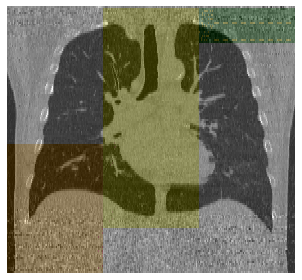

In [180]:
ct_df_plot = series_df 
regions_df_plot = regions_series_df_keep 

# max number of regions is 6 
colors = ['y', 'r', 'g', 'b', 'c', 'm']
template_region_list = ["Legs", "Pelvis", "Abdomen", "Chest", "Neck", "Head"]

from matplotlib import colors
cmap = colors.ListedColormap(['white','red', 'orange', 'yellow', 'green', 'blue', 'purple'])
bounds=[0,1,2,3,4,5,6,7]
norm = colors.BoundaryNorm(bounds, cmap.N)

# Get the center coronal slice from the CT volume 
ct_nii = os.path.join("/content/ct_qualitative", series_id + '.nii.gz')
nii = nib.load(ct_nii)
img = nii.get_fdata() 
dim = img.shape 
pixel_spacing = nii.header['pixdim'][1:4]
coronal_slice_index = np.uint16(np.floor(dim[1]/2))
coronal_slice = np.squeeze(img[:,coronal_slice_index,:])
coronal_slice_rotated = ndimage.rotate(coronal_slice, 90)

fig, ax = plt.subplots(1, 1)
# fig.set_size_inches(12,16)

plt.imshow(coronal_slice_rotated, 'gray', interpolation='none', aspect='auto')

# For each unique region, annotate the axial extent
unique_regions = list(dict.fromkeys(region_list))
num_unique_regions = len(unique_regions)
print('unique_regions: ' + str(unique_regions))
print('num_unique_regions: ' + str(num_unique_regions))

bpr_slice = np.zeros((img.shape[0],img.shape[2]))
num_slices = img.shape[2]

for n in range(0,num_unique_regions):
  # get the region name 
  region_name = unique_regions[n]
  match_index = template_region_list.index(region_name)
  # get the list of measurement groups for the region 
  measurement_groups = regions_df_plot[regions_df_plot["region"]==unique_regions[n]]["measurementGroup_number"].values
  # get the min value 
  min_index = np.min(measurement_groups)
  # get the max value 
  max_index = np.max(measurement_groups)
  # get the ratios
  min_ratio = np.uint32(np.floor( (n)*(1/num_unique_regions) * dim[0]))
  max_ratio = np.uint32(np.floor( (n+1)*(1/num_unique_regions) * dim[0]))
  # form the slice
  bpr_slice[min_ratio:max_ratio,min_index:max_index] = match_index # so each region will have the same color 


cor_aspect = pixel_spacing[2]/pixel_spacing[0]
bpr_slice_rotated = ndimage.rotate(bpr_slice,90)
ax.imshow(bpr_slice_rotated, cmap=cmap, aspect="auto", alpha=0.2, norm=norm, interpolation='none')
ax.set_aspect(cor_aspect)

plt.axis('off')
fig = ax.get_figure()
fig.tight_layout()
plt.show() 


In [181]:
dim[2]-np.floor((max_index-min_index)/2)

128.0

In [182]:
# # Get corresponding index of this landmark in the total list so we know what color to assign 
# landmark_name = landmarks_df_plot['landmark_names'].values[n] 
# ind = landmarks_inference_sorted_df.index[landmarks_inference_sorted_df['landmark_and_modifier_name'] == landmark_name].tolist()[0]
# color_index.append(ind)
# slice_index = landmarks_df_plot['slice_index'].values[n]
# slice_index = dim[2]-slice_index

# # plt.annotate(landmark_name,(dim[0],slice_index)) 
# plt.plot([dim[0]-10, dim[0]+10], 
#       [slice_index, slice_index],
#       color='w', 
#       linestyle='-')
# plt.annotate(landmark_name,xy=(dim[0]+1,slice_index), xycoords='data',annotation_clip=False)

### Query for patients that have the chest as a region 

In [205]:
# For each series, check if the chest is present in each 

all_series_ids = list(set(regions_series_df['crpes_ref'].values))
num_series_ids = len(all_series_ids) 

# form a df with the region 
region_list = [f['CodeMeaning'] for f in regions_series_df['findingSite'].values]
regions_series_df['region'] = region_list 

series_ids_no_chest = [] 

for n in range(0,num_series_ids): 
  # check if the chest is present 
  series_id = all_series_ids[n]
  region_names = regions_series_df[regions_series_df['crpes_ref']==series_id]['region'].values 
  if ("Chest" not in region_names):
    series_ids_no_chest.append(series_id)
print('series_ids_no_chest: ' + str(series_ids_no_chest)) # maybe can provide ohif links to these. 


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


series_ids_no_chest: []


In [206]:
regions_series_df

SOPInstanceUID  \
0       1.2.826.0.1.3680043.8.498.47109883464112489561...   
1       1.2.826.0.1.3680043.8.498.47109883464112489561...   
2       1.2.826.0.1.3680043.8.498.47109883464112489561...   
3       1.2.826.0.1.3680043.8.498.47109883464112489561...   
4       1.2.826.0.1.3680043.8.498.47109883464112489561...   
...                                                   ...   
525281  1.2.826.0.1.3680043.8.498.52360651387862114358...   
525282  1.2.826.0.1.3680043.8.498.52360651387862114358...   
525283  1.2.826.0.1.3680043.8.498.52360651387862114358...   
525284  1.2.826.0.1.3680043.8.498.52360651387862114358...   
525285  1.2.826.0.1.3680043.8.498.52360651387862114358...   

                                        SeriesInstanceUID  \
0       1.2.826.0.1.3680043.8.498.17591977014962625088...   
1       1.2.826.0.1.3680043.8.498.17591977014962625088...   
2       1.2.826.0.1.3680043.8.498.17591977014962625088...   
3       1.2.826.0.1.3680043.8.498.17591977014962625088...   
4       1.2.826.0.1.3680043.8.498.17591977014962625088...   
...                                                   ...   
525281  1.2.826.0.1.3680043.8.498.51710044121471262139...   
525282  1.2.826.0.1.3680043.8.498.51710044121471262139...   
525283  1.2.826.0.1.3680043.8.498.51710044121471262139...   
525284  1.2.826.0.1.3680043.8.498.51710044121471262139...   
525285  1.2.826.0.1.3680043.8.498.51710044121471262139...   

        measurementGroup_number  \
0                             0   
1                             1   
2                             2   
3                             3   
4                             4   
...                         ...   
525281                      168   
525282                      169   
525283                      170   
525284                      171   
525285                      172   

                                 trackingUniqueIdentifier  \
0       1.2.826.0.1.3680043.8.498.59223003979164663217...   
1       1.2.826.0.1.3680043.8.498.12110644019755963796...   
2       1.2.826.0.1.3680043.8.498.12446973130622678938...   
3       1.2.826.0.1.3680043.8.498.93476954629214038781...   
4       1.2.826.0.1.3680043.8.498.75185648682101610330...   
...                                                   ...   
525281  1.2.826.0.1.3680043.8.498.77433126165307537905...   
525282  1.2.826.0.1.3680043.8.498.86067189673982478232...   
525283  1.2.826.0.1.3680043.8.498.41917272087640635201...   
525284  1.2.826.0.1.3680043.8.498.10754913112010341228...   
525285  1.2.826.0.1.3680043.8.498.92672048600690068131...   

           trackingIdentifier PatientID collection_id  \
0         Annotations group 1    121786          nlst   
1         Annotations group 2    121786          nlst   
2         Annotations group 3    121786          nlst   
3         Annotations group 4    121786          nlst   
4         Annotations group 5    121786          nlst   
...                       ...       ...           ...   
525281  Annotations group 169    125378          nlst   
525282  Annotations group 170    125378          nlst   
525283  Annotations group 171    125378          nlst   
525284  Annotations group 172    125378          nlst   
525285  Annotations group 173    125378          nlst   

       sourceSegmentedSeriesUID  \
0                          None   
1                          None   
2                          None   
3                          None   
4                          None   
...                         ...   
525281                     None   
525282                     None   
525283                     None   
525284                     None   
525285                     None   

                           sourceReferencedSOPInstanceUID  \
0       1.2.840.113654.2.55.20503001219943604119303691...   
1       1.2.840.113654.2.55.77133815109476252260291015...   
2       1.2.840.113654.2.55.83896641494688547377354328...   
3       1.2.840.113654.2.55.13321613324146618687656341...   
4       1.2.

Now let's compare the percentages that the chest covers over all series

In [207]:
chest_percentages = [] 

for n in range(0,num_series_ids): 
  series_id = all_series_ids[n] 
  series_df = regions_series_df[regions_series_df['crpes_ref']==series_id]
  # get number of sop instance uids 
  num_sop = len(set(series_df['sourceReferencedSOPInstanceUID'].values))
  # get number where chest is present 
  num_chest = len(series_df[series_df['region'] == 'Chest'])
  chest_percentages.append(num_chest/num_sop)
print(chest_percentages)


[0.836, 0.8838709677419355, 0.7670454545454546, 0.8598726114649682, 0.8064516129032258, 0.8604651162790697, 0.8827160493827161, 0.7704081632653061, 0.734375, 0.8058823529411765, 0.8888888888888888, 0.7853403141361257, 0.782608695652174, 0.8789808917197452, 0.8511904761904762, 0.8709677419354839, 0.8776978417266187, 0.9572649572649573, 0.7810650887573964, 0.826271186440678, 0.9396551724137931, 0.7678571428571429, 0.855595667870036, 0.6448598130841121, 0.8359375, 0.9112903225806451, 0.863013698630137, 0.8588235294117647, 0.8695652173913043, 0.7786259541984732, 0.8169014084507042, 0.8813559322033898, 0.8373493975903614, 0.9166666666666666, 0.837037037037037, 0.8966666666666666, 0.8433734939759037, 0.8296703296703297, 0.9416666666666667, 0.8560606060606061, 0.6939890710382514, 0.7419354838709677, 0.8344370860927153, 0.7976878612716763, 0.8703703703703703, 0.8726114649681529, 1.0, 0.8866666666666667, 0.7259615384615384, 0.833922261484099, 0.8793103448275862, 0.7349397590361446, 1.0, 0.87037

Let's create a dataframe, link OHIF, and create a boxplot. For this we need the studyInstanceUID for each seriesInstanceUID. So we query. 

In [208]:
# Now get some sample OHIF url links 

# Query to get a single feature for one subject/series for all regions 
client = bigquery.Client(project=project_name)
table_id = ".".join(['bigquery-public-data', 'idc_current', 'dicom_all']) # later will change to use idc_current. 
print(table_id)

# For lung top 
query = f"""
    SELECT 
      # DISTINCT(CONCAT("https://viewer.imaging.datacommons.cancer.gov/viewer/",StudyInstanceUID,"?seriesInstanceUID=",SeriesInstanceUID)) as viewer_url, 
      DISTINCT(CONCAT("https://viewer.imaging.datacommons.cancer.gov/viewer/",StudyInstanceUID)) as viewer_url, 
      SeriesInstanceUID, 
      StudyInstanceUID
    FROM 
      {table_id}
    WHERE
      SeriesInstanceUID IN UNNEST (@all_series_ids);
    """ 

job_config = bigquery.QueryJobConfig(query_parameters=[
                                                       bigquery.ArrayQueryParameter("all_series_ids", "STRING", all_series_ids)
                                                       ])
series_with_viewer_df = client.query(query, job_config=job_config).to_dataframe()
series_with_viewer_df

bigquery-public-data.idc_current.dicom_all


viewer_url  \
0     https://viewer.imaging.datacommons.cancer.gov/...   
1     https://viewer.imaging.datacommons.cancer.gov/...   
2     https://viewer.imaging.datacommons.cancer.gov/...   
3     https://viewer.imaging.datacommons.cancer.gov/...   
4     https://viewer.imaging.datacommons.cancer.gov/...   
...                                                 ...   
1034  https://viewer.imaging.datacommons.cancer.gov/...   
1035  https://viewer.imaging.datacommons.cancer.gov/...   
1036  https://viewer.imaging.datacommons.cancer.gov/...   
1037  https://viewer.imaging.datacommons.cancer.gov/...   
1038  https://viewer.imaging.datacommons.cancer.gov/...   

                                      SeriesInstanceUID  \
0     1.2.840.113654.2.55.15235137508335113772888344...   
1     1.3.6.1.4.1.14519.5.2.1.7009.9004.696287406393...   
2     1.2.840.113654.2.55.20615379206892772643356087...   
3     1.3.6.1.4.1.14519.5.2.1.7009.9004.401862589013...   
4     1.3.6.1.4.1.14519.5.2.1.7009.9004.572219882663...   
...                                                 ...   
1034  1.2.840.113654.2.55.29085271732246162354893036...   
1035  1.2.840.113654.2.55.67095101227495808685302586...   
1036  1.2.840.113654.2.55.21068236616164308003084950...   
1037  1.3.6.1.4.1.14519.5.2.1.7009.9004.335613923676...   
1038  1.2.840.113654.2.55.80557134350152339289139946...   

                                       StudyInstanceUID  
0     1.2.840.113654.2.55.21416715364541125110522438...  
1     1.3.6.1.4.1.14519.5.2.1.7009.9004.160633511540...  
2     1.2.840.113654.2.55.85903563660852323961325089...  
3     1.3.6.1.4.1.14519.5.2.1.7009.9004.127097949009...  
4     1.3.6.1.4.1.14519.5.2.1.7009.9004.767845678759...  
...                                                 ...  
1034  1.2.840.113654.2.55.10170164875337023516415239...  
1035  1.2.840.113654.2.55.28137746817190974767494003...  
1036  1.2.840.113654.2.55.57267241703753267461857350...  
1037  1.3.6.1.4.1.14519.5.2.1.7009.9004.461475580434...  
1038  1.2.840.113654.2.55.29680888535835067072178042...  

[1039 rows x 3 columns]

In [209]:
chest_df = pd.DataFrame() 
chest_df['regions'] = ['Chest'] * len(all_series_ids)
chest_df['SeriesInstanceUID'] = all_series_ids
chest_df['StudyInstanceUID'] = series_with_viewer_df['StudyInstanceUID'].values
chest_df['ratios'] = chest_percentages
chest_df['viewer_url'] = series_with_viewer_df['viewer_url'].values
chest_df

regions                                  SeriesInstanceUID  \
0      Chest  1.3.6.1.4.1.14519.5.2.1.7009.9004.135069017703...   
1      Chest  1.2.840.113654.2.55.84734443626136410023970567...   
2      Chest  1.3.6.1.4.1.14519.5.2.1.7009.9004.179068386711...   
3      Chest  1.2.840.113654.2.55.31106280626995448537545159...   
4      Chest  1.2.840.113654.2.55.29721418253003035662525295...   
...      ...                                                ...   
1034   Chest  1.3.6.1.4.1.14519.5.2.1.7009.9004.364080506229...   
1035   Chest  1.2.840.113654.2.55.13672741274082781122803247...   
1036   Chest  1.3.6.1.4.1.14519.5.2.1.7009.9004.533873559327...   
1037   Chest  1.3.6.1.4.1.14519.5.2.1.7009.9004.177791496448...   
1038   Chest  1.2.840.113654.2.55.23873959467045563916961852...   

                                       StudyInstanceUID    ratios  \
0     1.2.840.113654.2.55.21416715364541125110522438...  0.836000   
1     1.3.6.1.4.1.14519.5.2.1.7009.9004.160633511540...  0.883871   
2     1.2.840.113654.2.55.85903563660852323961325089...  0.767045   
3     1.3.6.1.4.1.14519.5.2.1.7009.9004.127097949009...  0.859873   
4     1.3.6.1.4.1.14519.5.2.1.7009.9004.767845678759...  0.806452   
...                                                 ...       ...   
1034  1.2.840.113654.2.55.10170164875337023516415239...  0.756098   
1035  1.2.840.113654.2.55.28137746817190974767494003...  0.730496   
1036  1.2.840.113654.2.55.57267241703753267461857350...  0.826816   
1037  1.3.6.1.4.1.14519.5.2.1.7009.9004.461475580434...  0.892857   
1038  1.2.840.113654.2.55.29680888535835067072178042...  0.786765   

                                             viewer_url  
0     https://viewer.imaging.datacommons.cancer.gov/...  
1     https://viewer.imaging.datacommons.cancer.gov/...  
2     https://viewer.imaging.datacommons.cancer.gov/...  
3     https://viewer.imaging.datacommons.cancer.gov/...  
4     https://viewer.imaging.datacommons.cancer.gov/...  
...                                                 ...  
1034  https://viewer.imaging.datacommons.cancer.gov/...  
1035  https://viewer.imaging.datacommons.cancer.gov/...  
1036  https://viewer.imaging.datacommons.cancer.gov/...  
1037  https://viewer.imaging.datacommons.cancer.gov/...  
1038  https://viewer.imaging.datacommons.cancer.gov/...  

[1039 rows x 5 columns]

In [210]:
df_plot = chest_df

Now plot a boxplot showing the distribution of percentages 

In [211]:
output_notebook()

# Get a color for each region 
colormap, colors = color_list_generator(df_plot, 'regions')
df_plot['colors'] = colors
colormap_list_keys = list(colormap.keys())
print('colormap: ' + str(colormap))
print('colormap_list_keys: ' + str(colormap_list_keys))
regions = colormap_list_keys 
print('regions: ' + str(regions))

df_plot 

# Get a list of unique colors that match the order of the regions
# num_colors = len(list(set(colors)))
# colors = [] 
# for n in range(0,num_colors):
#   c = df_plot[df_plot['regions']==colormap_list_keys[n]]['colors'].values[0]
#   colors.append(c)

colors = list(colormap.values())
print('colors: ' + str(colors))

hover = HoverTool(tooltips=[
    ("(Ratio)", "($y)")
])

wZoom = WheelZoomTool()
bZoom = BoxZoomTool()
reset = ResetTool()
tap = TapTool()
pan = PanTool()

cats = df_plot.regions.unique()
print('cats: ' + str(cats))
print('regions: ' + str(regions))

p = figure(tools = [hover, wZoom, bZoom, reset, tap, pan],
           x_range=regions,
           # x_range=cats, 
           title="Ratios of slices assigned to each region")

p.circle(y='ratios', x=jitter('regions', width=0.6, range=p.x_range), source=df_plot, alpha=1, color='colors')

### Include the box plots ### 
# find the quartiles and IQR for each category

# regions are in order we want 
category_region = pd.api.types.CategoricalDtype(categories=regions, ordered=True)
df_plot['regions'] = df_plot['regions'].astype(category_region)

groups = df_plot.groupby('regions')
q1 = groups.quantile(q=0.25)
q2 = groups.quantile(q=0.5)
q3 = groups.quantile(q=0.75)
iqr = q3 - q1
upper = q3 + 1.5*iqr
lower = q1 - 1.5*iqr
 
# Form the source data to call vbar for upper and lower
# boxes to be formed later.
upper_source = ColumnDataSource(data=dict(
    x=cats, 
    bottom=q2.ratios,
    top=q3.ratios,
    fill_color=colors,
    legend=cats
))
 
lower_source = ColumnDataSource(data=dict(
    x=cats, 
    bottom=q1.ratios,
    top=q2.ratios,
    fill_color=colors
))
 
 
# p = figure(tools="save", title="", x_range=df_plot.regions.unique())
 
# stems (Don't need colors of treatment)
p.segment(cats, upper.ratios, cats, q3.ratios, line_color="black")
p.segment(cats, lower.ratios, cats, q1.ratios, line_color="black")
 
# Add the upper and lower quartiles
l=p.vbar(source = upper_source, x='x', width=0.7, bottom='bottom', top='top', fill_color='fill_color', line_color="black")
p.vbar(source = lower_source, x='x', width=0.7, bottom='bottom', top='top', fill_color='fill_color', line_color="black")
 
# whiskers (almost-0 height rects simpler than segments)
p.rect(cats, lower.ratios, 0.2, 0.000001, line_color="black") # was 0.01
p.rect(cats, upper.ratios, 0.2, 0.000001, line_color="black")

# Using the newer autogrouped syntax.
# Grab a renderer, in this case upper quartile and then
# create the legend explicitly.  
# Guidance from: https://groups.google.com/a/continuum.io/forum/#!msg/bokeh/uEliQlgj390/Jyhsc5HqAAAJ
legend = Legend(items=[LegendItem(label=dict(field="x"), renderers=[l])])
 
p.add_layout(legend, 'below')    
 
# Setup plot titles and such.
p.title.text = "Ratio of slices for each body part examined region"
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = "white"
p.grid.grid_line_width = 2
p.xaxis.major_label_text_font_size="0pt"
p.xaxis.major_label_orientation = np.pi/4
p.xaxis.axis_label="Regions"
p.yaxis.axis_label="Ratio"
p.legend.location = (100,10)
 
# show(p)



########
# p.legend.visible=False 

url="@viewer_url"
taptool = p.select(type=TapTool)
taptool.callback = OpenURL(url=url)

show(p)


#### 


check this value: 1
('#1b9e77',)
colormap: {'Chest': '#1b9e77'}
colormap_list_keys: ['Chest']
regions: ['Chest']
colors: ['#1b9e77']
cats: ['Chest']
regions: ['Chest']


Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.


### (paper figure #10) - NLST - Plot the distributions of ratios of slices assigned to each region

Let's calculate the percentages for each of the regions, and not only the chest 

In [220]:
# Get the list of regions 
list_of_regions = list(set(regions_series_df['region'].values)) 
print('list_of_regions: ' + str(list_of_regions))

all_series_ids = list(set(regions_series_df['crpes_ref'].values))
num_series_ids = len(all_series_ids) 
print('num_series_ids: ' + str(num_series_ids))

### For each region ### 

region_percentages = [] 
region_series_ids = [] 
region_list = [] 

for m in range(0,len(list_of_regions)): 
  print(list_of_regions[m])
  ### For each series ### 
  for n in range(0,num_series_ids): 
    series_id = all_series_ids[n] 
    series_df = regions_series_df[regions_series_df['crpes_ref']==series_id]
    # get number where region is present 
    num_region = len(series_df[series_df['region'] == list_of_regions[m]])
    if (num_region>0):
      # get number of sop instance uids 
      num_sop = len(set(series_df['sourceReferencedSOPInstanceUID'].values))
      # Append
      region_series_ids.append(series_id)
      region_list.append(list_of_regions[m])
      region_percentages.append(num_region/num_sop)


list_of_regions: ['Head', 'Abdomen', 'Neck', 'Chest']
num_series_ids: 1039
Head
Abdomen
Neck
Chest


Let's start to form the dataframe for plotting

In [221]:
df_plot = pd.DataFrame() 
df_plot['SeriesInstanceUID'] = region_series_ids 
df_plot['regions'] = region_list
df_plot['ratios'] = region_percentages 
df_plot 

SeriesInstanceUID  regions    ratios
0     1.2.840.113654.2.55.17922076604756733648279336...     Head  0.005952
1     1.3.6.1.4.1.14519.5.2.1.7009.9004.135069017703...  Abdomen  0.500000
2     1.2.840.113654.2.55.84734443626136410023970567...  Abdomen  0.445161
3     1.3.6.1.4.1.14519.5.2.1.7009.9004.179068386711...  Abdomen  0.460227
4     1.2.840.113654.2.55.31106280626995448537545159...  Abdomen  0.414013
...                                                 ...      ...       ...
3113  1.3.6.1.4.1.14519.5.2.1.7009.9004.364080506229...    Chest  0.756098
3114  1.2.840.113654.2.55.13672741274082781122803247...    Chest  0.730496
3115  1.3.6.1.4.1.14519.5.2.1.7009.9004.533873559327...    Chest  0.826816
3116  1.3.6.1.4.1.14519.5.2.1.7009.9004.177791496448...    Chest  0.892857
3117  1.2.840.113654.2.55.23873959467045563916961852...    Chest  0.786765

[3118 rows x 3 columns]

Now let's query to get the ohif viewer links

In [224]:
# Now get some sample OHIF url links 

# Query to get a single feature for one subject/series for all regions 
client = bigquery.Client(project=project_name)
table_id = ".".join(['bigquery-public-data', 'idc_current', 'dicom_all']) # later will change to use idc_current. 
print(table_id)

# For lung top 
query = f"""
    SELECT 
      # DISTINCT(CONCAT("https://viewer.imaging.datacommons.cancer.gov/viewer/",StudyInstanceUID,"?seriesInstanceUID=",SeriesInstanceUID)) as viewer_url, 
      DISTINCT(CONCAT("https://viewer.imaging.datacommons.cancer.gov/viewer/",StudyInstanceUID)) as viewer_url, 
      SeriesInstanceUID, 
      StudyInstanceUID
    FROM 
      {table_id}
    WHERE
      SeriesInstanceUID IN UNNEST (@all_series_ids);
    """ 

job_config = bigquery.QueryJobConfig(query_parameters=[
                                                       bigquery.ArrayQueryParameter("all_series_ids", "STRING", region_series_ids)
                                                       ])
df_ohif = client.query(query, job_config=job_config).to_dataframe()
df_ohif

bigquery-public-data.idc_current.dicom_all


viewer_url  \
0     https://viewer.imaging.datacommons.cancer.gov/...   
1     https://viewer.imaging.datacommons.cancer.gov/...   
2     https://viewer.imaging.datacommons.cancer.gov/...   
3     https://viewer.imaging.datacommons.cancer.gov/...   
4     https://viewer.imaging.datacommons.cancer.gov/...   
...                                                 ...   
1034  https://viewer.imaging.datacommons.cancer.gov/...   
1035  https://viewer.imaging.datacommons.cancer.gov/...   
1036  https://viewer.imaging.datacommons.cancer.gov/...   
1037  https://viewer.imaging.datacommons.cancer.gov/...   
1038  https://viewer.imaging.datacommons.cancer.gov/...   

                                      SeriesInstanceUID  \
0     1.3.6.1.4.1.14519.5.2.1.7009.9004.192525281608...   
1     1.3.6.1.4.1.14519.5.2.1.7009.9004.834417263173...   
2     1.2.840.113654.2.55.15235137508335113772888344...   
3     1.3.6.1.4.1.14519.5.2.1.7009.9004.696287406393...   
4     1.3.6.1.4.1.14519.5.2.1.7009.9004.332444094757...   
...                                                 ...   
1034  1.3.6.1.4.1.14519.5.2.1.7009.9004.114212363146...   
1035  1.2.840.113654.2.55.28939026768080810409407641...   
1036  1.2.840.113654.2.55.33042012043362399213685129...   
1037  1.2.840.113654.2.55.27187683930646114013187648...   
1038  1.2.840.113654.2.55.11090290541952056021282007...   

                                       StudyInstanceUID  
0     1.3.6.1.4.1.14519.5.2.1.7009.9004.130235038526...  
1     1.3.6.1.4.1.14519.5.2.1.7009.9004.246156327214...  
2     1.2.840.113654.2.55.21416715364541125110522438...  
3     1.3.6.1.4.1.14519.5.2.1.7009.9004.160633511540...  
4     1.3.6.1.4.1.14519.5.2.1.7009.9004.316106400200...  
...                                                 ...  
1034  1.3.6.1.4.1.14519.5.2.1.7009.9004.129111469500...  
1035  1.2.840.113654.2.55.22835224307907880875083018...  
1036  1.2.840.113654.2.55.16782374995397444318825508...  
1037  1.2.840.113654.2.55.18610364664272246062953040...  
1038  1.2.840.113654.2.55.21474429816804812247790802...  

[1039 rows x 3 columns]

Let's add the ohif viewer links to the dataframe 

In [226]:
# df_plot['viewer_url'] = df_ohif['viewer_url'].values 

viewer_urls = [] 
for n in range(0,len(region_series_ids)):
  series_id = region_series_ids[n] 
  viewer_url = df_ohif[df_ohif['SeriesInstanceUID']==series_id]['viewer_url'].values[0] 
  viewer_urls.append(viewer_url)
df_plot['viewer_url'] = viewer_urls 


Let's plot the region percentages for NSLT 

In [227]:
output_notebook()

# Get a color for each region 
colormap, colors = color_list_generator(df_plot, 'regions')
df_plot['colors'] = colors
colormap_list_keys = list(colormap.keys())
print('colormap: ' + str(colormap))
print('colormap_list_keys: ' + str(colormap_list_keys))
regions = colormap_list_keys 
print('regions: ' + str(regions))

# Get a list of unique colors that match the order of the regions
# num_colors = len(list(set(colors)))
# colors = [] 
# for n in range(0,num_colors):
#   c = df_plot[df_plot['regions']==colormap_list_keys[n]]['colors'].values[0]
#   colors.append(c)

colors = list(colormap.values())
print('colors: ' + str(colors))

hover = HoverTool(tooltips=[
    ("(Ratio)", "($y)")
])

wZoom = WheelZoomTool()
bZoom = BoxZoomTool()
reset = ResetTool()
tap = TapTool()
pan = PanTool()

cats = df_plot.regions.unique()
print('cats: ' + str(cats))
print('regions: ' + str(regions))

p = figure(tools = [hover, wZoom, bZoom, reset, tap, pan],
           x_range=regions,
           # x_range=cats, 
           title="Ratios of slices assigned to each region")

p.circle(y='ratios', x=jitter('regions', width=0.6, range=p.x_range), source=df_plot, alpha=1, color='colors')

### Include the box plots ### 
# find the quartiles and IQR for each category

# regions are in order we want 
category_region = pd.api.types.CategoricalDtype(categories=regions, ordered=True)
df_plot['regions'] = df_plot['regions'].astype(category_region)

groups = df_plot.groupby('regions')
q1 = groups.quantile(q=0.25)
q2 = groups.quantile(q=0.5)
q3 = groups.quantile(q=0.75)
iqr = q3 - q1
upper = q3 + 1.5*iqr
lower = q1 - 1.5*iqr
 
# Form the source data to call vbar for upper and lower
# boxes to be formed later.
upper_source = ColumnDataSource(data=dict(
    x=cats, 
    bottom=q2.ratios,
    top=q3.ratios,
    fill_color=colors,
    legend=cats
))
 
lower_source = ColumnDataSource(data=dict(
    x=cats, 
    bottom=q1.ratios,
    top=q2.ratios,
    fill_color=colors
))
 
 
# p = figure(tools="save", title="", x_range=df_plot.regions.unique())
 
# stems (Don't need colors of treatment)
p.segment(cats, upper.ratios, cats, q3.ratios, line_color="black")
p.segment(cats, lower.ratios, cats, q1.ratios, line_color="black")
 
# Add the upper and lower quartiles
l=p.vbar(source = upper_source, x='x', width=0.7, bottom='bottom', top='top', fill_color='fill_color', line_color="black")
p.vbar(source = lower_source, x='x', width=0.7, bottom='bottom', top='top', fill_color='fill_color', line_color="black")
 
# whiskers (almost-0 height rects simpler than segments)
p.rect(cats, lower.ratios, 0.2, 0.000001, line_color="black") # was 0.01
p.rect(cats, upper.ratios, 0.2, 0.000001, line_color="black")

# Using the newer autogrouped syntax.
# Grab a renderer, in this case upper quartile and then
# create the legend explicitly.  
# Guidance from: https://groups.google.com/a/continuum.io/forum/#!msg/bokeh/uEliQlgj390/Jyhsc5HqAAAJ
legend = Legend(items=[LegendItem(label=dict(field="x"), renderers=[l])])
 
p.add_layout(legend, 'below')    
 
# Setup plot titles and such.
p.title.text = "Ratio of slices for each body part examined region"
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = "white"
p.grid.grid_line_width = 2
p.xaxis.major_label_text_font_size="0pt"
p.xaxis.major_label_orientation = np.pi/4
p.xaxis.axis_label="Regions"
p.yaxis.axis_label="Ratio"
p.legend.location = (100,10)
 
# show(p)



########
# p.legend.visible=False 

url="@viewer_url"
taptool = p.select(type=TapTool)
taptool.callback = OpenURL(url=url)

show(p)


#### 


check this value: 4
('#1b9e77', '#d95f02', '#7570b3', '#e7298a')
colormap: {'Head': '#1b9e77', 'Abdomen': '#d95f02', 'Neck': '#7570b3', 'Chest': '#e7298a'}
colormap_list_keys: ['Head', 'Abdomen', 'Neck', 'Chest']
regions: ['Head', 'Abdomen', 'Neck', 'Chest']
colors: ['#1b9e77', '#d95f02', '#7570b3', '#e7298a']
cats: ['Head' 'Abdomen' 'Neck' 'Chest']
regions: ['Head', 'Abdomen', 'Neck', 'Chest']


Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.


### Download the regions DICOM SR for a single series 

In [ ]:
# landmarks_series_df = landmarks_regions_df[landmarks_regions_df['trackingIdentifier'].str.contains("landmarks")]
regions_series_df = landmarks_regions_df[~landmarks_regions_df['trackingIdentifier'].str.contains("landmarks")]

In [ ]:
# Pick a single SOPInstanceUID 
SOPInstanceUID_regions = regions_series_df['SOPInstanceUID'].values
SOPInstanceUID_region = SOPInstanceUID_regions[0] 
SOPInstanceUID_region 

'1.2.826.0.1.3680043.8.498.21061870466070764068508062138024860842'

In [ ]:
# Instead try with this SOPInstanceUID from LUNG1-001 as we know the first slice has 2 landmarks 

# SOPInstanceUID_landmark = '1.2.826.0.1.3680043.8.498.98304286221164847735172539704744156702'


In [ ]:
# Get the gcs_url for download for the above sourceSegmentedSeriesUID 

client = bigquery.Client(project=project_name)
table_id = ".".join(['bigquery-public-data', 'idc_current', 'dicom_all'])
print(table_id)

query = f"""
  SELECT 
    SeriesDescription, 
    gcs_url
  FROM 
    {table_id}
  WHERE
    # Modality = "SR" AND 
    # collection_id = "nsclc_radiomics" AND 
    SOPInstanceUID = @SOPInstanceUID
"""

job_config = bigquery.QueryJobConfig(query_parameters=[
                                                       bigquery.ScalarQueryParameter("SOPInstanceUID", "STRING", SOPInstanceUID_region)
                                                       ])
sr_df = client.query(query, job_config=job_config).to_dataframe()

bigquery-public-data.idc_current.dicom_all


In [ ]:
sr_df

SeriesDescription                                            gcs_url
0  BPR region annotations  gs://public-datasets-idc/ab50a4ce-1c66-4922-b0...

In [ ]:
# Download this single SR 

# Create the text file to hold gsc_url 
gcsurl_temp = sr_df["gcs_url"]
gs_file_path = "gcs_paths.txt"
gcsurl_temp.to_csv(gs_file_path, header = False, index = False)

# Download the series 
sr_directory = "/content/sr_regions"
if not os.path.isdir(sr_directory):
  os.mkdir(sr_directory)

# !cat manifest.txt | gsutil -m cp -I .
!cat gcs_paths.txt | gsutil -m cp -I $sr_directory

# Rename file with sr.dcm 
sr_file_temp = [os.path.join(sr_directory,f) for f in os.listdir(sr_directory) if f.endswith('.dcm')][0]
sr_file = os.path.join(sr_directory, 'sr.dcm')
print(sr_file_temp)
print(sr_file)
shutil.move(sr_file_temp, sr_file)

Copying gs://public-datasets-idc/ab50a4ce-1c66-4922-b0b8-25f169187bb6.dcm...
/ [1/1 files][152.4 KiB/152.4 KiB] 100% Done                                    
Operation completed over 1 objects/152.4 KiB.                                    
/content/sr_regions/ab50a4ce-1c66-4922-b0b8-25f169187bb6.dcm
/content/sr_regions/sr.dcm


'/content/sr_regions/sr.dcm'

### Use highdicom to read extract the relevant fields from the SR

In [ ]:
# Read the regions SR 

from pathlib import Path

import highdicom as hd
from pydicom.filereader import dcmread
from pydicom.sr.codedict import codes

regions_sr_df = pd.DataFrame() 
slice_indices = [] 
region_names = [] 
modifier_names = [] 
ref_sop_ids = [] 

# Path to SR document instance stored as PS3.10 file
print('sr_file: ' + str(sr_file))
document_file = Path(sr_file)

# Load document from file on disk
sr_dataset = dcmread(str(document_file))

# Find all content items that may contain other content items.
containers_level1 = hd.sr.utils.find_content_items(
    dataset=sr_dataset,
    relationship_type=RelationshipTypeValues.CONTAINS
)

# This will return a list of length = number of slices that contain regions 
containers_level2 = hd.sr.utils.find_content_items(
    dataset=containers_level1[0],
    relationship_type=RelationshipTypeValues.CONTAINS, 
    value_type=ValueTypeValues.CONTAINER
)
num_slices_with_regions = len(containers_level2)
# print('num_slices_with_regions: ' + str(num_slices_with_regions))

# Loop over num_slices_with_regions
for slice_index in range(0,num_slices_with_regions):

  # print ('slice_index: ' + str(slice_index))

  # Get the referencedSOPInstanceUID
  sop = hd.sr.utils.find_content_items(
    dataset=containers_level2[slice_index],
    relationship_type=RelationshipTypeValues.CONTAINS
  )
  sop_instance_uid = sop[0].ReferencedSOPSequence[0].ReferencedSOPInstanceUID
  # print('   referenced_sop_instance_uid: ' + str(sop_instance_uid))

  # Get container to be used for the region
  containers_level3 = hd.sr.utils.find_content_items(
      dataset=containers_level2[slice_index],
      relationship_type=RelationshipTypeValues.HAS_CONCEPT_MOD, 
      value_type=ValueTypeValues.CODE
  )
  num_regions_in_slice = len(containers_level3)
  # print('   num_regions_in_slice: ' + str(num_regions_in_slice))

  # Loop over the number of regions in the slice 
  for region_index in range(0,num_regions_in_slice): 

    # Now get the region name 
    region_name = hd.sr.utils.get_coded_value(containers_level3[region_index])['CodeMeaning'].value
    # print('   region_name: ' + str(region_name))

    slice_indices.append(slice_index)
    region_names.append(region_name)
    ref_sop_ids.append(sop_instance_uid)



# Create df
regions_sr_df['slice_index'] = slice_indices
regions_sr_df['region_name'] = region_names 
regions_sr_df['ref_sop_id'] = ref_sop_ids

regions_sr_df

sr_file: /content/sr_regions/sr.dcm


slice_index region_name  \
0              0     Abdomen   
1              1     Abdomen   
2              2     Abdomen   
3              3     Abdomen   
4              4     Abdomen   
..           ...         ...   
194          130        Head   
195          131        Head   
196          132        Head   
197          133        Head   
198          134        Head   

                                            ref_sop_id  
0    1.3.6.1.4.1.32722.99.99.1725268650834763767057...  
1    1.3.6.1.4.1.32722.99.99.1293645693754237467902...  
2    1.3.6.1.4.1.32722.99.99.1202989843503726553501...  
3    1.3.6.1.4.1.32722.99.99.1065485646772339129535...  
4    1.3.6.1.4.1.32722.99.99.9790104117165574828585...  
..                                                 ...  
194  1.3.6.1.4.1.32722.99.99.5211685887577845628123...  
195  1.3.6.1.4.1.32722.99.99.1097725445974189382713...  
196  1.3.6.1.4.1.32722.99.99.2382707982603339029007...  
197  1.3.6.1.4.1.32722.99.99.2177563741043547935980...  
198  1.3.6.1.4.1.32722.99.99.1703190471787008043017...  

[199 rows x 3 columns]

In [ ]:
# Read the regions SR 

from pathlib import Path

import highdicom as hd
from pydicom.filereader import dcmread
from pydicom.sr.codedict import codes

landmarks_sr_df = pd.DataFrame() 
slice_indices = [] 
landmark_names = [] 
modifier_names = [] 
ref_sop_ids = [] 

# Path to SR document instance stored as PS3.10 file
print('sr_file: ' + str(sr_file))
document_file = Path(sr_file)

# Load document from file on disk
sr_dataset = dcmread(str(document_file))

# Find all content items that may contain other content items.
containers_level1 = hd.sr.utils.find_content_items(
    dataset=sr_dataset,
    relationship_type=RelationshipTypeValues.CONTAINS
)

# This will return a list of length = number of slices that contain landmarks 
containers_level2 = hd.sr.utils.find_content_items(
    dataset=containers_level1[0],
    relationship_type=RelationshipTypeValues.CONTAINS, 
    value_type=ValueTypeValues.CONTAINER
)
num_slices_with_landmarks = len(containers_level2)
print('num_slices_with_landmarks: ' + str(num_slices_with_landmarks))

# Loop over num_slices_with_landmarks
for slice_index in range(0,num_slices_with_landmarks):

  print ('slice_index: ' + str(slice_index))

  # Get the referencedSOPInstanceUID
  sop = hd.sr.utils.find_content_items(
  dataset=containers_level2[slice_index],
  relationship_type=RelationshipTypeValues.CONTAINS
  )
  sop_instance_uid = sop[0].ReferencedSOPSequence[0].ReferencedSOPInstanceUID
  print('   referenced_sop_instance_uid: ' + str(sop_instance_uid))

  # Get container to be used for the landmark and modifier 
  containers_level3 = hd.sr.utils.find_content_items(
      dataset=containers_level2[slice_index],
      relationship_type=RelationshipTypeValues.HAS_CONCEPT_MOD, 
      value_type=ValueTypeValues.CODE
  )
  num_landmarks_in_slice = len(containers_level3)
  print('   num_landmarks_in_slice: ' + str(num_landmarks_in_slice))

  # Loop over the number of landmarks in the slice 
  for landmark_index in range(0,num_landmarks_in_slice): 

    # Now get the landmark name 
    landmark_name = hd.sr.utils.get_coded_value(containers_level3[landmark_index])['CodeMeaning'].value
    print('   landmark_name: ' + str(landmark_name))

    # Now get the modifier
    modifier =  hd.sr.utils.find_content_items(
        dataset=containers_level3[landmark_index],
        relationship_type=RelationshipTypeValues.HAS_CONCEPT_MOD, 
        value_type=ValueTypeValues.CODE
    )
    modifier_name = hd.sr.utils.get_coded_value(modifier[0])['CodeMeaning'].value
    print('   modifier_name: ' + str(modifier_name))

    slice_indices.append(slice_index)
    landmark_names.append(landmark_name)
    modifier_names.append(modifier_name)
    ref_sop_ids.append(sop_instance_uid)

# Create df
landmarks_sr_df['landmark_name'] = landmark_names 
landmarks_sr_df['modifier_name'] = modifier_names 
landmarks_sr_df['ref_sop_id'] = ref_sop_ids

landmarks_sr_df



sr_file: /content/sr_landmarks/sr.dcm
num_slices_with_landmarks: 20
slice_index: 0
   referenced_sop_instance_uid: 1.3.6.1.4.1.32722.99.99.305629633035562593745800399744408635913
   num_landmarks_in_slice: 2
   landmark_name: Kidney
   modifier_name: Bottom
   landmark_name: L2 vertebra
   modifier_name: Center
slice_index: 1
   referenced_sop_instance_uid: 1.3.6.1.4.1.32722.99.99.43054485334186588574623352561885187921
   num_landmarks_in_slice: 1
   landmark_name: L1 vertebra
   modifier_name: Center
slice_index: 2
   referenced_sop_instance_uid: 1.3.6.1.4.1.32722.99.99.263159010186857259023681147179880990863
   num_landmarks_in_slice: 1
   landmark_name: Lung
   modifier_name: Bottom
slice_index: 3
   referenced_sop_instance_uid: 1.3.6.1.4.1.32722.99.99.82802603186227822638651463200656463022
   num_landmarks_in_slice: 1
   landmark_name: T12 vertebra
   modifier_name: Center
slice_index: 4
   referenced_sop_instance_uid: 1.3.6.1.4.1.32722.99.99.8901906612198818796071007089102165819
 

landmark_name modifier_name  \
0         Kidney        Bottom   
1    L2 vertebra        Center   
2    L1 vertebra        Center   
3           Lung        Bottom   
4   T12 vertebra        Center   
5   T11 vertebra        Center   
6   T10 vertebra        Center   
7    T9 vertebra        Center   
8          Liver           Top   
9    T8 vertebra        Center   
10   T7 vertebra        Center   
11   T6 vertebra        Center   
12   T5 vertebra        Center   
13   T4 vertebra        Center   
14   T3 vertebra        Center   
15   T2 vertebra        Center   
16          Lung           Top   
17   T1 vertebra        Center   
18   C7 vertebra        Center   
19   C6 vertebra        Center   
20   C5 vertebra        Center   

                                           ref_sop_id  
0   1.3.6.1.4.1.32722.99.99.3056296330355625937458...  
1   1.3.6.1.4.1.32722.99.99.3056296330355625937458...  
2   1.3.6.1.4.1.32722.99.99.4305448533418658857462...  
3   1.3.6.1.4.1.32722.99.99.2631590101868572590236...  
4   1.3.6.1.4.1.32722.99.99.8280260318622782263865...  
5   1.3.6.1.4.1.32722.99.99.8901906612198818796071...  
6   1.3.6.1.4.1.32722.99.99.1651333239617429298390...  
7   1.3.6.1.4.1.32722.99.99.9243908860590178711883...  
8   1.3.6.1.4.1.32722.99.99.1378828584856047266870...  
9   1.3.6.1.4.1.32722.99.99.2451475860807041443665...  
10  1.3.6.1.4.1.32722.99.99.1868178790879465204302...  
11  1.3.6.1.4.1.32722.99.99.2606911222960897193555...  
12  1.3.6.1.4.1.32722.99.99.2685644298334541924431...  
13  1.3.6.1.4.1.32722.99.99.1348203431001892457304...  
14  1.3.6.1.4.1.32722.99.99.1526214918071743791952...  
15  1.3.6.1.4.1.32722.99.99.1457754966556520104945...  
16  1.3.6.1.4.1.32722.99.99.1132685649015073607577...  
17  1.3.6.1.4.1.32722.99.99.2004209890493027147183...  
18  1.3.6.1.4.1.32722.99.99.8272255297509386841485...  
19  1.3.6.1.4.1.32722.99.99.9026083532693705200338...  
20  1.3.6.1.4.1.32722.99.99.2018948692637691479971...

### Use dcmqi to read the SR 